Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=0 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
241                           NaN                Thailand  15.870032   
242                           NaN             Timor-Leste  -8.874217   
243                           NaN                    Togo   8.619500   
244                           NaN     Trinidad and Tobago  10.691800   
245                           NaN                 Tunisia  33.886917   
246                           NaN                  Turkey  38.963700   
247                           NaN           United States  40.000000   
248                           NaN                  Uganda   1.373333   
249                           NaN                 Ukraine  48.379400   
250                           NaN    United Arab Emirates  23.424076   
251                      Anguilla          United Kingdom  18.220600   
252                       Bermuda          United Kingdom  32.307800   
253        British Virgin Islands          United Kingdom  18.420700   
254                Cayman Islands          United Kingdom  19.313300   
255               Channel Islands          United Kingdom  49.372300   
256   Falkland Islands (Malvinas)          United Kingdom -51.796300   
257                     Gibraltar          United Kingdom  36.140800   
258                   Isle of Man          United Kingdom  54.236100   
259                    Montserrat          United Kingdom  16.742498   
260      Turks and Caicos Islands          United Kingdom  21.694000   
261                           NaN          United Kingdom  55.378100   
262                           NaN                 Uruguay -32.522800   
263                           NaN              Uzbekistan  41.377491   
264                           NaN                 Vanuatu -

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
247                           NaN                Thailand  15.870032   
248                           NaN             Timor-Leste  -8.874217   
249                           NaN                    Togo   8.619500   
250                           NaN     Trinidad and Tobago  10.691800   
251                           NaN                 Tunisia  33.886917   
252                           NaN                  Turkey  38.963700   
253                           NaN           United States  40.000000   
254                           NaN                  Uganda   1.373333   
255                           NaN                 Ukraine  48.379400   
256                           NaN    United Arab Emirates  23.424076   
257                      Anguilla          United Kingdom  18.220600   
258                       Bermuda          United Kingdom  32.307800   
259        British Virgin Islands          United Kingdom  18.420700   
260                Cayman Islands          United Kingdom  19.313300   
261               Channel Islands          United Kingdom  49.372300   
262   Falkland Islands (Malvinas)          United Kingdom -51.796300   
263                     Gibraltar          United Kingdom  36.140800   
264                   Isle of Man          United Kingdom  54.236100   
265                    Montserrat          United Kingdom  16.742498   
266      Turks and Caicos Islands          United Kingdom  21.694000   
267                           NaN          United Kingdom  55.378100   
268                           NaN                 Uruguay -32.522800   
269                           NaN              Uzbekistan  41.377491   
270                           NaN                 Vanuatu -

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/5/20  12/6/20  12/7/20  \
185        0        0        0        0  ...       10       10       10   
186        0        0        0        0  ...   109456   109717   110074   
187        0        0        0        0  ...     2403     2419     2438   
188        0        0        0        0  ...        3        3        3   
189        0        0        0        0  ...        0        0        0   
190        0        0        0        0  ...      530      533      543   
191        0        0        0        0  ...     6184     6245     6320   
192        0        0        0        0  ...      133      133      136   
193        0        0        0        0  ...      152      152      152   
194        0        0        0        0  ...     1577     1594     1614   

     12/8/20  12/9/20  12/10/20  12/11/20  12/12/20   Population   \
185       10       10        10        10        10           NaN   
186   110874   111655    112326    113019    113704   128,640,794   
187     2460     2481      2500      2521      2547     4,035,942   
188        3        3         3         3         3        39,183   
189        0        0         0         0         0           NaN   
190      549      556       566       569       578       622 500   
191     6370     6427      6492      6542      6589    36,817,128   
192      136      138       139       139       140    31,542,919   
193      153      155       158       160       160     2,540,905   
194     1637     1651      1663      1674      1689    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 332 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/5/20  \
175        0        0        0        0        0        0  ...    14343   
176        0        0        0        0        0        0  ...    13908   
177        0        0        0        0        0        0  ...   224053   
178        0        0        0        0        0        0  ...     4763   
179        0        0        0        0        0        0  ...      158   
180        0        0        0        0        0        0  ...     1328   
181        0        0        0        0        0        0  ...     1017   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...     1997   
184        0        0        0        0        0        0  ...     4225   

     12/6/20  12/7/20  12/8/20  12/9/20  12/10/20  12/11/20  12/12/20  \
175    14416    14429    14437    14684     14715     14793     14795   
176    13939    13949    14004    14195     14218     14332     14582   
177   225805   227433   229054   230537    231601    232872    234231   
178     4788     4801     4827     4856      4865      4879      4890   
179      158      158      159      160       160       160       165   
180     1337     1352     1386     1488      1568      1638      1708   
181     1017     1030     1041     1047      1058      1070      1075   
182        0        0        0        0         0         0         0   
183     1998     2006     2008     2008      2010      2010      2015   
184     4225     4225     4225     4225      4225      4225      4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176     2,540,905                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180       158,665                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 332 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN      Mauritius -20.348404   57.552152        0        0   
186            NaN         Mexico  23.634500 -102.552800        0        0   
187            NaN        Moldova  47.411600   28.369900        0        0   
188            NaN         Monaco  43.733300    7.416700        0        0   
189            NaN       Mongolia  46.862500  103.846700        0        0   
190            NaN     Montenegro  42.708678   19.374390        0        0   
191            NaN        Morocco  31.791700   -7.092600        0        0   
192            NaN     Mozambique -18.665695   35.529562        0        0   
193            NaN        Namibia -22.957600   18.490400        0        0   
194            NaN          Nepal  28.166700   84.250000        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  12/5/20  12/6/20  12/7/20  \
185        0        0        0        0  ...      508      508      511   
186        0        0        0        0  ...  1168395  1175850  1182249   
187        0        0        0        0  ...   115557   116365   117495   
188        0        0        0        0  ...      637      638      641   
189        0        0        0        0  ...      849      887      888   
190        0        0        0        0  ...    37879    38246    38562   
191        0        0        0        0  ...   376738   379657   381188   
192        0        0        0        0  ...    16133    16244    16326   
193        0        0        0        0  ...    14950    15078    15219   
194        0        1        1        1  ...   239885   240981   241995   

     12/8/20  12/9/20  12/10/20  12/11/20  12/12/20   Population   \
185      515      515       515       515       515           NaN   
186  1193255  1205229   1217126   1229379   1241436   128,640,794   
187   119204   120970    122685    124264    125723     4,035,942   
188      648      655       657       659       668        39,183   
189      893      898       905       906       907           NaN   
190    39153    39607     40165     40546     40948       622 500   
191   384088   388184    391529    394564    397597    36,817,128   
192    16373    16440     16521     16680     16812    31,542,919   
193    15298    15472     15773     16097     16269     2,540,905   
194   243377   244433    245650    246694    247593    29,300,000   

             region  
185   Mauritius_nan  
186      Mexico_nan  
187     Moldova_nan  
188      Monaco_nan  
189    Mongolia_nan  
190  Montenegro_nan  
191     Morocco_nan  
192  Mozambique_nan  
193     Namibia_nan  
194       Nepal_nan  

[10 rows x 332 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                       Saint Lucia  13.909400  -60.978900   
221            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
222            NaN                             Samoa -13.759000 -172.104600   
223            NaN                        San Marino  43.942400   12.457800   
224            NaN             Sao Tome and Principe   0.186400    6.613100   
225            NaN                      Saudi Arabia  23.885942   45.079162   
226            NaN                           Senegal  14.497400  -14.452400   
227            NaN                            Serbia  44.016500   21.005900   
228            NaN                        Seychelles  -4.679600   55.492000   
229            NaN                      Sierra Leone   8.460555  -11.779889   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  12/5/20  \
220        0        0        0        0        0        0  ...      265   
221        0        0        0        0        0        0  ...       87   
222        0        0        0        0        0        0  ...        2   
223        0        0        0        0        0        0  ...     1789   
224        0        0        0        0        0        0  ...      999   
225        0        0        0        0        0        0  ...   358526   
226        0        0        0        0        0        0  ...    16397   
227        0        0        0        0        0        0  ...   213843   
228        0        0        0        0        0        0  ...      184   
229        0        0        0        0        0        0  ...     2420   

     12/6/20  12/7/20  12/8/20  12/9/20  12/10/20  12/11/20  12/12/20  \
220      265      270      270      270       270       274       274   
221       87       87       87       90        91        94        94   
222        2        2        2        2         2         2         2   
223     1789     1800     1800     1834      1868      1908      1932   
224      999     1002     1005     1005      1009      1009      1009   
225   358713   358922   359115   359274    359415    359583    359749   
226    16477    16553    16596    16665     16766     16893     17061   
227   219652   226209   234027   241831    249224    255758    261437   
228      184      184      184      184       184       187       187   
229     2426     2428     2428     2434      2435      2438      2440   

      Population                                 region  
220           NaN                       Saint Lucia_nan  
221           NaN  Saint Vincent and the Grenadines_nan  
222           NaN                             Samoa_nan  
223        33,916                        San Marino_nan  
224           NaN             Sao Tome and Principe_nan  
225    34,695,447                      Saudi Arabia_nan  
226           NaN                           Senegal_nan  
227     8,744,671                            Serbia_nan  
228           NaN                        Seychelles_nan  
229           NaN                      Sierra Leone_nan  

[10 rows x 332 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

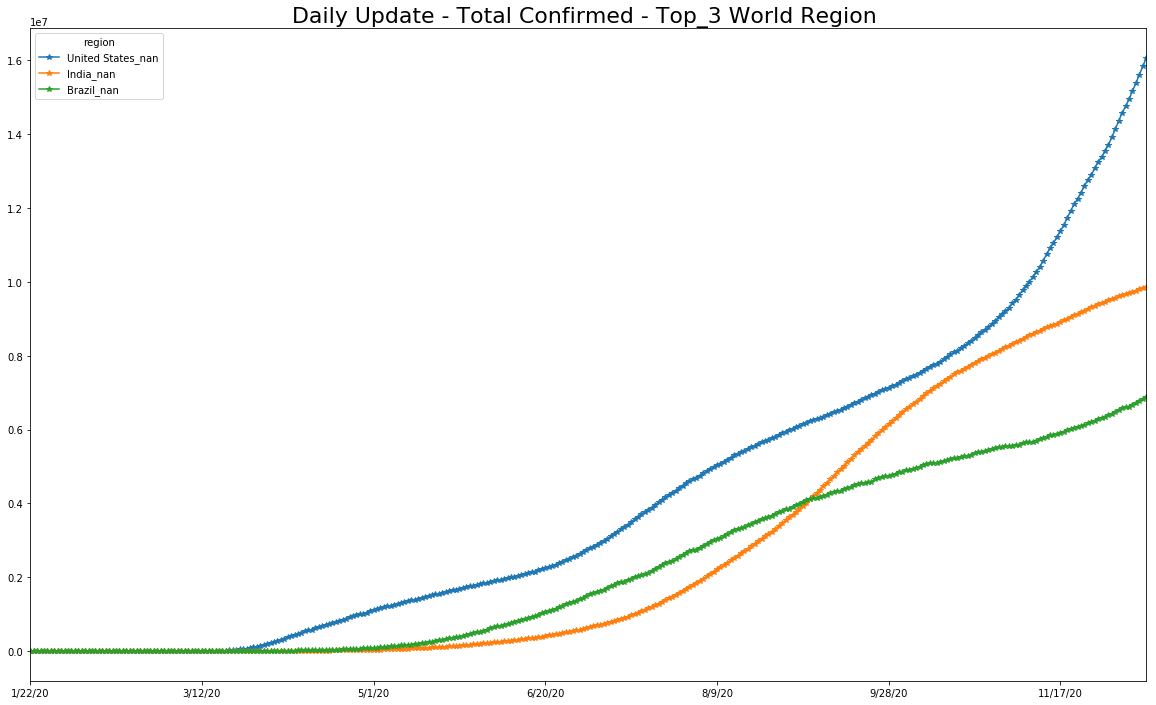

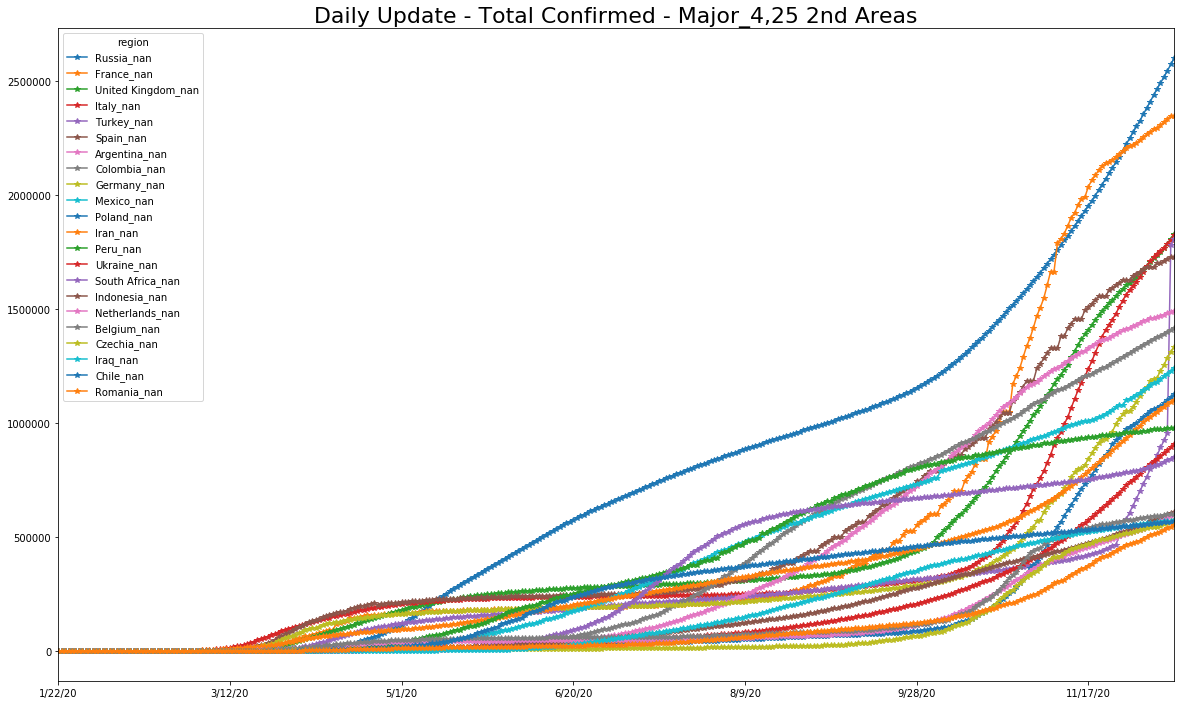

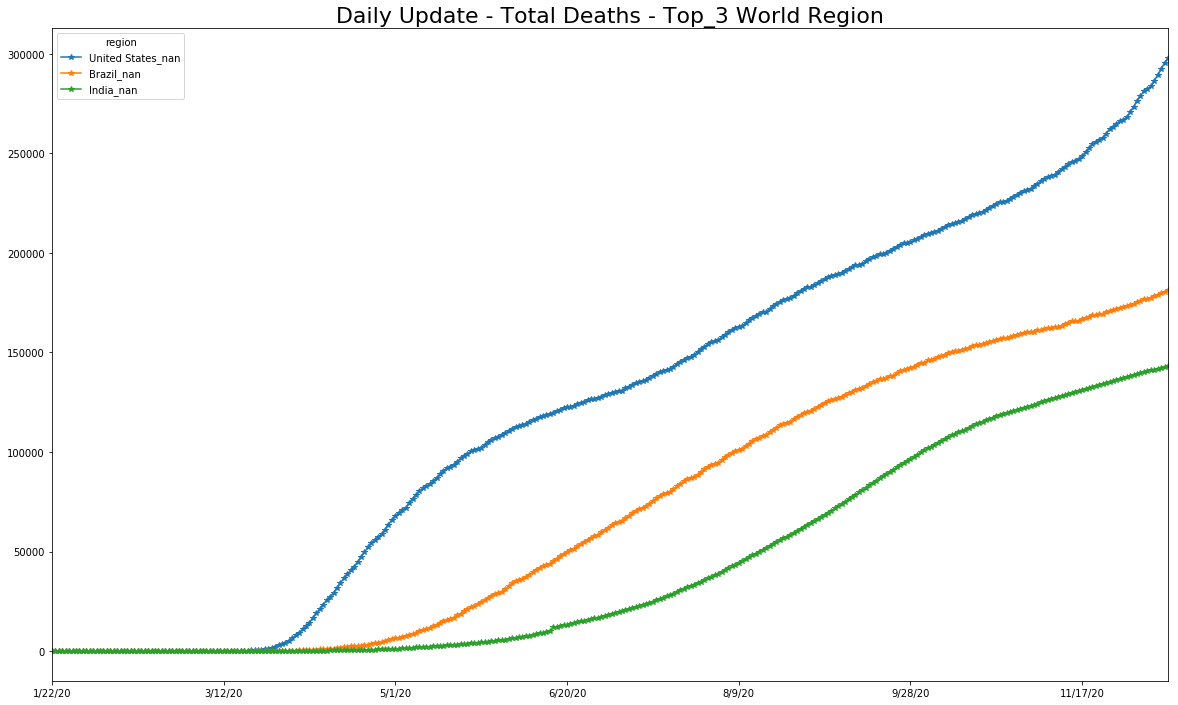

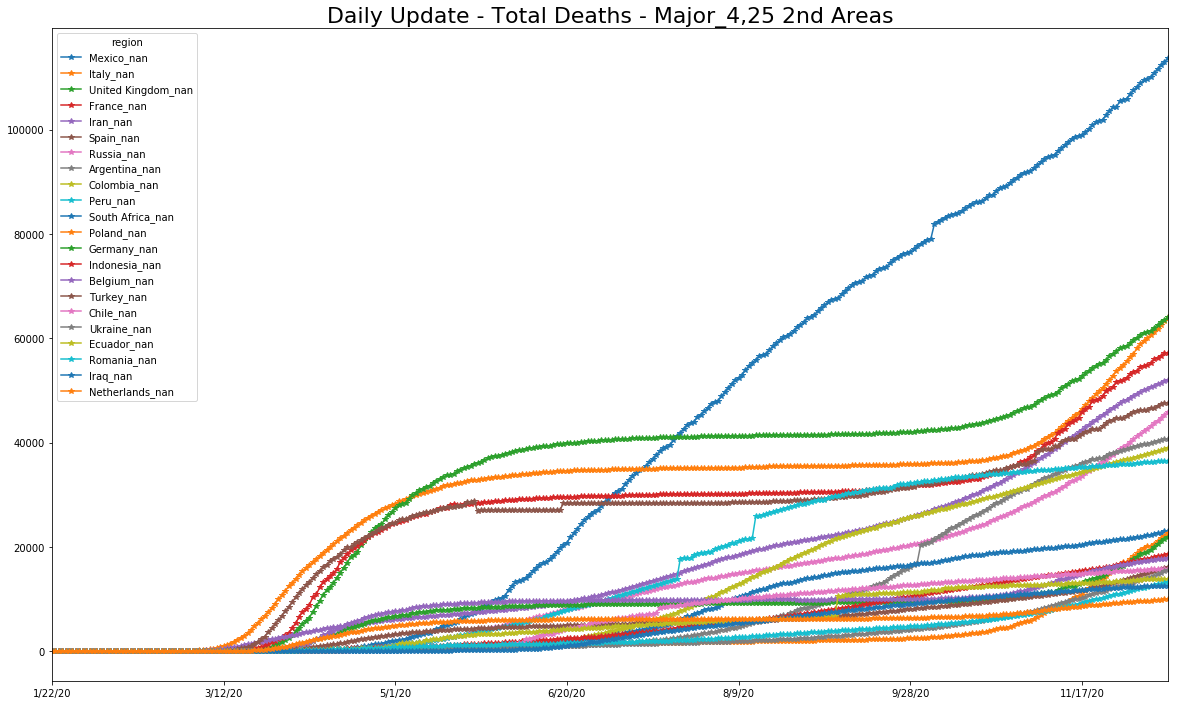

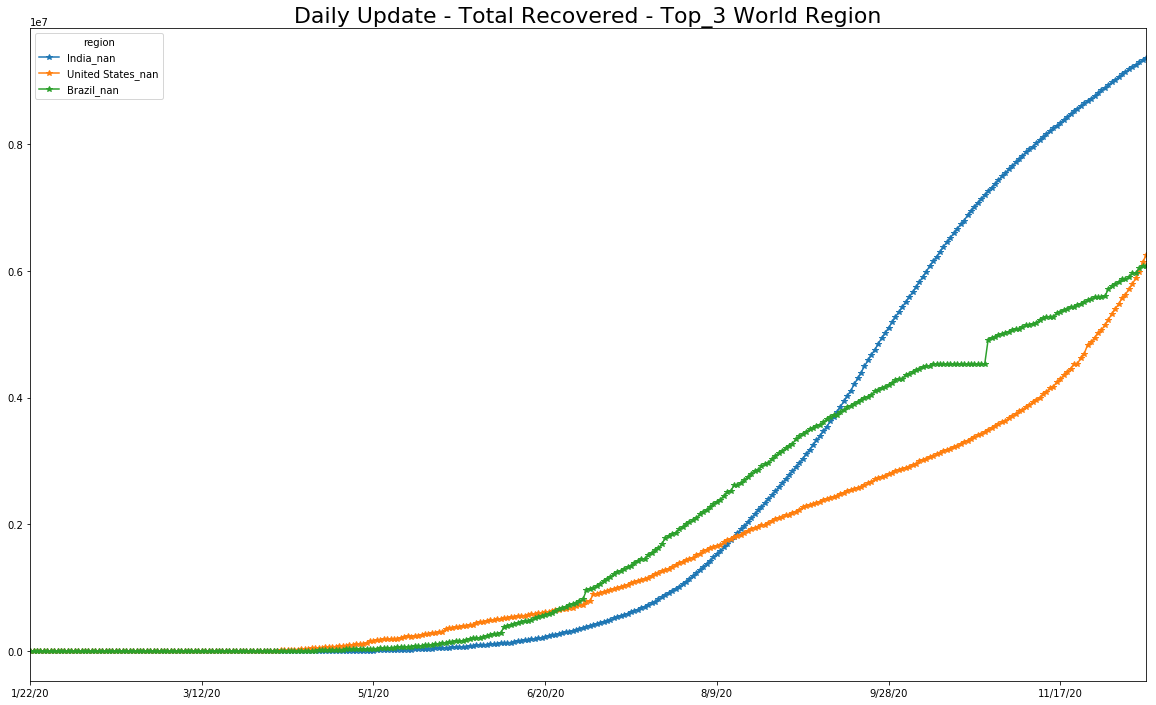

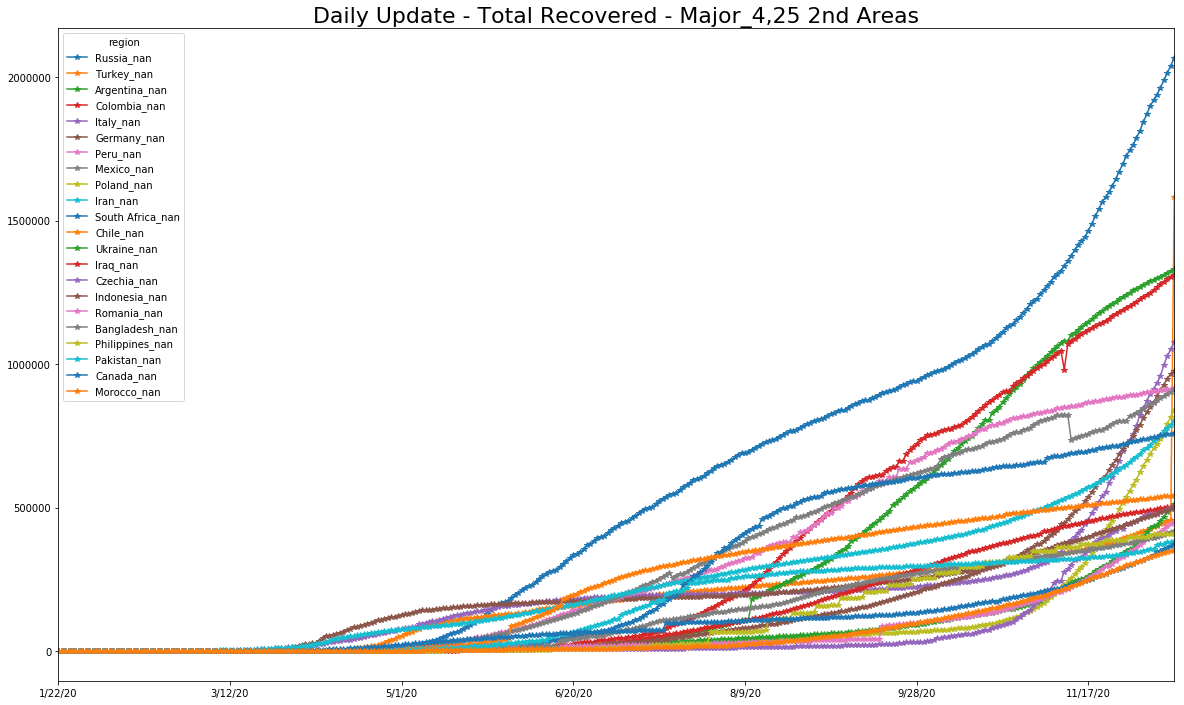

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/12/13


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

date                     region   min   max
0   2020/12/14  Australia_New South Wales  16.7  23.6
1   2020/12/14                Austria_nan  -3.5  -2.7
2   2020/12/14                Belgium_nan   7.4   8.4
3   2020/12/14                 Brazil_nan  19.4  20.0
4   2020/12/14             Canada_Ontario -12.1 -12.0
5   2020/12/14              Canada_Quebec -19.0 -17.0
6   2020/12/14                  Chile_nan  15.0  17.0
7   2020/12/14              China_Beijing  -7.0   0.0
8   2020/12/14            China_Guangdong  17.0  21.0
9   2020/12/14            China_Hong Kong  19.4  22.8
10  2020/12/14                China_Hubei   4.0  18.3
11  2020/12/14                China_Macau  20.0  21.0
12  2020/12/14             China_Shanghai   5.9  16.4
13  2020/12/14                Finland_nan  -3.0  -1.0
14  2020/12/14                 France_nan   2.9   3.9
15  2020/12/14                Germany_nan   2.0   4.0
16  2020/12/14                  India_nan  19.0  25.0
17  2020/12/14                   Iran_nan   3.0   7.0
18  2020/12/14                  Italy_nan   5.1   7.6
19  2020/12/14                  Japan_nan  -1.7   6.7
20  2020/12/14           Korea, South_nan  -6.0   9.0
21  2020/12/14               Malaysia_nan  23.0  29.0
22  2020/12/14                 Mexico_nan  10.8  10.8
23  2020/12/14            Netherlands_nan   9.4  10.0
24  2020/12/14                 Norway_nan  -3.9  -3.3
25  2020/12/14                   Peru_nan  21.9  22.1
26  2020/12/14            Philippines_nan  25.0  30.0
27  2020/12/14                 Poland_nan   1.7   2.2
28  2020/12/14               Portugal_nan  14.0  15.3
29  2020/12/14                 Russia_nan -29.0 -25.0
30  2020/12/14              Singapore_nan  24.0  30.5
31  2020/12/14                  Spain_nan   5.1   7.3
32  2020/12/14                 Sweden_nan   3.9   4.4
33  2020/12/14            Switzerland_nan   1.7   2.5
34  2020/12/14                 Turkey_nan   4.6   7.6
35  2020/12/14          United States_nan  -6.1  -6.1
36  2020/12/14         United Kingdom_nan   2.2   5.0

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34984         3752        20770          862         576   
7/16/20            35060         3851        21355          877         607   
7/17/20            35219         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
7/15/20  ...            3490931         1009           14581            0   
7/16/20  ...            3568033         1026           15066            0   
7/17/20  ...            3639705         1037           15607            0   

region   Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
7/15/20          10428          381                    7064       1526   
7/16/20          10854          381                    7412       1552   
7/17/20          11191          382                    7764       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 271 columns]

In [24]:
ts[-4:]

region    Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
12/9/20             47851        45188        90014         7162       15804   
12/10/20            48053        46061        90579         7190       15925   
12/11/20            48116        46863        91121         7236       16061   
12/12/20            48229        47742        91638         7288       16161   

region    Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
12/9/20                       146        1475222       144066   
12/10/20                      146        1482216       145240   
12/11/20                      147        1489328       146317   
12/12/20                      148        1494602       147312   

region    Australia_Australian Capital Territory  Australia_New South Wales  \
12/9/20                                      117                       4624   
12/10/20                                     117                       4633   
12/11/20                                     117                       4639   
12/12/20                                     117                       4642   

region    ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Vanuatu_nan  \
12/9/20   ...           15386562         8104           74352            1   
12/10/20  ...           15611014         8487           74498            1   
12/11/20  ...           15842789         8849           74811            1   
12/12/20  ...           16062299         9180           74811            1   

region    Venezuela_nan  Vietnam_nan  West Bank and Gaza_nan  Yemen_nan  \
12/9/20          105852         1381                  102992       2079   
12/10/20         106280         1385                  104879       2081   
12/11/20         106715         1391                  106622       2082   
12/12/20         107177         1395                  108099       2083   

region    Zambia_nan  Zimbabwe_nan  
12/9/20        18062         11007  
12/10/20       18091         11081  
12/11/20       18161         11162  
12/12/20       18217         11219  

[4 rows x 271 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
8342 2020-05-10  Vietnam_nan  26.9  33.0
8343 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35060             0             0   
2     2020-07-17  Afghanistan_nan      35219            76             0   
3     2020-07-18  Afghanistan_nan      35279           159             0   
4     2020-07-19  Afghanistan_nan      35453            60           295   
5     2020-07-20  Afghanistan_nan      35493           174           393   
6     2020-07-21  Afghanistan_nan      35605            40           274   
7     2020-07-22  Afghanistan_nan      35717           112           326   
8     2020-07-23  Afghanistan_nan      35918           112           264   
9     2020-07-24  Afghanistan_nan      35978           201           425   
10    2020-07-25  Afghanistan_nan      36026            60           373   
11    2020-07-26  Afghanistan_nan      36147            48           309   
12    2020-07-27  Afghanistan_nan      36253           121           229   
13    2020-07-28  Afghanistan_nan      36358           106           275   
14    2020-07-29  Afghanistan_nan      36463           105           332   
15    2020-07-30  Afghanistan_nan      36532           105           316   
16    2020-07-31  Afghanistan_nan      36665            69           279   
17    2020-08-01  Afghanistan_nan      36700           133           307   
18    2020-08-02  Afghanistan_nan      36701            35           237   
19    2020-08-03  Afghanistan_nan      36737             1           169   
20    2020-08-04  Afghanistan_nan      36773            36            72   
21    2020-08-05  Afghanistan_nan      36820            36            73   
22    2020-08-06  Afghanistan_nan      36928            47           119   
23    2020-08-07  Afghanistan_nan      37006           108           191   
24    2020-08-08  Afghanistan_nan      37046            78           233   
25    2020-08-09  Afghanistan_nan      37083            40           226   
26    2020-08-10  Afghanistan_nan      37153            37           155   
27    2020-08-11  Afghanistan_nan      37260            70           147   
28    2020-08-12  Afghanistan_nan      37336           107           214   
29    2020-08-13  Afghanistan_nan      37422            76           253   
30    2020-08-14  Afghanistan_nan      37497            86           269   
...          ...              ...        ...           ...           ...   
42074 2020-11-14     Zimbabwe_nan       8786            69           155   
42075 2020-11-15     Zimbabwe_nan       8829            21           119   
42076 2020-11-16     Zimbabwe_nan       8897            43           133   
42077 2020-11-17     Zimbabwe_nan       8945            68           132   
42078 2020-11-18     Zimbabwe_nan       8981            48           159   
42079 2020-11-19     Zimbabwe_nan       9046            36           152   
42080 2020-11-20     Zimbabwe_nan       9120            65           149   
42081 2020-11-21     Zimbabwe_nan       9172            74           175   
42082 2020-11-22     Zimbabwe_nan       9220            52           191   
42083 2020-11-23     Zimbabwe_nan       9308            48           174   
42084 2020-11-24     Zimbabwe_nan       9398            88           188   
42085 2020-11-25     Zimbabwe_nan       9508            90           226   
42086 2020-11-26     Zimbabwe_nan       9623           110           288   
42087 2020-11-27     Zimbabwe_nan       9714           115           315   
42088 2020-11-28     Zimbabwe_nan       9822            91           316   
42089 2020-11-29     Zimbabwe_nan       9822           108           314   
42090 2020-11-30     Zimbabwe_nan       9950             0           199   
42091 2020-12-01     Zimbabwe_nan      10129           128           236   
42092 2020-12-02     Zimbabwe_nan      10129           179           307   
42093 2020-12-03     Zimbabwe_nan      10424             0           307   
42094 2020-12-04     Zimbabwe_nan      10547           295  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
42103 2020-12-13  Zimbabwe_nan          0            57           212   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
42103           602         100.510751         101.926138         105.670246   

       last_day  kalman_prediction  population  infected_rate  min  max  
42103     11219            11331.0    14862924       0.000008  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
42103 2020-12-13  Zimbabwe_nan          0            57           212   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
42103           602         100.510751         101.926138         105.670246   

       last_day  kalman_prediction  population  infected_rate  min  max  
42103     11219            11331.0    14862924       0.000008  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
41189  2020-12-11  Zimbabwe_nan      11162            74           242   
41190  2020-12-12  Zimbabwe_nan      11219            81           250   
41191  2020-12-13  Zimbabwe_nan          0            57           212   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
41189           657         100.672390         102.232771         106.302859   
41190           615         100.731071         102.291147         105.831137   
41191           602         100.510751         101.926138         105.670246   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
41189                11081  ...    14862924       0.000007  NaN  NaN   
41190                11162  ...    14862924       0.000008  NaN  NaN   
41191                11219  ...    14862924       0.000008  NaN  NaN   

       population_percentage : infected_rate confirmed  \
41189                                         0.000746   
41190                                         0.000751   
41191                                         0.000755   

       population_percentage : factor 9/10 infected_rate confirmed  \
41189                                           0.007456             
41190                                           0.007511             
41191                                           0.007549             

       delta : new_cases  delta : new_cases per 1M hab  \
41189              128.0                      8.612034   
41190              115.0                      7.737374   
41191              112.0                      7.535529   

       delta : roling 7day AVG  \
41189                93.857143   
41190                87.857143   
41191                86.000000   

       delta : aprox 14-day case notification rate per 100k hab  
41189                                           8.840791         
41190                                           8.275626         
41191                                           8.100694         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
261  United States_nan  1.755428e+12  1.324926e+06  126873.834437


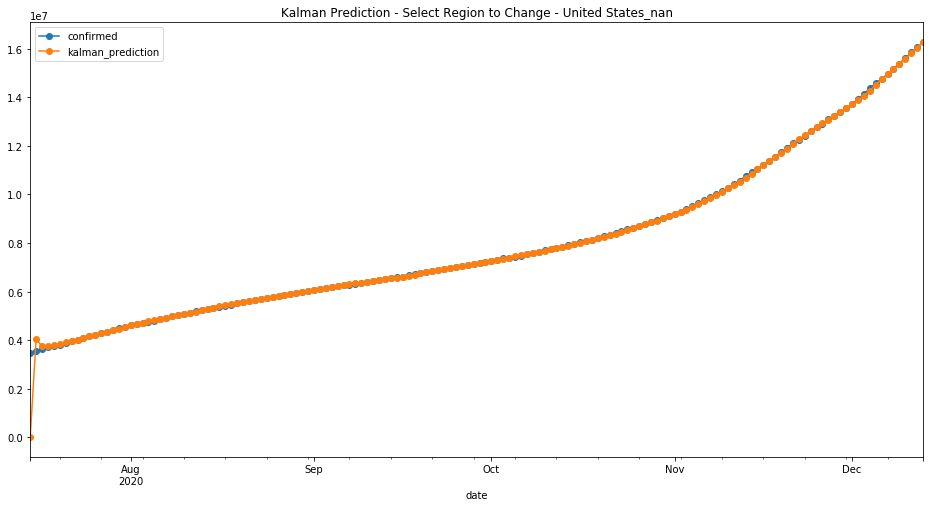

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
211  Russia_nan  4.586182e+10  214153.723172  19673.662252


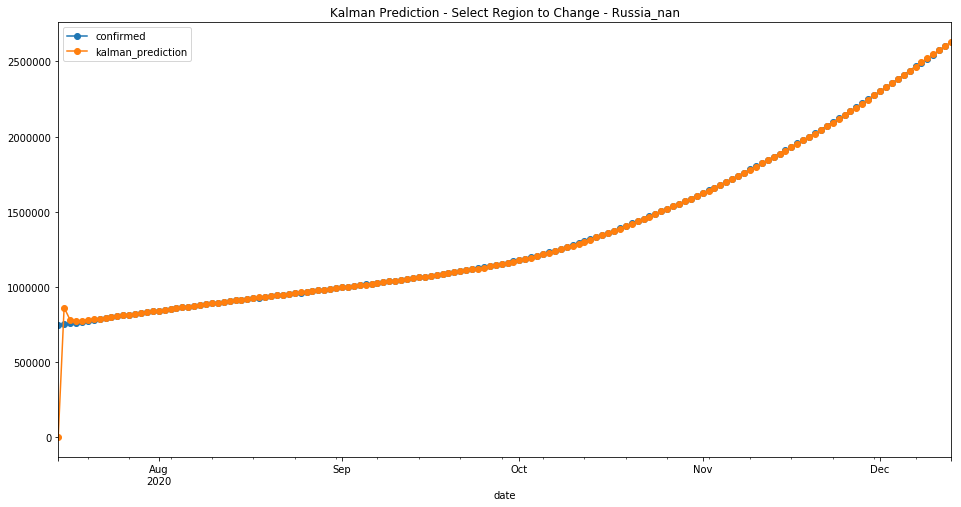

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  3.182162e+11  564106.579963  62826.834437


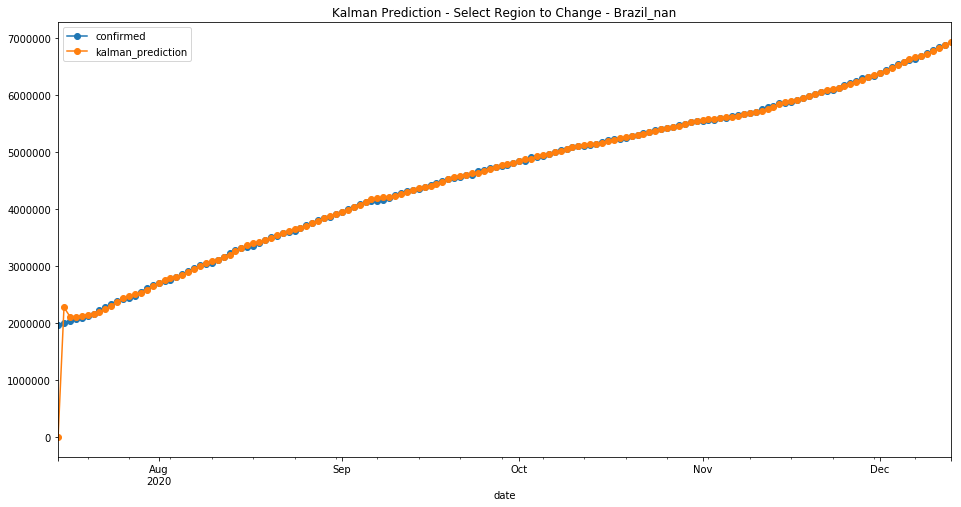

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse          mae
260  United Kingdom_nan  2.257144e+10  150237.958673  14983.07947


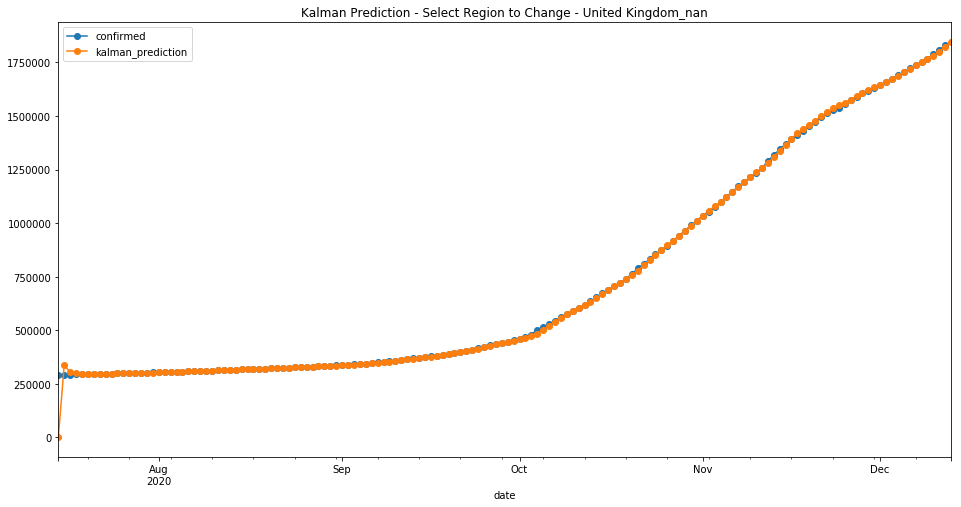

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpaz90x7tm
  JVM stdout: /tmp/tmpaz90x7tm/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpaz90x7tm/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    2 months and 14 days
H2O_cluster_name:           H2O_from_python_unknownUser_ubw3hh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-12-05
last_train_date= 2020-12-12
first_bootstrap_date= 2020-12-04
boost_bootstrap_date= 2020-12-09
first_test_date= 2020-12-03
last_test_date= 2020-12-13
first_valid_date= 2020-12-11


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   47077.0      46837 2020-12-04  Afghanistan_nan
1   47107.0      47072 2020-12-05  Afghanistan_nan
2   47273.0      47306 2020-12-06  Afghanistan_nan
3   47470.0      47516 2020-12-07  Afghanistan_nan
4   47686.0      47716 2020-12-08  Afghanistan_nan
5   47898.0      47851 2020-12-09  Afghanistan_nan
6   48061.0      48053 2020-12-10  Afghanistan_nan
7   48259.0      48116 2020-12-11  Afghanistan_nan
8   48355.0      48229 2020-12-12  Afghanistan_nan
9   48454.0          0 2020-12-13  Afghanistan_nan
10  41321.0      41302 2020-12-04      Albania_nan
11  42139.0      42148 2020-12-05      Albania_nan
12  43010.0      42988 2020-12-06      Albania_nan
13  43883.0      43683 2020-12-07      Albania_nan
14  44657.0      44436 2020-12-08      Albania_nan
15  45421.0      45188 2020-12-09      Albania_nan
16  46173.0      46061 2020-12-10      Albania_nan
17  47012.0      46863 2020-12-11      Albania_nan
18  47826.0      47742 2020-12-12      Albania_nan
19  48701.0          0 2020-12-13      Albania_nan
20  87115.0      86730 2020-12-04      Algeria_nan
21  87887.0      87502 2020-12-05      Algeria_nan
22  88612.0      88252 2020-12-06      Algeria_nan
23  89307.0      88825 2020-12-07      Algeria_nan
24  89843.0      89416 2020-12-08      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  159249.0     158555 2020-12-09  Azerbaijan_nan
176  163500.0     162774 2020-12-10  Azerbaijan_nan
177  167720.0     167155 2020-12-11  Azerbaijan_nan
178  172125.0     171423 2020-12-12  Azerbaijan_nan
179  176442.0          0 2020-12-13  Azerbaijan_nan
180    7645.0       7565 2020-12-04     Bahamas_nan
181    7646.0       7570 2020-12-05     Bahamas_nan
182    7665.0       7570 2020-12-06     Bahamas_nan
183    7671.0       7579 2020-12-07     Bahamas_nan
184    7665.0       7579 2020-12-08     Bahamas_nan
185    7675.0       7585 2020-12-09     Bahamas_nan
186    7673.0       7585 2020-12-10     Bahamas_nan
187    7679.0       7623 2020-12-11     Bahamas_nan
188    7667.0       7648 2020-12-12     Bahamas_nan
189    7713.0          0 2020-12-13     Bahamas_nan
190   87718.0      87600 2020-12-04     Bahrain_nan
191   87883.0      87732 2020-12-05     Bahrain_nan
192   88022.0      87930 2020-12-06     Bahrain_nan
193   88213.0      88111 2020-12-07     Bahrain_nan
194   88393.0      88294 2020-12-08     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220  143498.0     143383 2020-12-04  Belarus_nan
221  145278.0     145279 2020-12-05  Belarus_nan
222  147180.0     147157 2020-12-06  Belarus_nan
223  149093.0     148953 2020-12-07  Belarus_nan
224  150953.0     150602 2020-12-08  Belarus_nan
225  152670.0     152453 2020-12-09  Belarus_nan
226  154532.0     154392 2020-12-10  Belarus_nan
227  156456.0     156359 2020-12-11  Belarus_nan
228  158430.0     158334 2020-12-12  Belarus_nan
229  160433.0          0 2020-12-13  Belarus_nan
230  586710.0     587439 2020-12-04  Belgium_nan
231  589636.0     589942 2020-12-05  Belgium_nan
232  592180.0     591756 2020-12-06  Belgium_nan
233  594376.0     592615 2020-12-07  Belgium_nan
234  594927.0     594572 2020-12-08  Belgium_nan
235  596673.0     597643 2020-12-09  Belgium_nan
236  599526.0     600397 2020-12-10  Belgium_nan
237  601938.0     600397 2020-12-11  Belgium_nan
238  602116.0     603159 2020-12-12  Belgium_nan
239  604674.0          0 2020-12-13  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2193003753.815277
# MSE on the validation data =  3809571681802.7617
# R^2 on the training data =  0.9994367803330602
# R^2 on the validation data =  0.4401248791734369


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1607839395775_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           19821485.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       21.0       23.0      22.976      2857.0      3221.0     3101.022



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2193003753.815277
RMSE: 46829.51797547437
MAE: 4960.951259823863
RMSLE: 0.2146787097279315
Mean Residual Deviance: 2193003753.815277

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 3809571681802.7617
RMSE: 1951812.4094806758
MAE: 507010.3945791936
RMSLE: 7.24795430645095
Mean Residual Deviance: 3809571681802.7617

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-12-13 06:03:25   0.106 sec              0.0            NaN   
1     2020-12-13 06:03:25   0.609 sec              1.0   59763.475606   
2     2020-12-13 06:03:26   0.832 sec              2.0   80761.926473   
3     2020-12-13 06:03:26   1.330 sec              3.0   64221.799201   
4     2020-12-13 06:03:26   1.499 sec              4.0   73048.995736   
5     2020-12-13 06:03:26   1.671 sec              5.0   79047.489227   
6     2020-12-13 06:03:27   1.776 sec              6.0   98513.325238   
7     2020-12-13 06:03:27   1.870 sec              7.0   95051.921860   
8     2020-12-13 06:03:27   1.944 sec              8.0   94169.711481   
9     2020-12-13 06:03:27   2.052 sec              9.0   73928.196666   
10    2020-12-13 06:03:27   2.124 sec             10.0   67367.375382   
11    2020-12-13 06:03:27   2.193 sec             11.0   64336.799825   
12    2020-12-13 06:03:27   2.297 sec             12.0   68677.358728   
13    2020-12-13 06:03:27   2.393 sec             13.0   68860.441225   
14    2020-12-13 06:03:27   2.486 sec             14.0   67391.500342   
15    2020-12-13 06:03:27   2.571 sec             15.0   65140.043208   
16    2020-12-13 06:03:27   2.650 sec             16.0   64323.997925   
17    2020-12-13 06:03:28   2.758 sec             17.0   60693.945049   
18    2020-12-13 06:03:28   2.879 sec             18.0   56583.333598   
19    2020-12-13 06:03:28   2.957 sec             19.0   59283.693484   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   11834.489409       3.571673e+09     1.961627e+06   502042.409169   
2   13303.579031       6.522489e+09     2.048203e+06   540087.846740   
3   12476.977407       4.124439e+09     2.016741e+06   527352.955424   
4   12641.357864       5.336156e+09     2.001955e+06   519526.960497   
5   12771.651657       6.248506e+09     2.021566e+06   544348.485860   
6   14358.927159       9.704875e+09     1.995422e+06   534107.649377   
7   13857.588731       9.034868e+09     1.988770e+06   529183.032397   
8   13651.166893       8.867935e+09     1.983861e+06   523194.787726   
9   12202.604270       5.465378e+09     1.980764e+06   520054.521196   
10  11799.411461       4.538363e+09     1.975614e+06   516522.879122   
11  11598.858063       4.139224e+09     1.957160e+06   530525.217743   
12  11380.820253       4.716580e+09     1.957021e+06   527724.396843   
13  11242.507037       4.741760e+09     1.956575e+06   528780.603255   
14  10916.680973       4.541614e+09     1.953636e+06   526162.428940   
15  10468.470023       4.243225e+09     1.952466e+06   523766.610386   
16  10202.371010       4.137577e+09     1.952290e+06   521935.966553   
17   9721.556746       3.683755e+09     1.952355e+06   520260.791143   
18   9644.971189       3.201674e+09     1.952347e+06   519861.972673   
19   9575.658648       3.514556e+09     1.953345e+06   518955.953933   

    validation_deviance  
0                   NaN  
1          3.847981e+12  
2          4.195136e+12  
3          4.067243e+12  
4          4.007824e+12  
5          4.086728e+12  
6          3.981709e+12  
7          3.955207e+12  
8          3.935703e+12  
9          3.923426e+12  
10         3.903052e+12  
11         3.830475e+12  
12         3.829933e+12  
13         3.828185e+12  
14         3.816693e+12  
15         3.812123e+12  
16         3.811438e+12  
17         3.811690e+12  
18         3.811661e+12  
19         3.815557e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0            last_day         3.618247e+18           1.000000    0.340890
1   kalman_prediction         2.903995e+18           0.802597    0.273597
2              region         1.509182e+18           0.417103    0.142186
3        7_day_change         1.130353e+18           0.312403    0.106495
4        3_day_change         7.818976e+17           0.216098    0.073666
5        1_day_change         3.865658e+17           0.106838    0.036420
6       infected_rate         1.341670e+17           0.037081    0.012640
7   7_day_change_rate         5.283191e+16           0.014602    0.004978
8   3_day_change_rate         4.259418e+16           0.011772    0.004013
9   1_day_change_rate         3.309088e+16           0.009146    0.003118
10                max         1.284800e+16           0.003551    0.001210
11                min         8.347800e+15           0.002307    0.000786

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0            last_day         3.618247e+18           1.000000    0.340890
1   kalman_prediction         2.903995e+18           0.802597    0.273597
2              region         1.509182e+18           0.417103    0.142186
3        7_day_change         1.130353e+18           0.312403    0.106495
4        3_day_change         7.818976e+17           0.216098    0.073666
5        1_day_change         3.865658e+17           0.106838    0.036420
6       infected_rate         1.341670e+17           0.037081    0.012640
7   7_day_change_rate         5.283191e+16           0.014602    0.004978
8   3_day_change_rate         4.259418e+16           0.011772    0.004013
9   1_day_change_rate         3.309088e+16           0.009146    0.003118
10                max         1.284800e+16           0.003551    0.001210
11                min         8.347800e+15           0.002307    0.000786

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


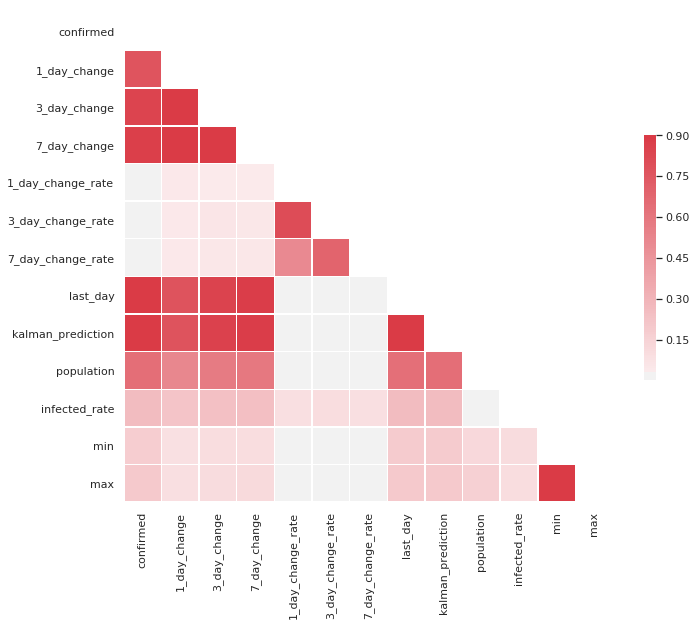

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.767918
3_day_change         0.842653
7_day_change         0.870958
1_day_change_rate    0.028667
3_day_change_rate    0.029207
7_day_change_rate    0.023499
last_day             0.988806
kalman_prediction    0.989248
population           0.637662
infected_rate        0.259959
min                  0.179912
max                  0.199128
Name: confirmed, dtype: float64


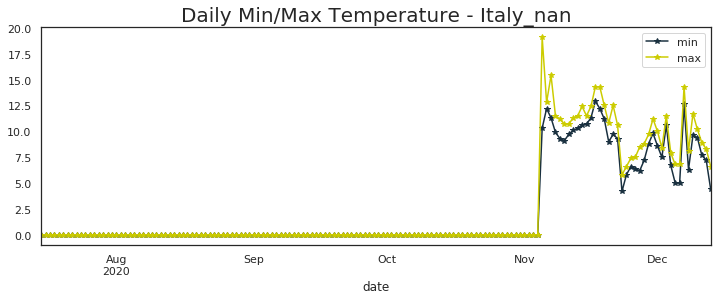

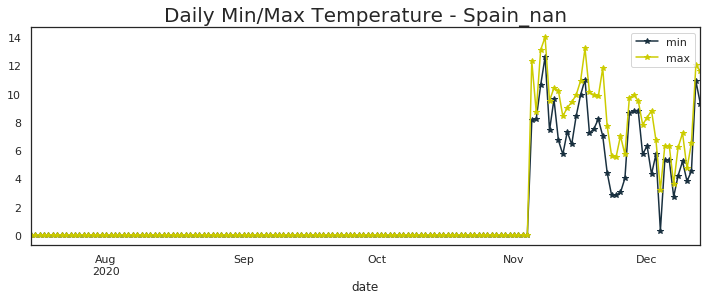

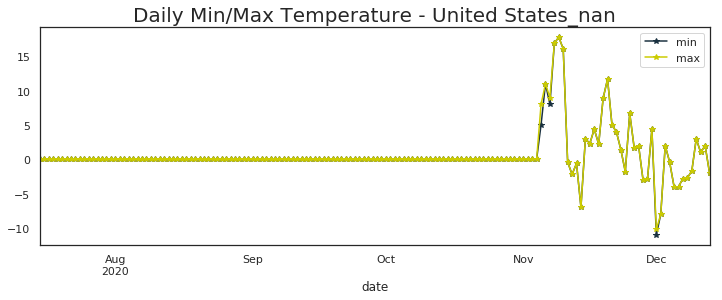

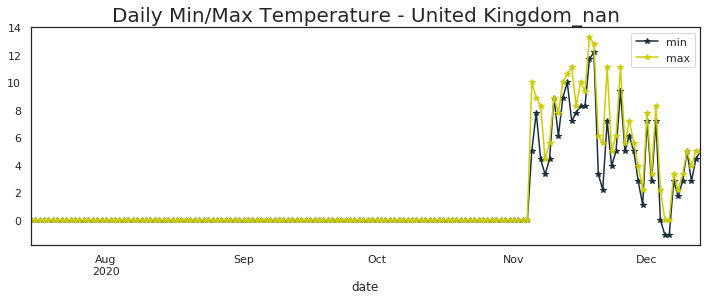

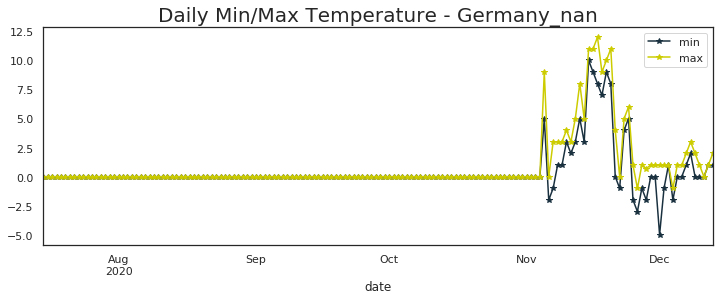

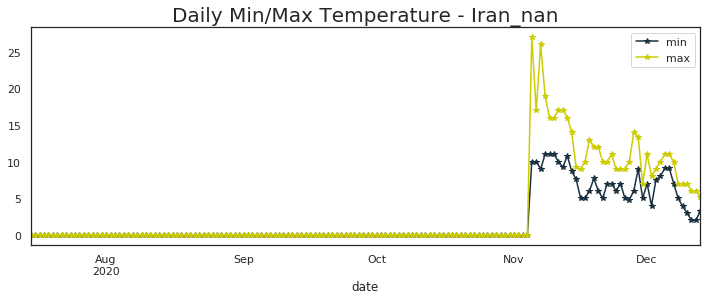

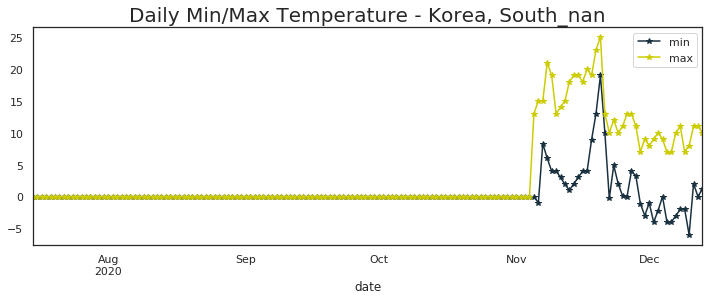

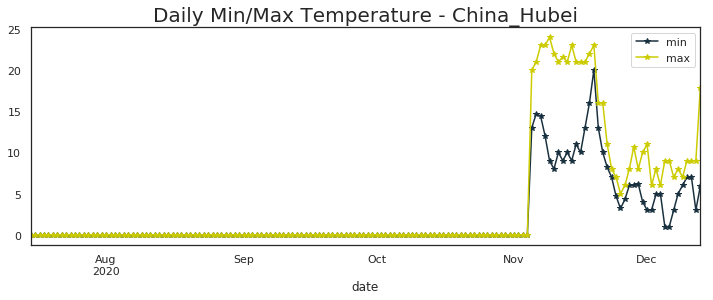

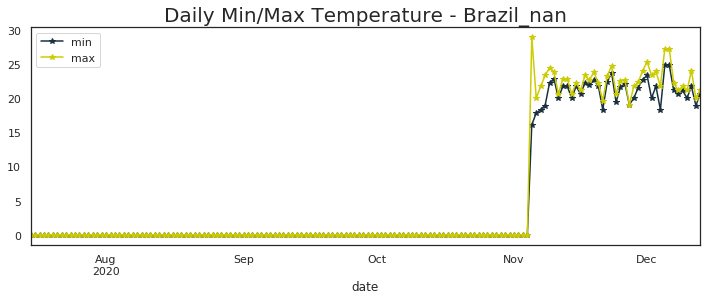

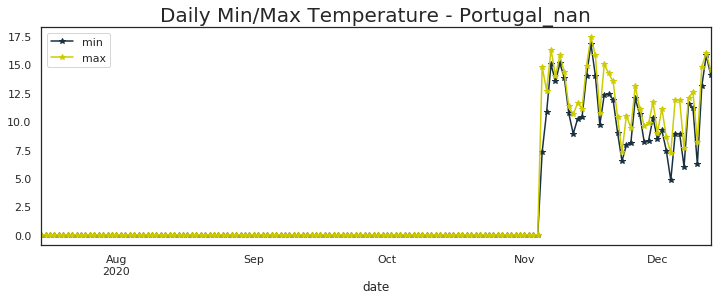

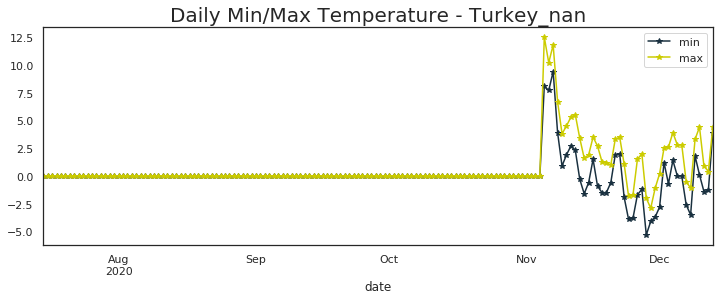

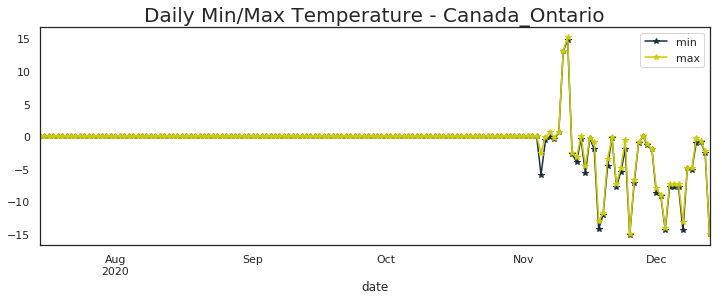

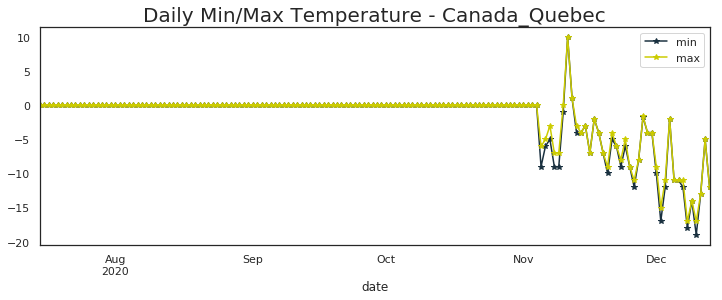

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.8  17.8
India_nan                   22.0  31.0
Brazil_nan                  24.8  28.9
Russia_nan                   0.0   4.0
France_nan                  12.1  13.3
United Kingdom_nan          12.2  13.3
Italy_nan                   12.9  19.1
Turkey_nan                   9.4  12.5
Spain_nan                   12.6  14.0
Argentina_nan                0.0   0.0
Colombia_nan                 0.0   0.0
Germany_nan                 10.0  12.0
Mexico_nan                  15.1  15.1
Poland_nan                   8.9  10.6
Iran_nan                    11.0  27.0
Peru_nan                    24.6  29.9
Ukraine_nan                  0.0   0.0
South Africa_nan             0.0   0.0
Indonesia_nan                0.0   0.0
Netherlands_nan             14.4  16.1
Belgium_nan                 13.7  14.5
Czechia_nan                  0.0   0.0
Iraq_nan                    

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

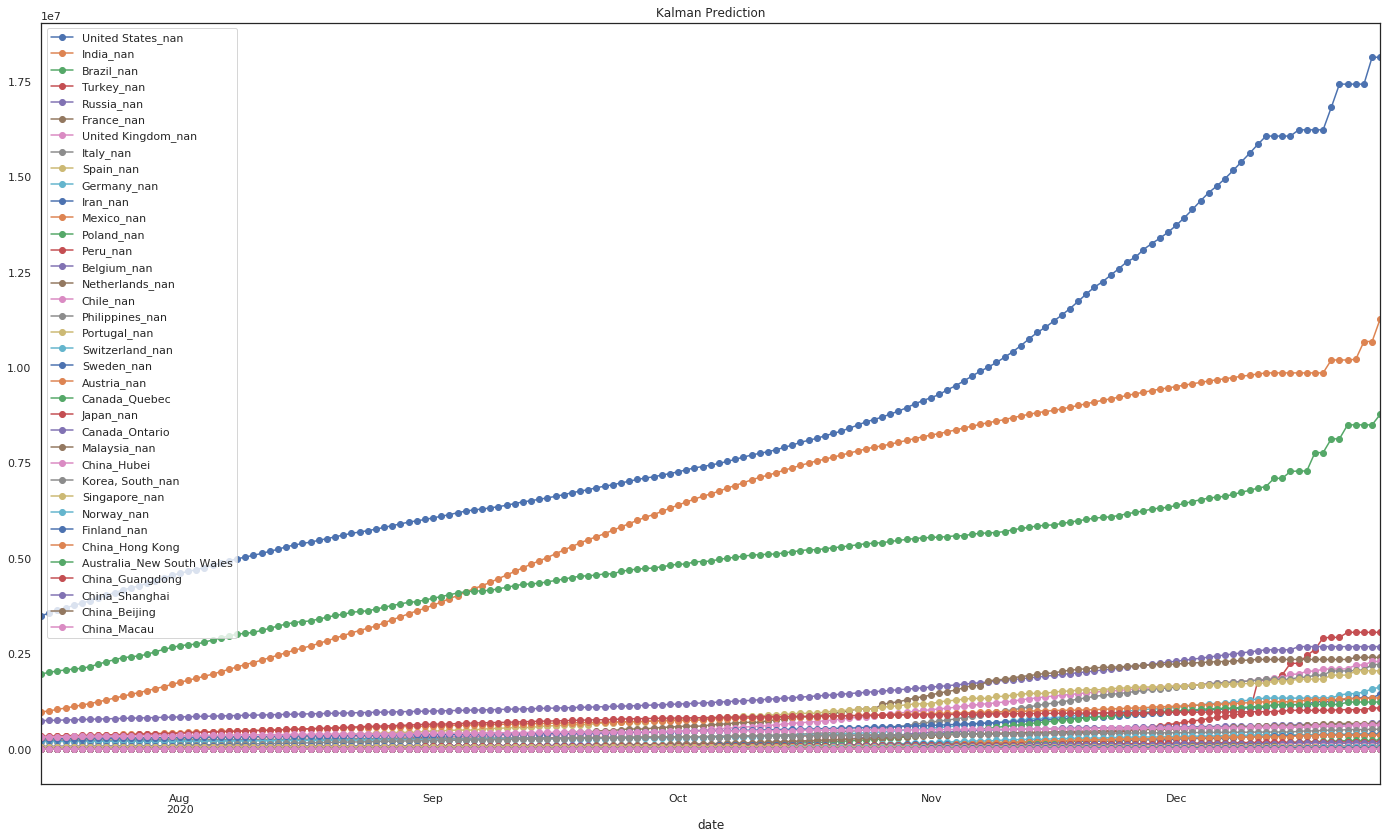

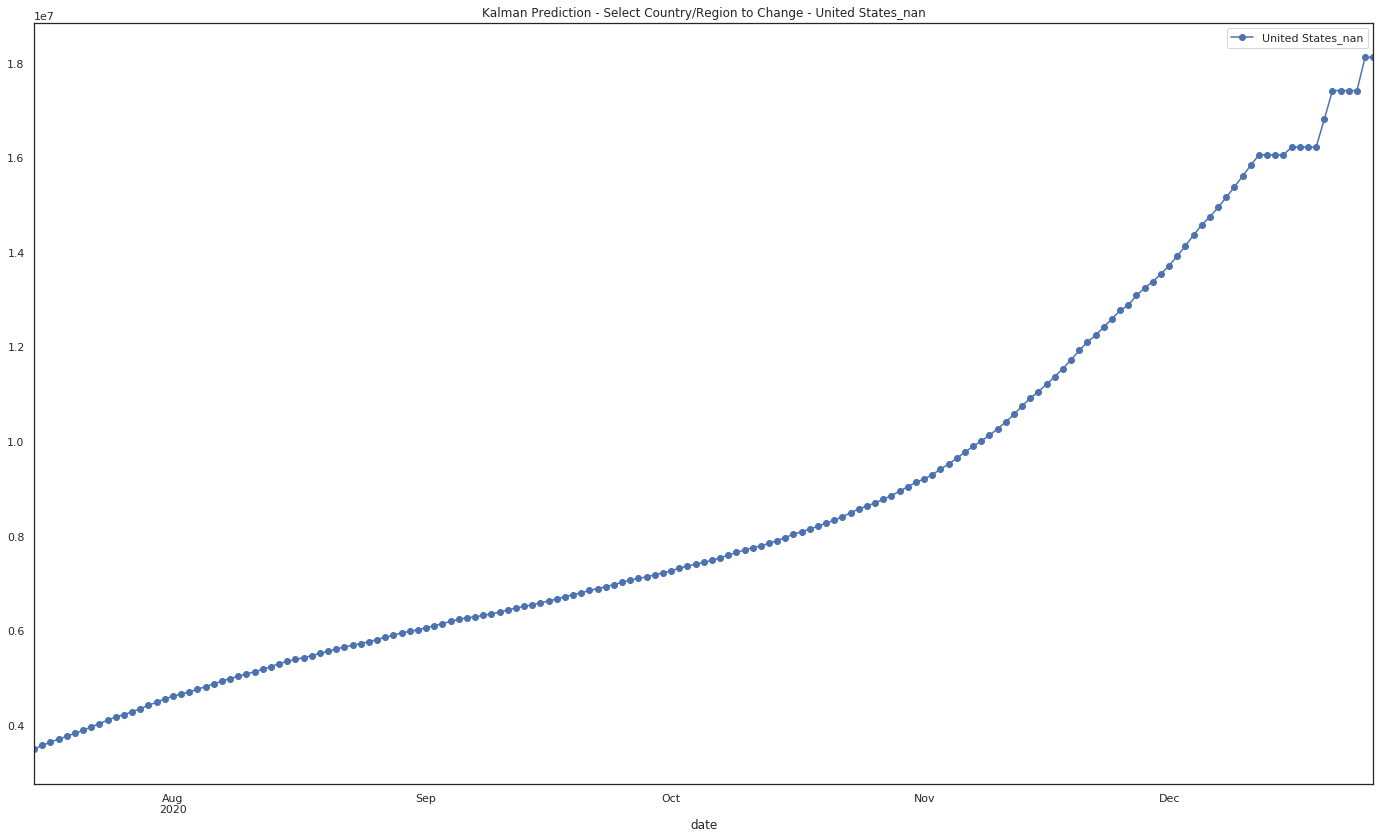

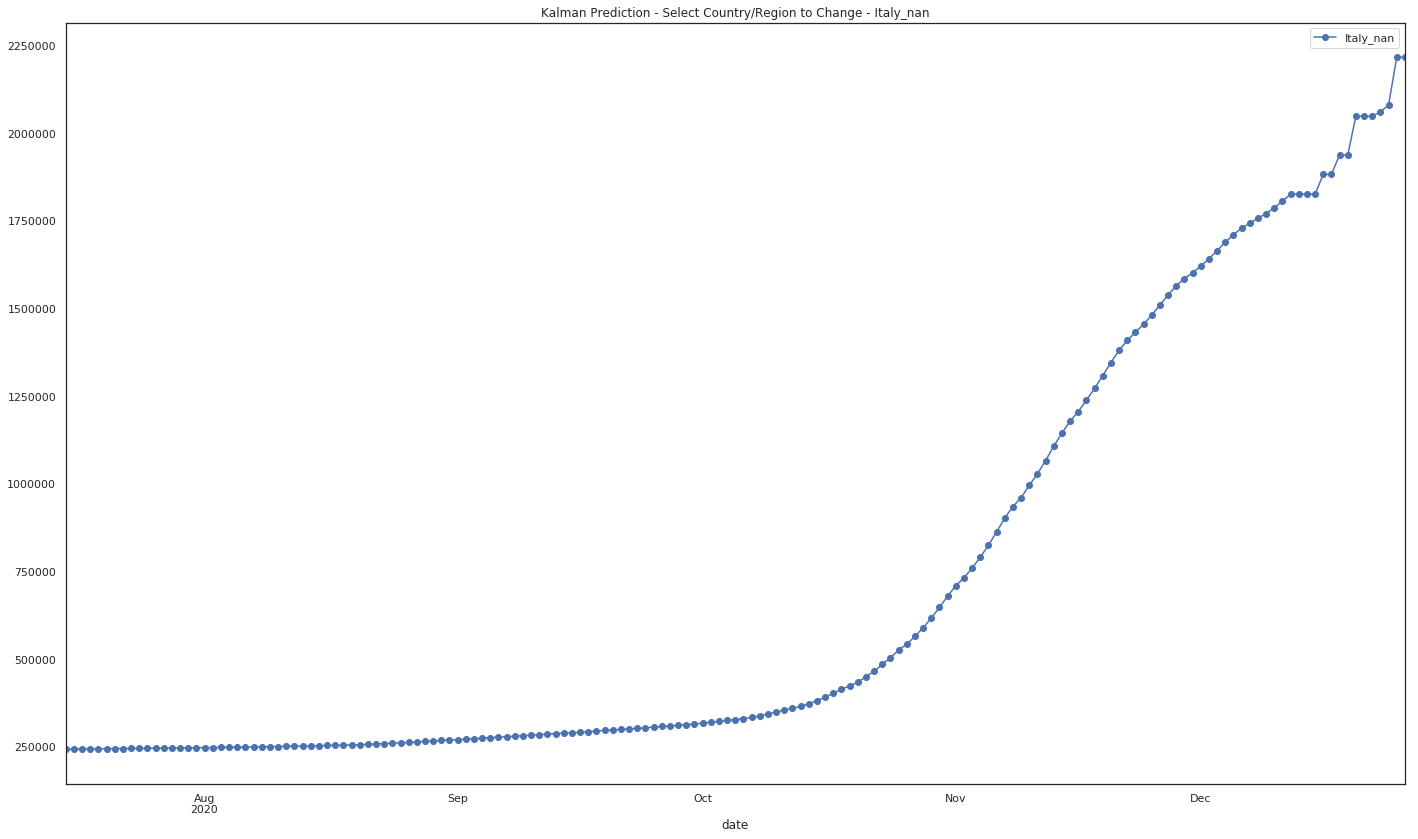

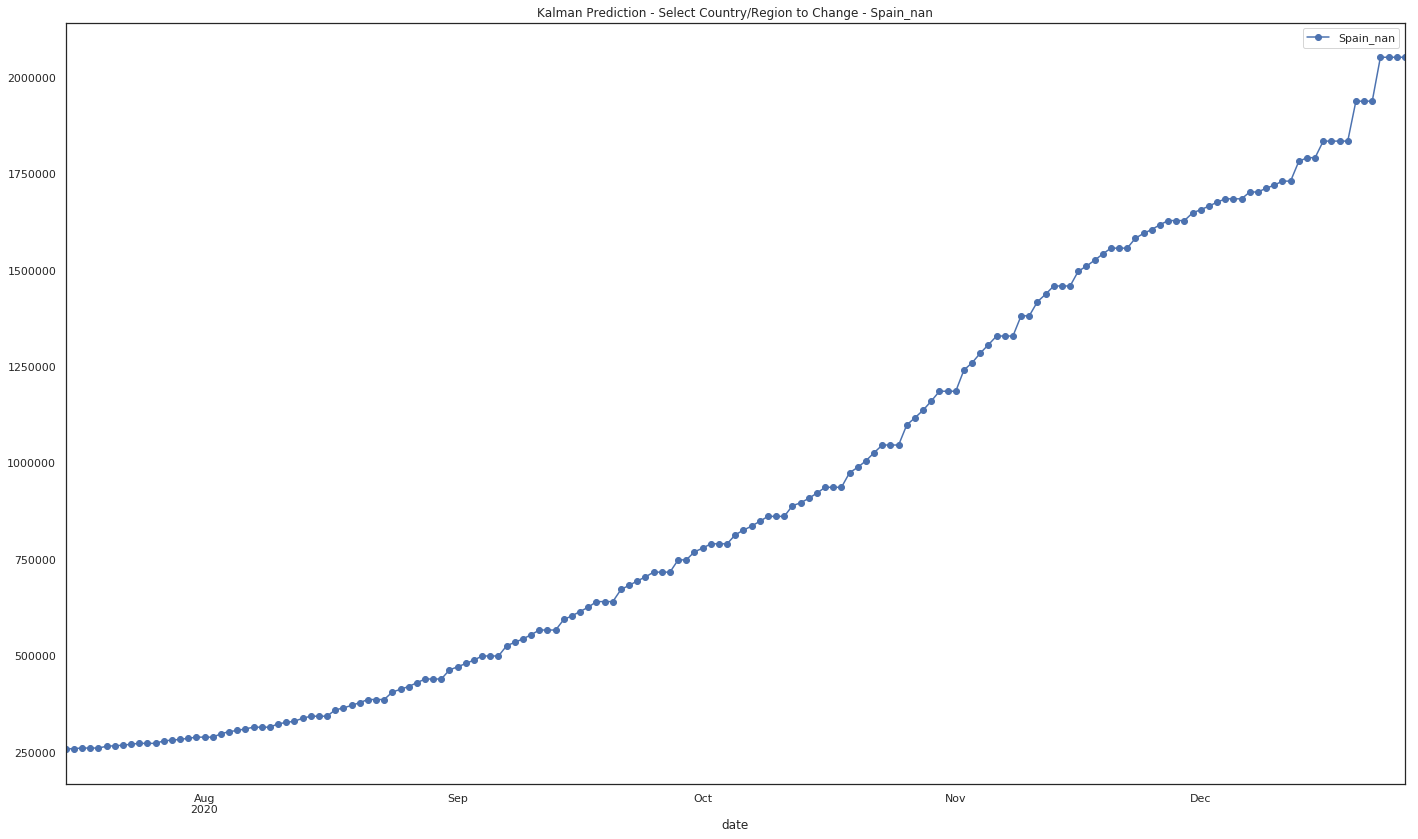

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


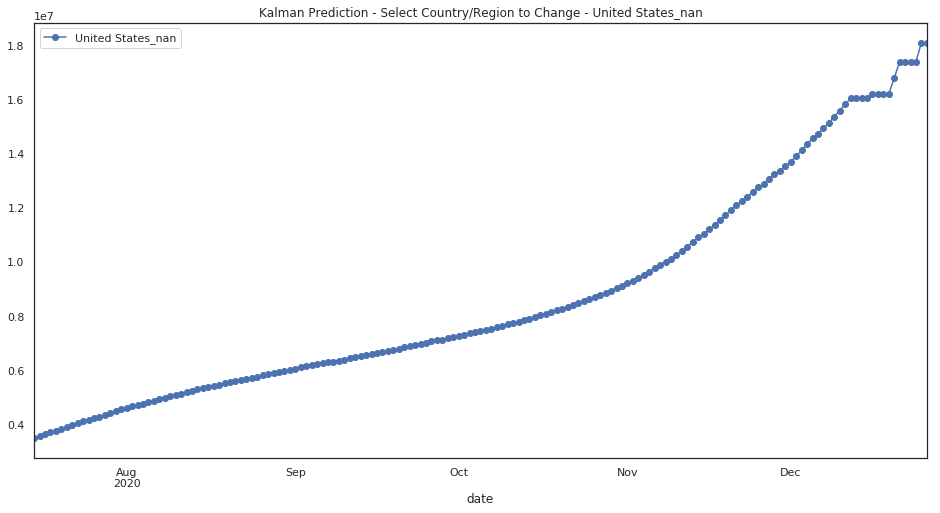

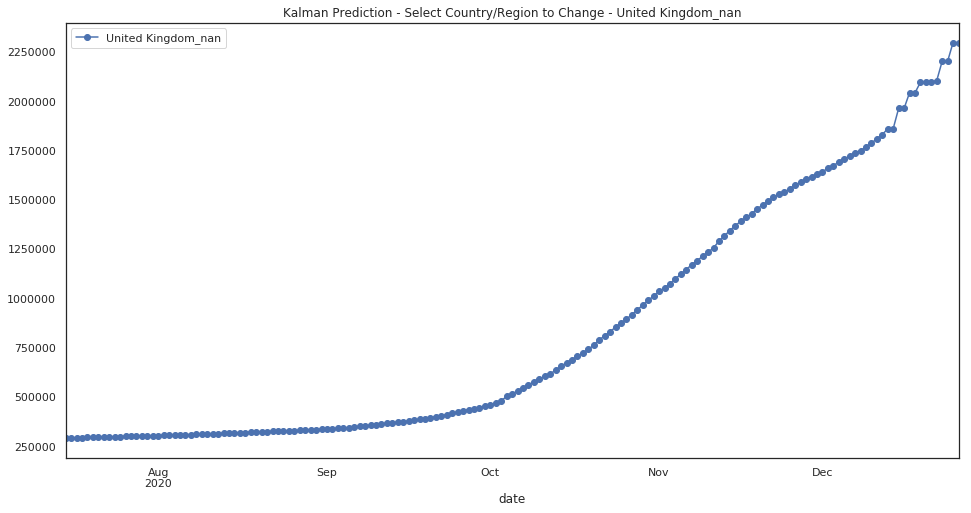

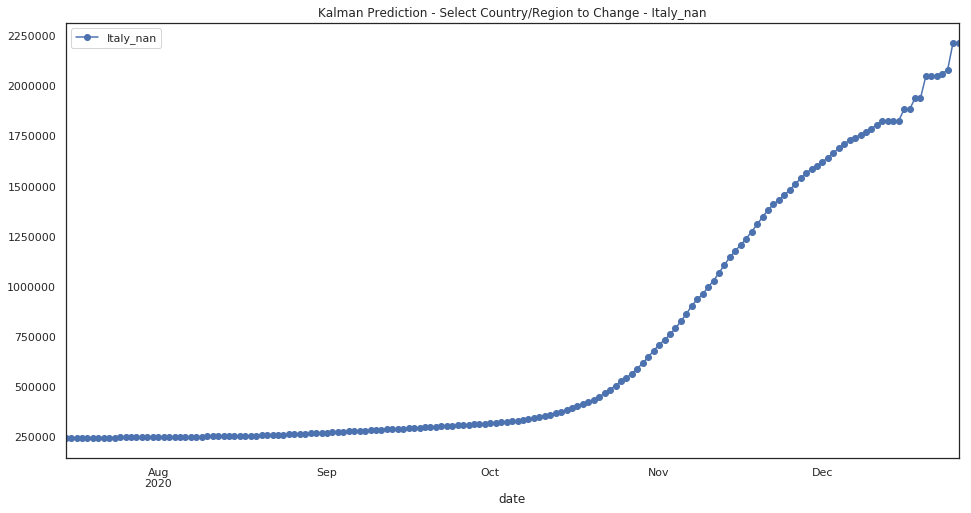

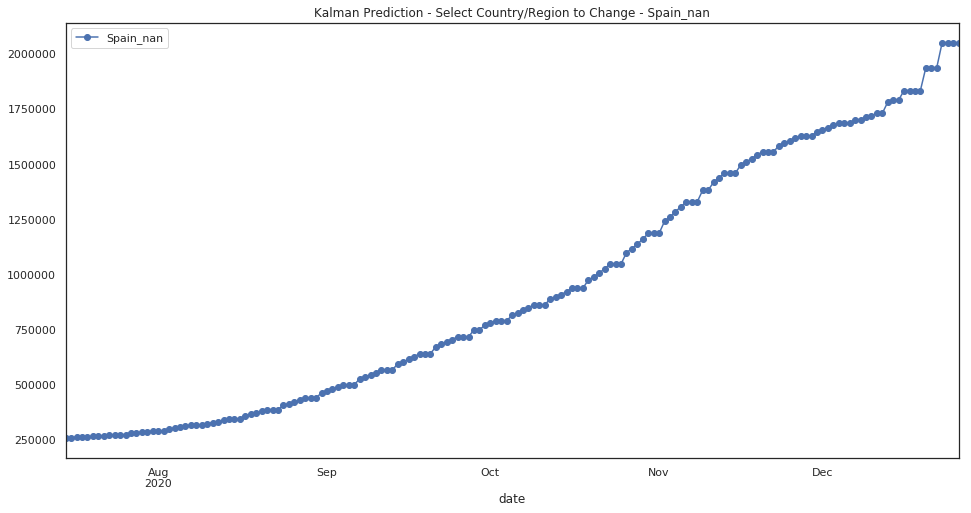

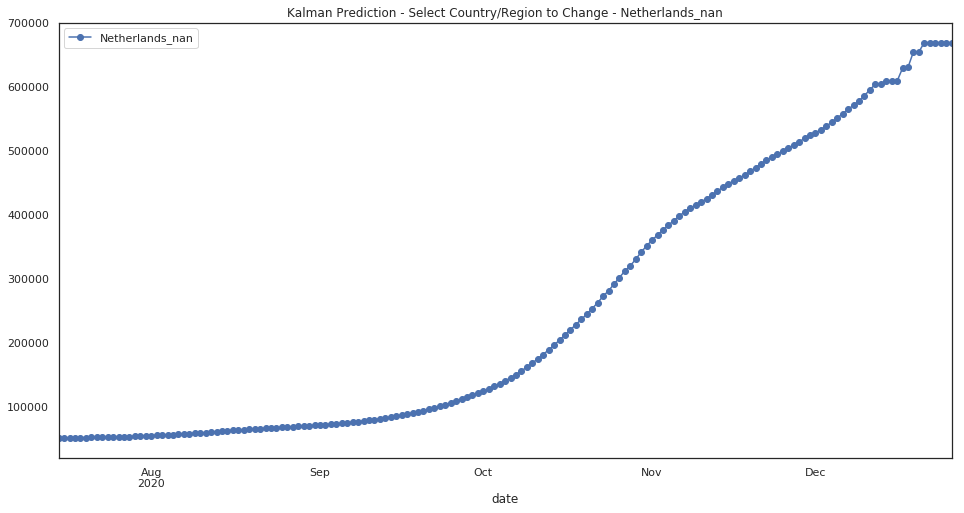

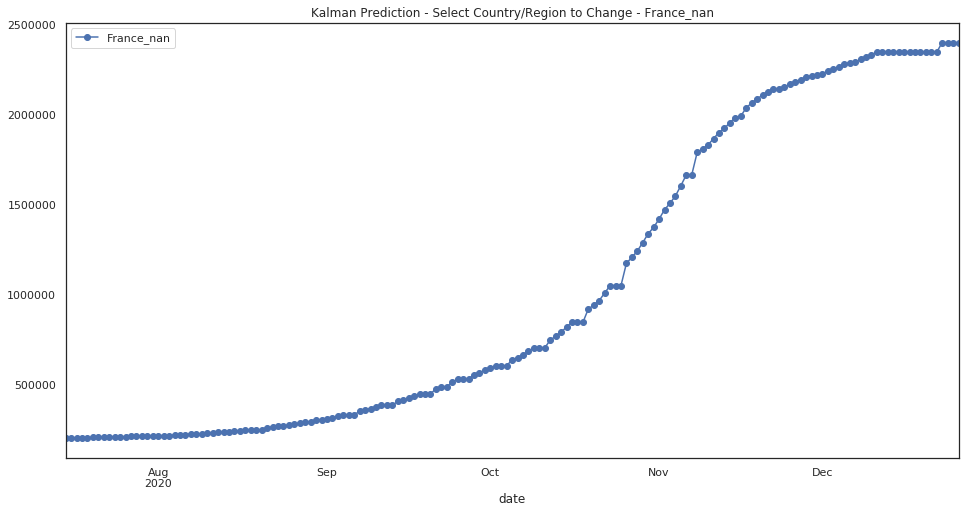

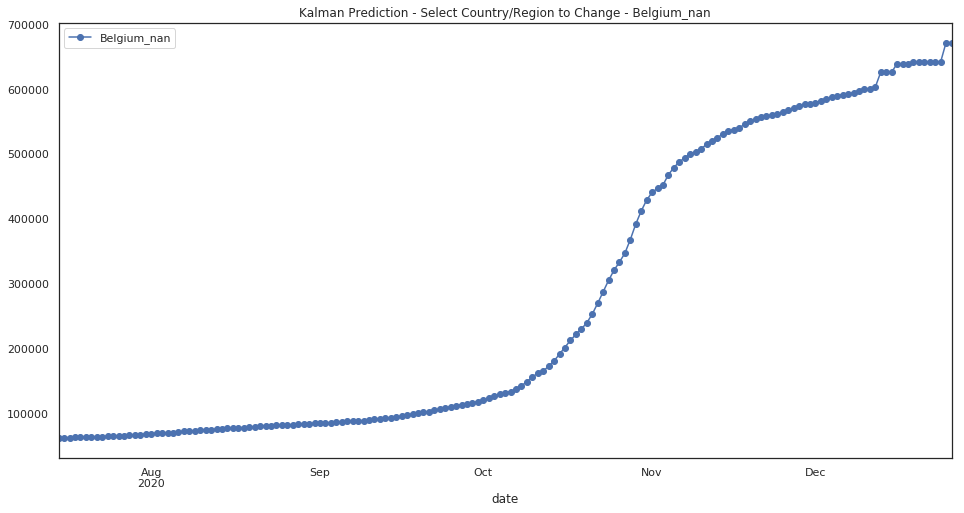

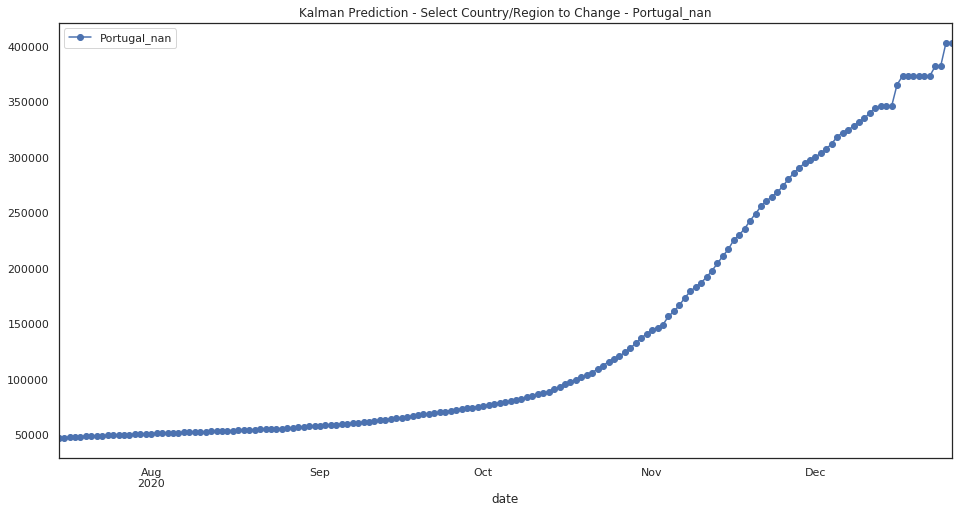

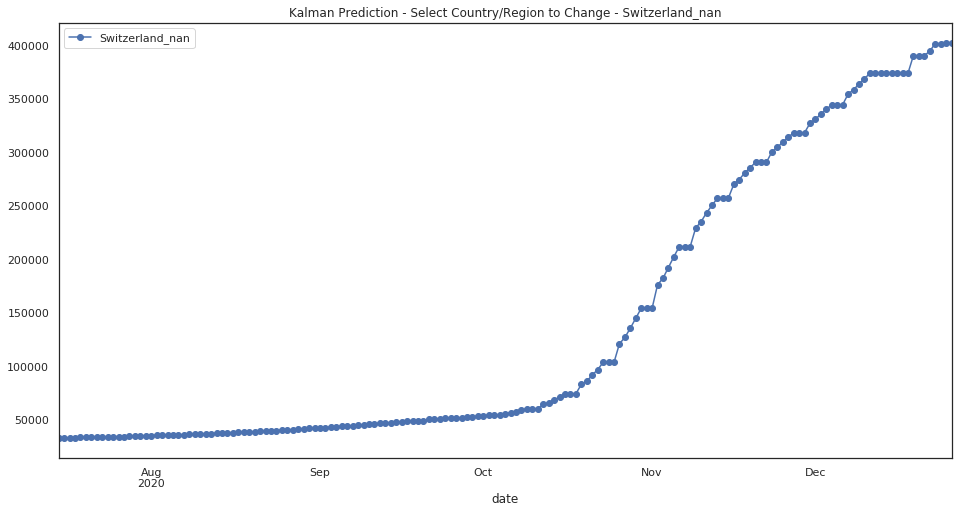

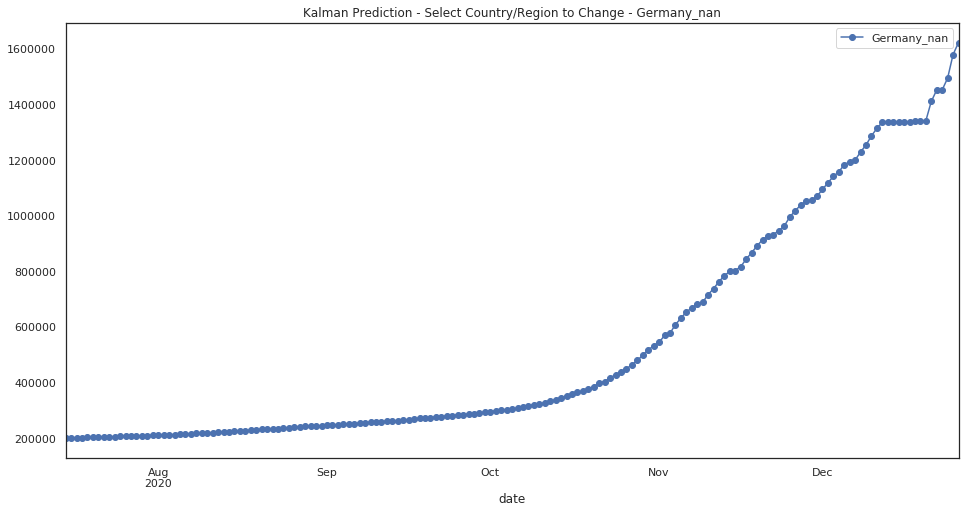

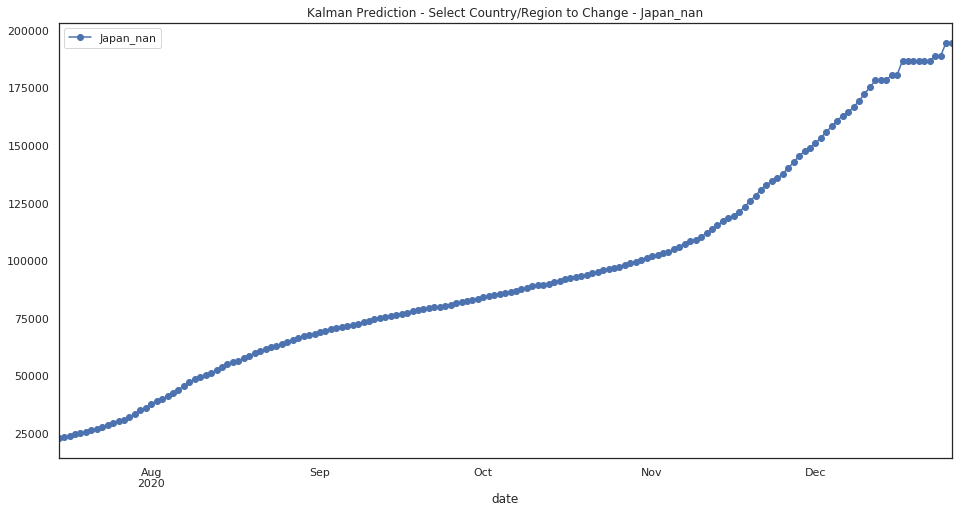

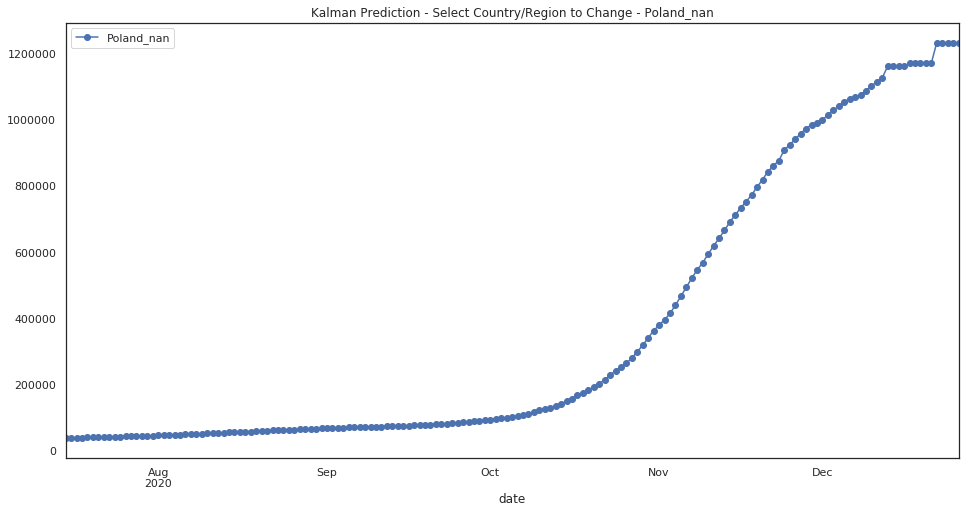

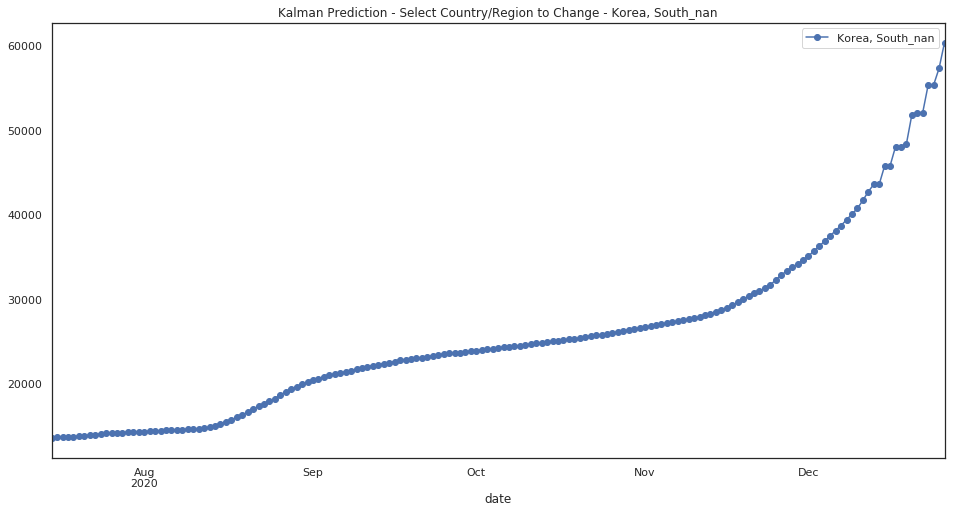

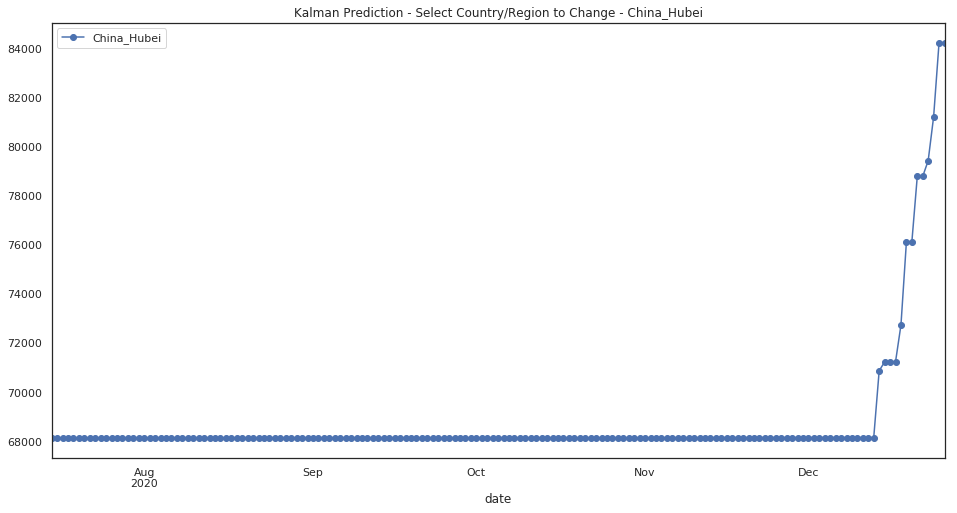

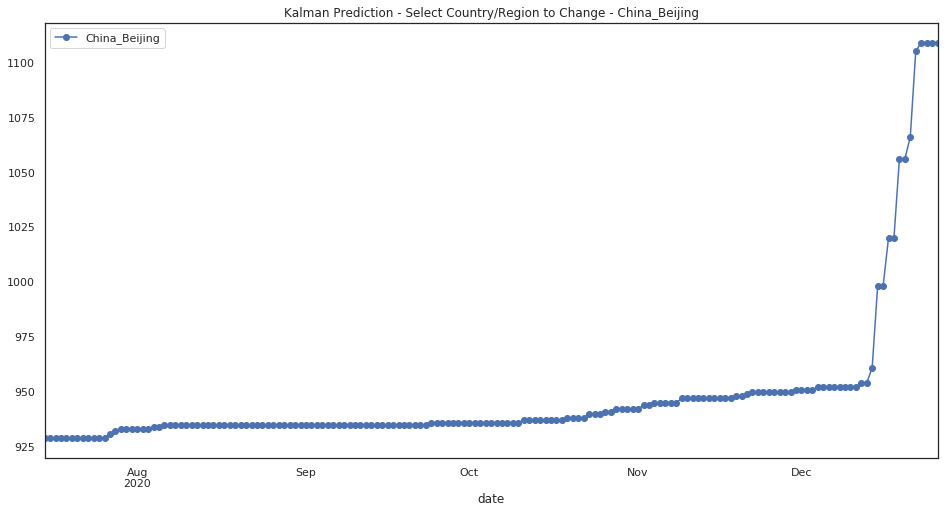

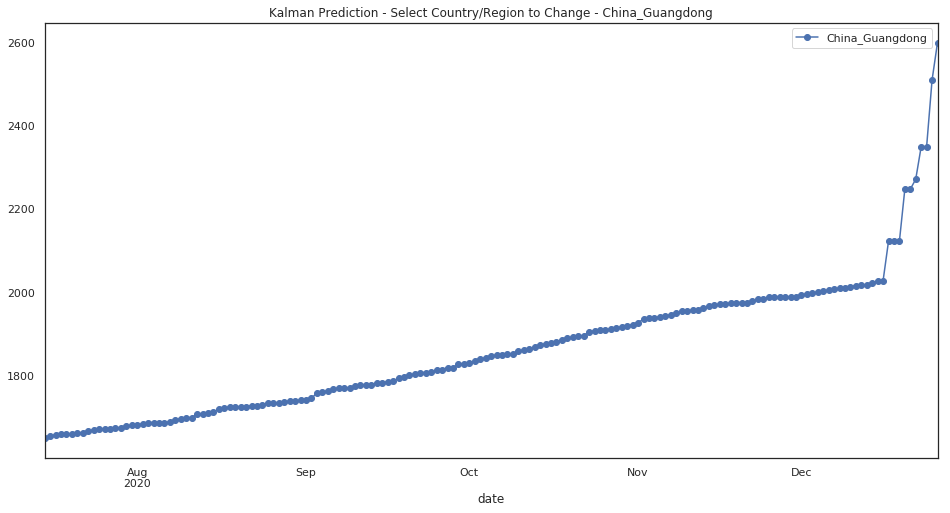

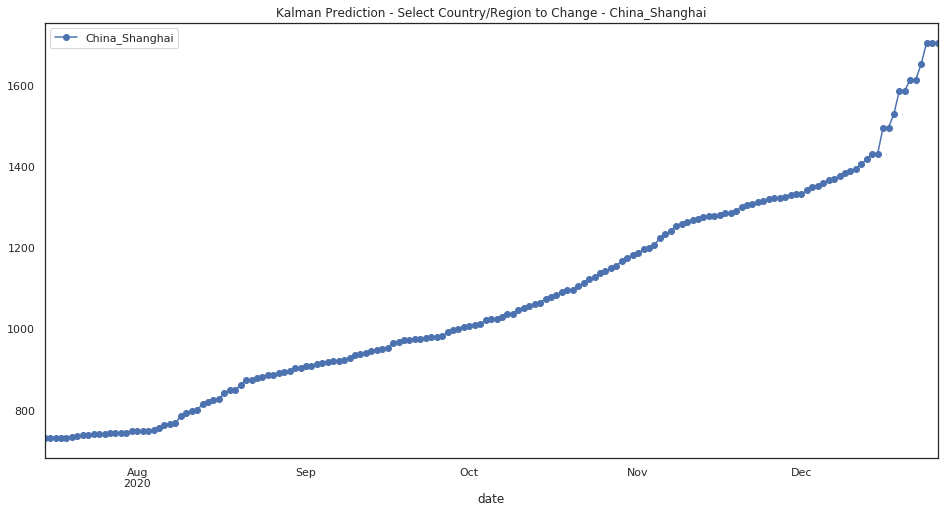

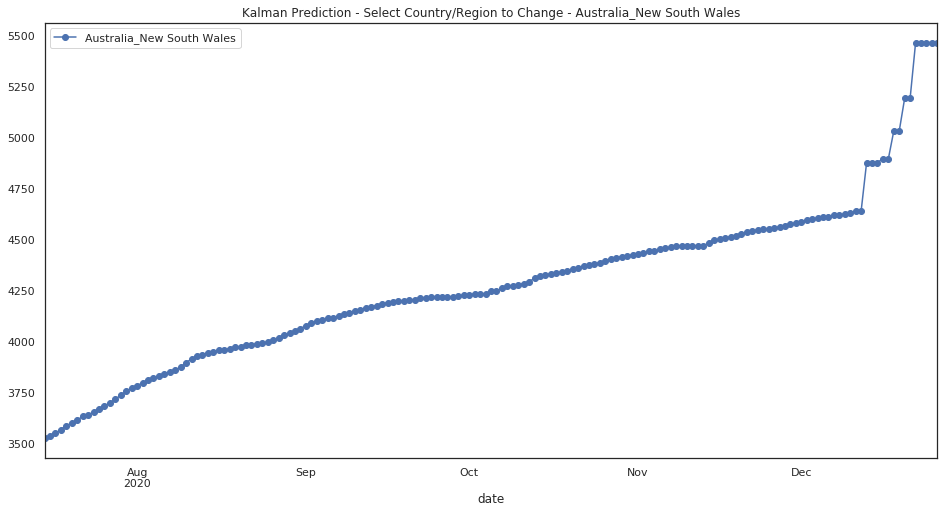

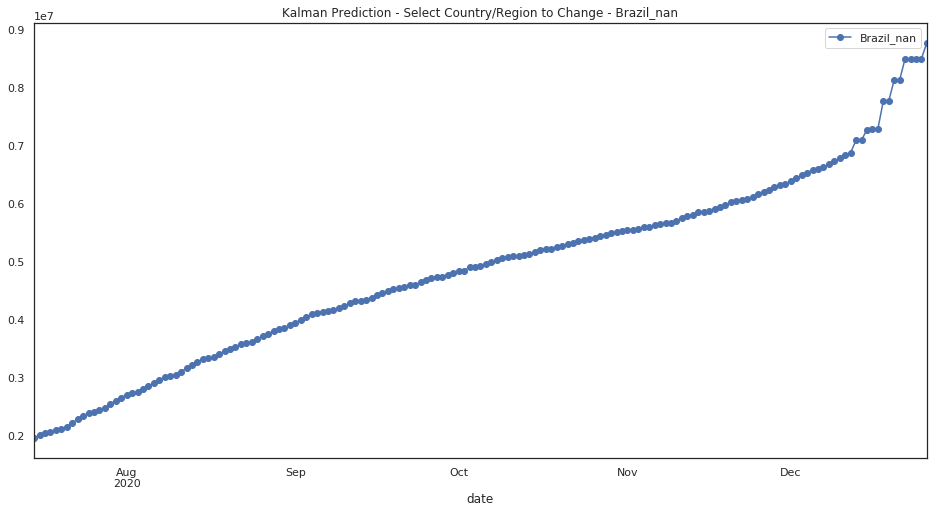

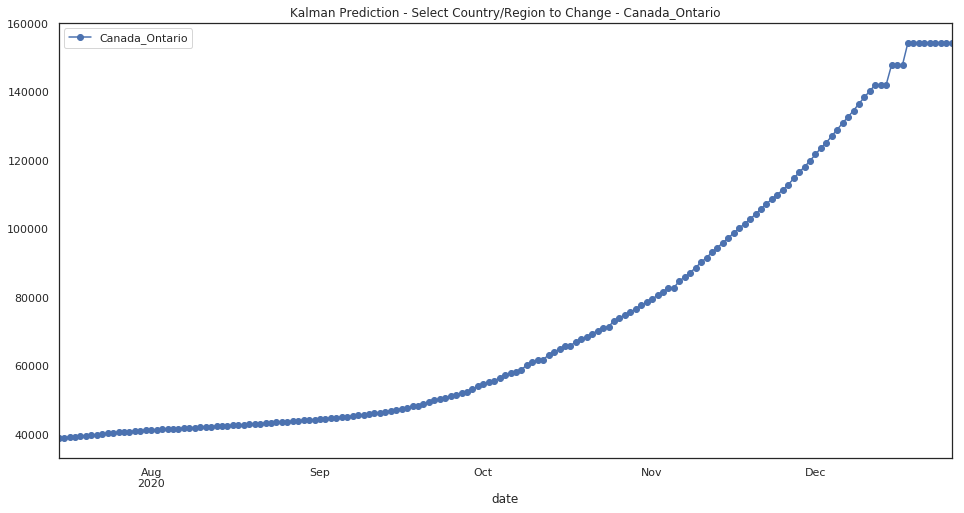

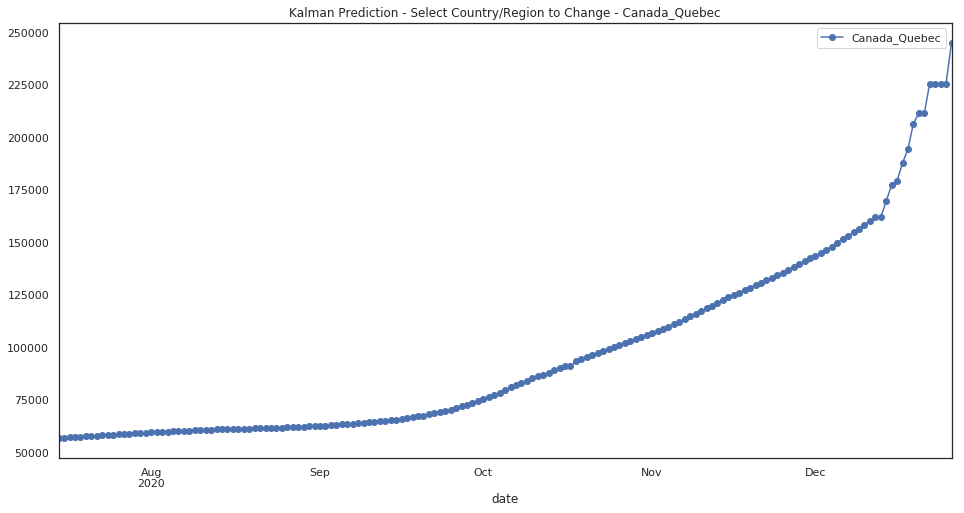

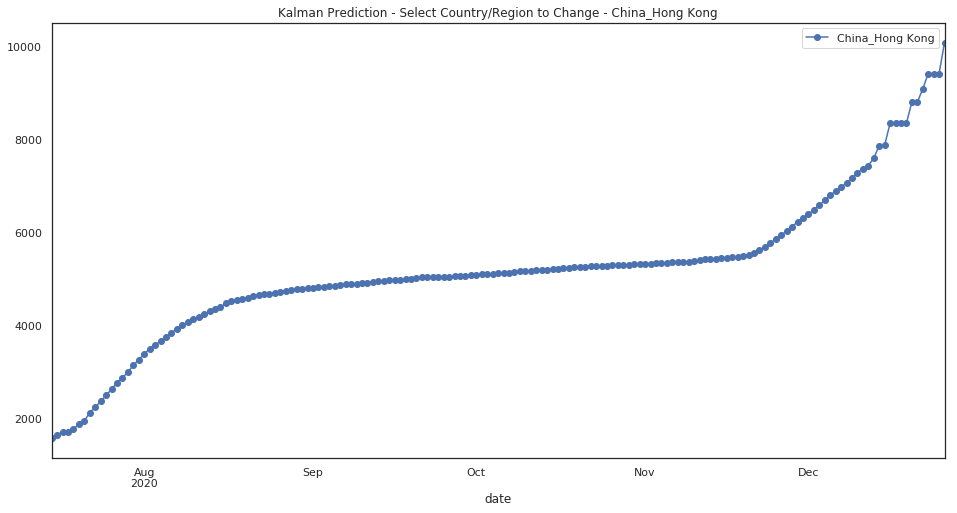

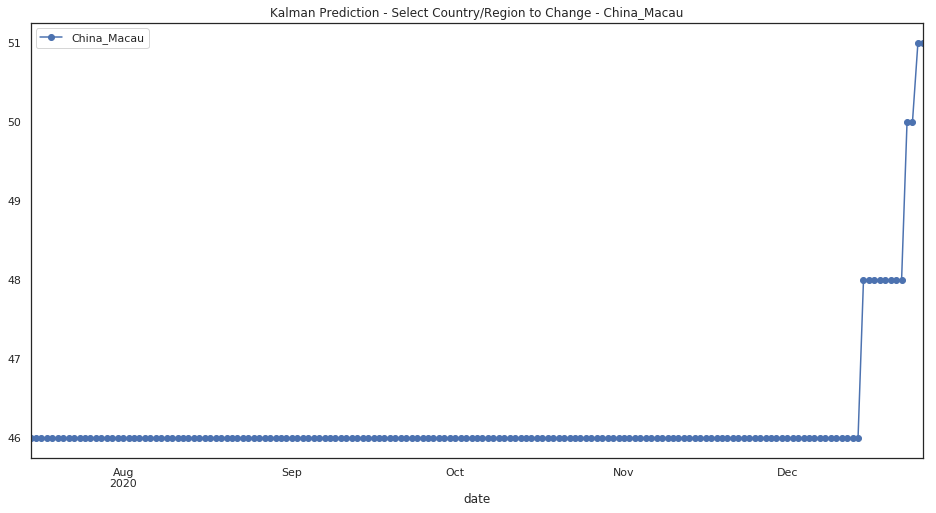

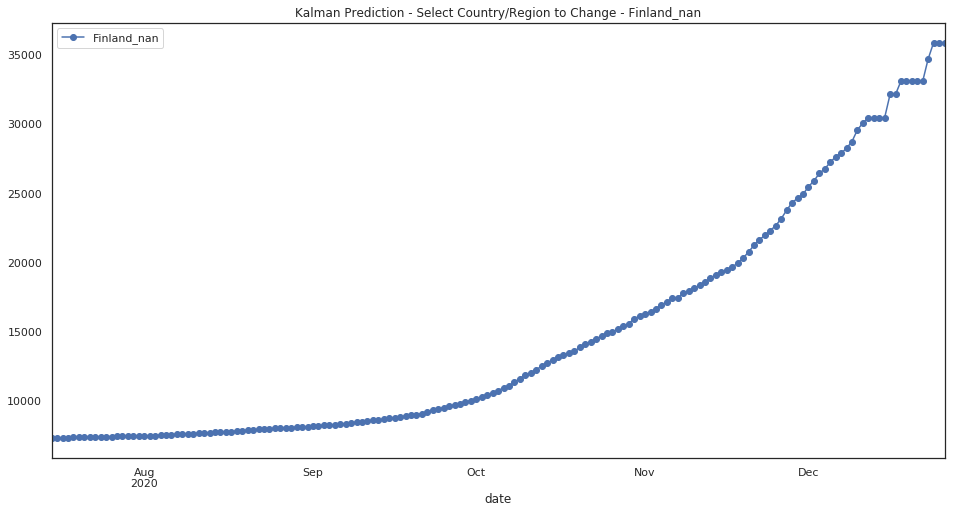

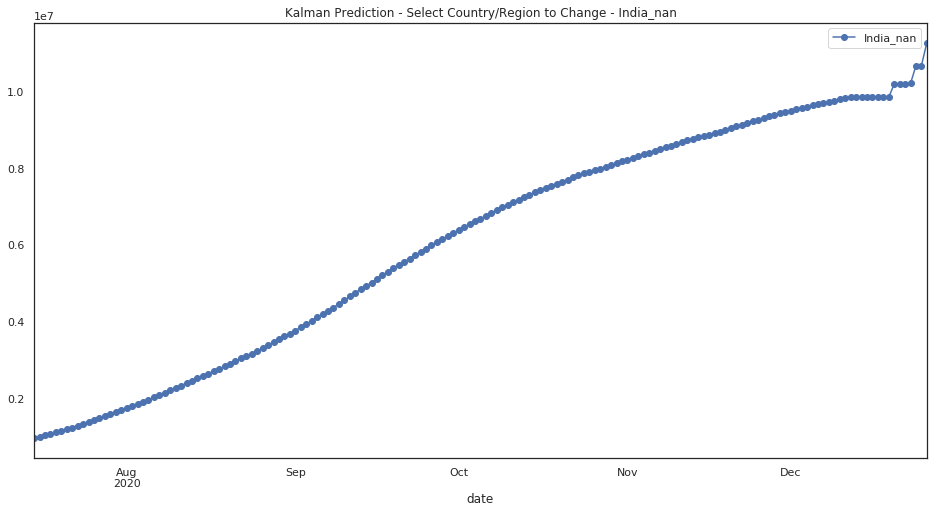

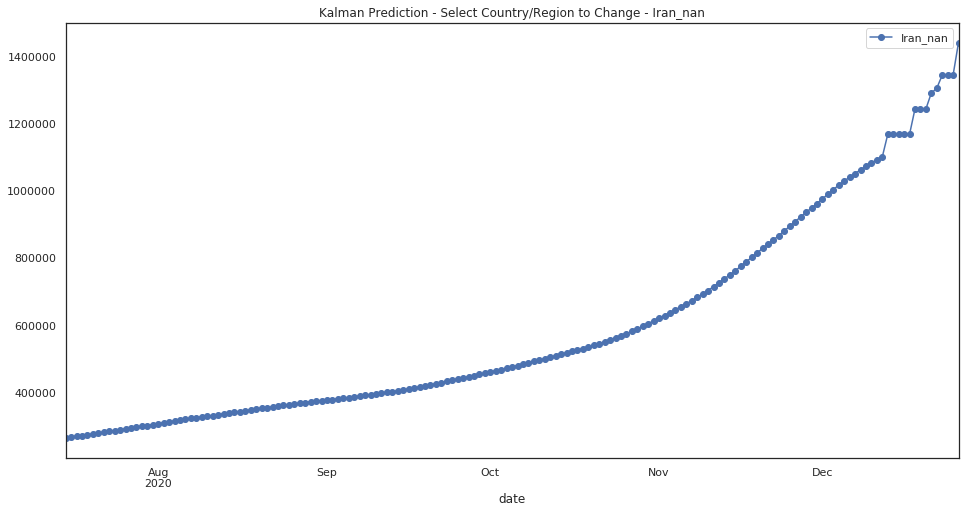

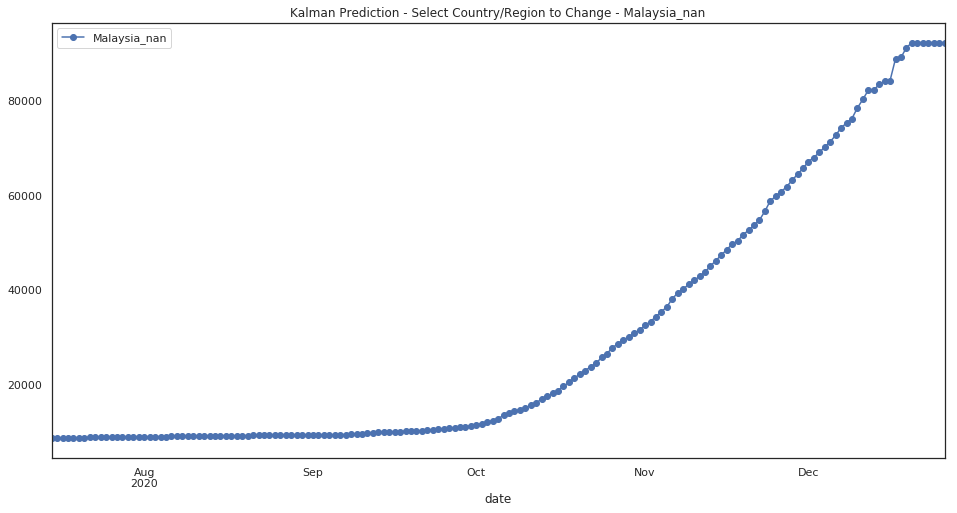

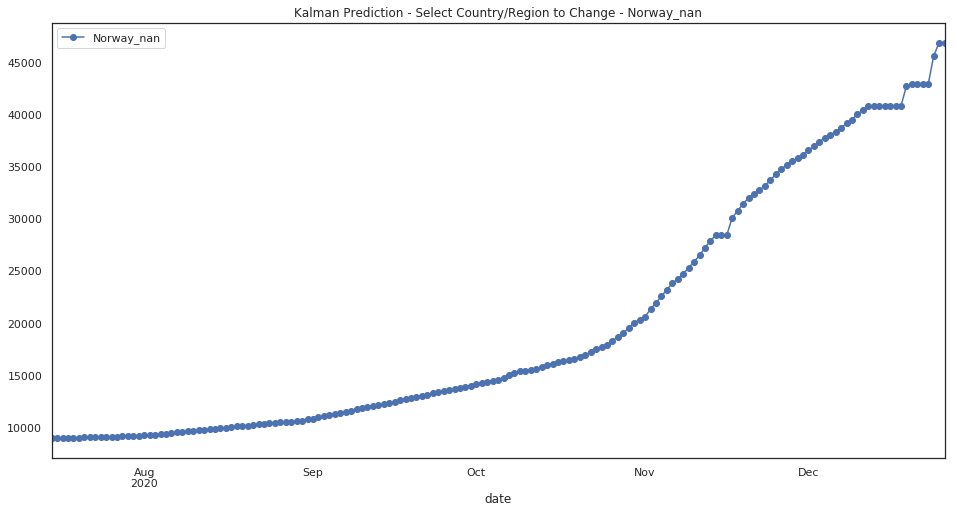

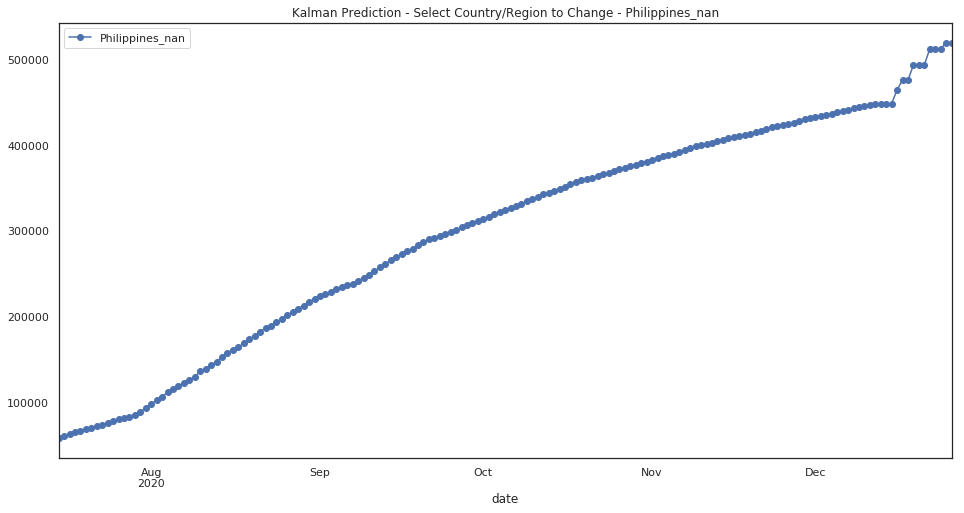

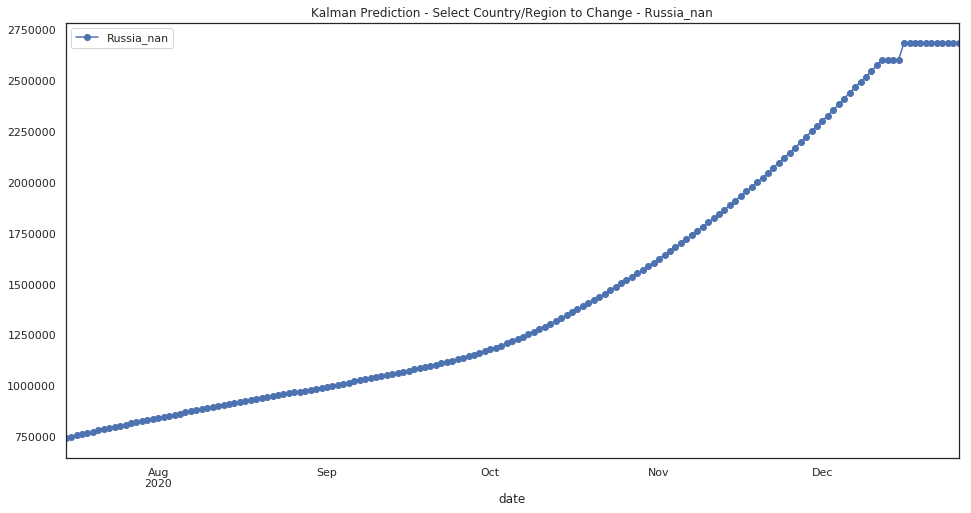

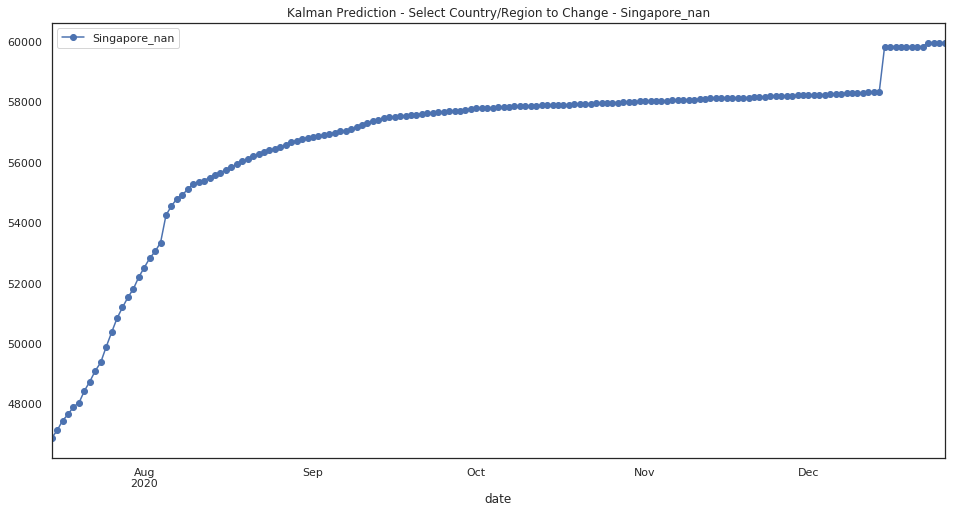

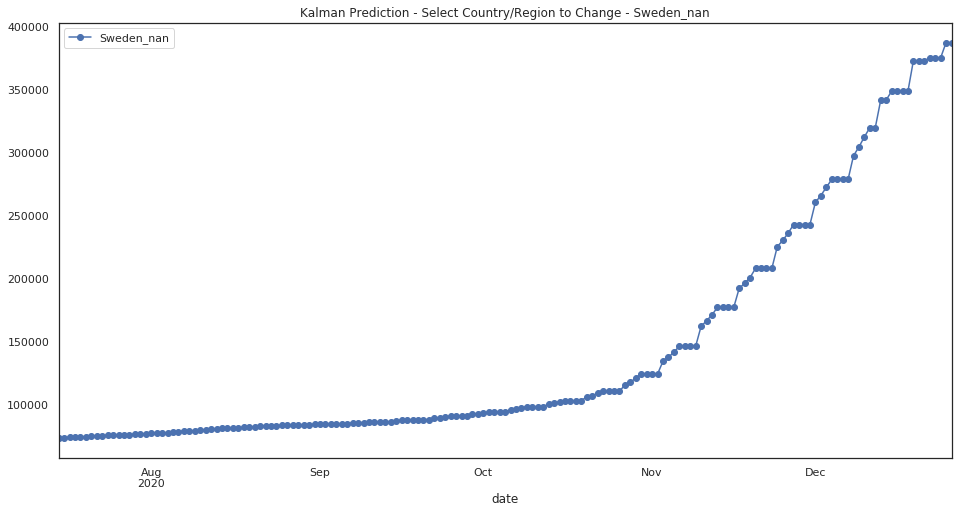

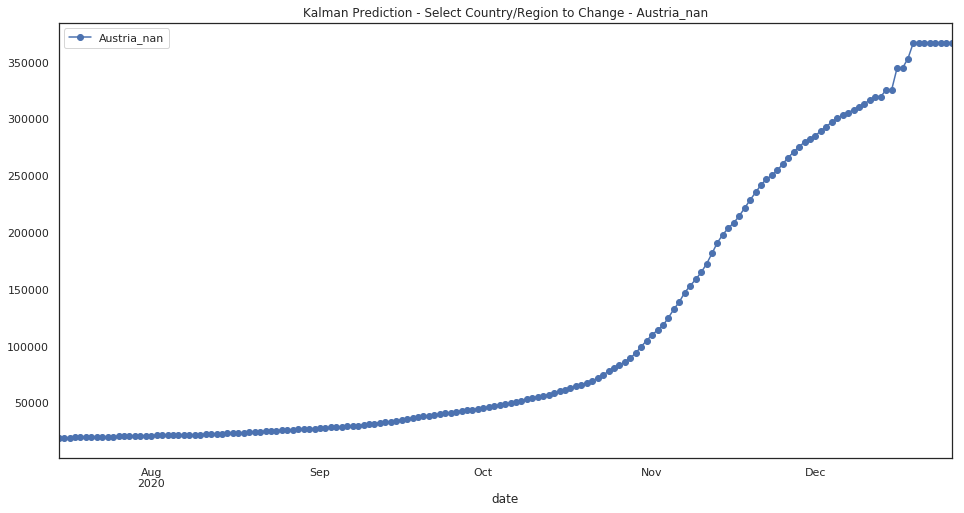

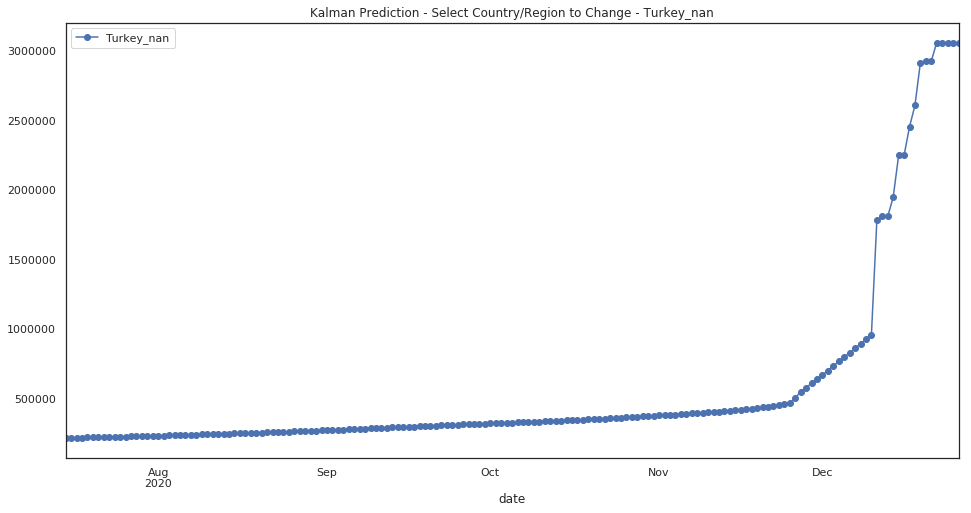

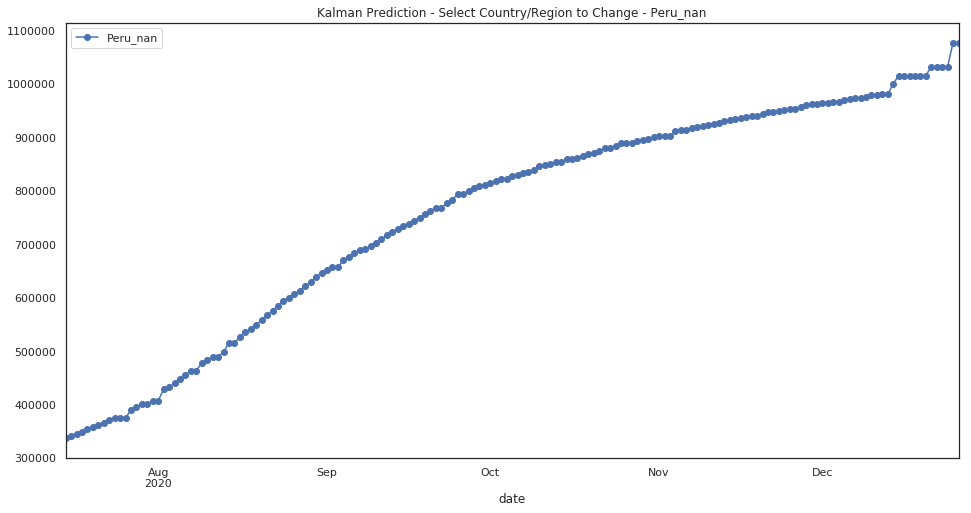

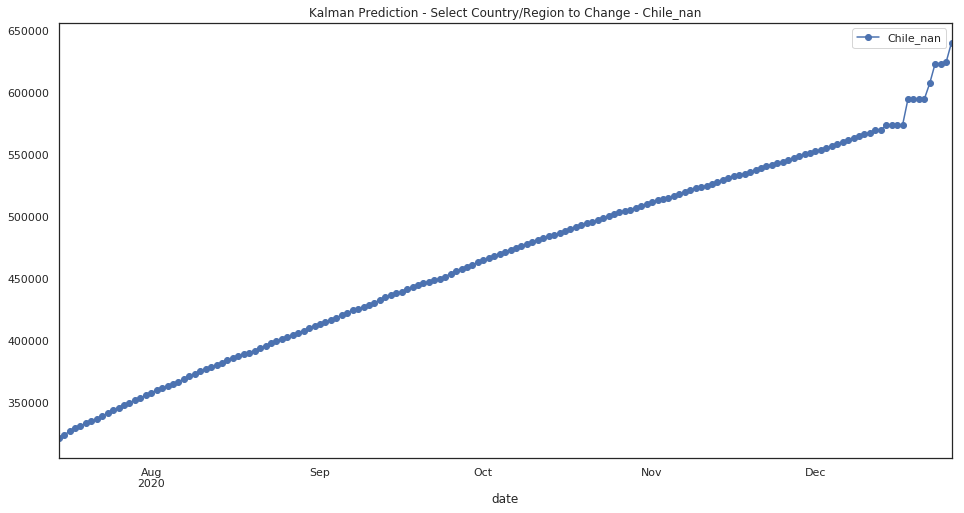

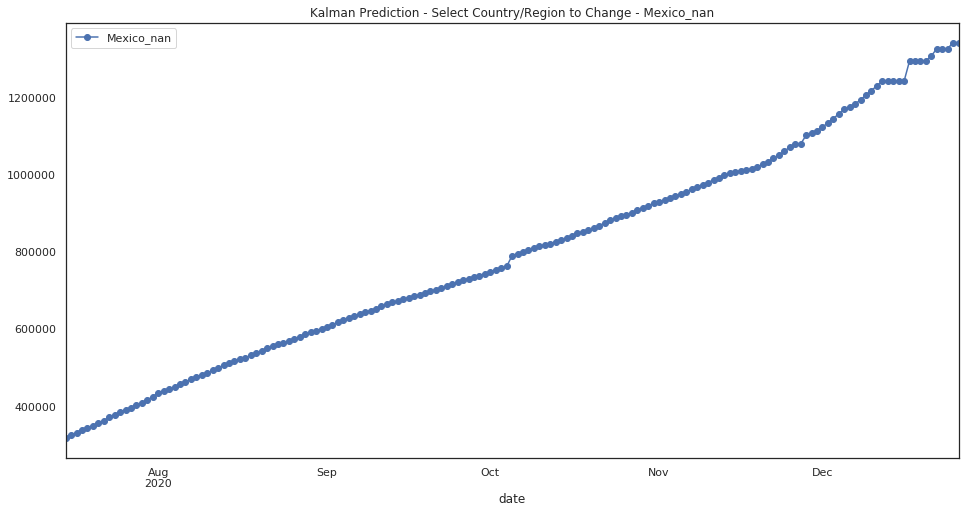

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-12-26 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      18127581.0
India_nan                                   NaN      11278322.0
Brazil_nan                                  NaN       8773001.0
Turkey_nan                                  NaN       3060130.0
Russia_nan                                  NaN       2685666.0
France_nan                                  NaN       2401891.0
United Kingdom_nan                          NaN       2297856.0
Italy_nan                                   NaN       2216201.0
Spain_nan                                   NaN       2051819.0
Germany_nan                                 NaN       1623021.0
Argentina_nan                               NaN       1602498.0
Colombia_nan                                NaN       1505200.0
Iran_nan                                    NaN       1441057.0
Mexico_nan                                  NaN       1341453.0
Poland_nan                                  NaN       1233204.0
Ukraine_nan                                 NaN       1151769.0
Peru_nan                                    NaN       1077549.0
South Africa_nan                            NaN        931798.0
Czechia_nan                                 NaN        725455.0
Iraq_nan                                    NaN        676001.0
Indonesia_nan                               NaN        675837.0
Belgium_nan                                 NaN        671769.0
Netherlands_nan                             NaN        668440.0
Chile_nan                                   NaN        640648.0
Romania_nan                                 NaN        628490.0
Pakistan_nan                                NaN        596379.0
Philippines_nan                             NaN        519462.0
Bangladesh_nan                              NaN        516189.0
Morocco_nan                                 NaN        437672.0
Hungary_nan                                 NaN        431680.0
...                                         ...             ...
Saint Vincent and the Grenadines_nan        NaN           100.0
Dominica_nan                                NaN            93.0
United Kingdom_British Virgin Islands       NaN            91.0
China_Ningxia                               NaN            81.0
Canada_Yukon                                NaN            79.0
Australia_Northern Territory                NaN            73.0
Grenada_nan                                 NaN            61.0
Laos_nan                                    NaN            54.0
China_Macau                                 NaN            51.0
Fiji_nan                                    NaN            47.0
France_New Caledonia                        NaN            42.0
Timor-Leste_nan                             NaN            38.0
Saint Kitts and Nevis_nan                   NaN            30.0
Holy See_nan                                NaN            28.0
Canada_Northwest Territories                NaN            28.0
China_Qinghai                               NaN            20.0
Denmark_Greenland                           NaN            20.0
Solomon Islands_nan                         NaN            19.0
United Kingdom_Falkland Islands (Malvinas)  NaN            19.0
France_Saint Pierre and Miquelon            NaN            16.0
Canada_Repatriated Travellers               NaN            15.0
Canada_Grand Princess                       NaN            13.0
United Kingdom_Montserrat                   NaN            13.0
United Kingdom_Anguilla                     NaN            10.0
MS Zaandam_nan                              NaN             9.0
Marshall Islands_nan                        NaN             4.0
Samoa_nan                                   NaN             2.0
Vanuatu_nan                                 NaN             1.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[271 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          40059.0      12797.0      27652.0      10274.0   
2020-07-16          40125.0      12883.0      28162.0      10287.0   
2020-07-17          35060.0       3851.0      21355.0        877.0   
2020-07-18          35219.0       3906.0      21948.0        880.0   
2020-07-19          35279.0       4008.0      22692.0        880.0   
2020-07-20          35453.0       4090.0      23304.0        880.0   
2020-07-21          35493.0       4171.0      23886.0        884.0   
2020-07-22          35605.0       4290.0      24485.0        884.0   
2020-07-23          35942.0       4515.0      25573.0        983.0   
2020-07-24          36027.0       4541.0      26240.0       1039.0   
2020-07-25          36073.0       4627.0      26854.0        957.0   
2020-07-26          36182.0       4819.0      27459.0       1045.0   
2020-07-27          36286.0       4829.0      28076.0       1053.0   
2020-07-28          36394.0       4974.0      28712.0        945.0   
2020-07-29          36500.0       5095.0      29331.0       1069.0   
2020-07-30          36573.0       5209.0      29940.0        961.0   
2020-07-31          36693.0       5315.0      30509.0       1040.0   
2020-08-01          36744.0       5445.0      31062.0       1053.0   
2020-08-02          36746.0       5505.0      31580.0       1077.0   
2020-08-03          36772.0       5611.0      32085.0       1084.0   
2020-08-04          36804.0       5778.0      32609.0        963.0   
2020-08-05          36848.0       5874.0      33153.0       1077.0   
2020-08-06          36948.0       5996.0      33720.0       1098.0   
2020-08-07          37033.0       6159.0      34256.0       1049.0   
2020-08-08          37077.0       6280.0      34793.0        996.0   
2020-08-09          37114.0       6431.0      35268.0       1115.0   
2020-08-10          37179.0       6545.0      35806.0       1118.0   
2020-08-11          37282.0       6701.0      36306.0       1030.0   
2020-08-12          37366.0       6827.0      36799.0       1127.0   
2020-08-13          37452.0       6981.0      37287.0       1001.0   
...                     ...          ...          ...          ...   
2020-11-28          45884.0      36963.0      81384.0       6933.0   
2020-11-29          46134.0      37754.0      82395.0       7107.0   
2020-11-30          46318.0      38361.0      83367.0       7023.0   
2020-12-01          46540.0      39148.0      84315.0       7152.0   
2020-12-02          46756.0      39884.0      85239.0       7195.0   
2020-12-03          46881.0      40653.0      86085.0       7241.0   
2020-12-04          46887.0      41464.0      86870.0       7284.0   
2020-12-05          47075.0      42310.0      87630.0       7349.0   
2020-12-06          47329.0      43165.0      88368.0       7401.0   
2020-12-07          47543.0      43881.0      88952.0       7439.0   
2020-12-08          47749.0      44622.0      89497.0       7494.0   
2020-12-09          47889.0      45373.0      90086.0       7520.0   
2020-12-10          48074.0      46231.0      90646.0       7557.0   
2020-12-11          48161.0      47056.0      91178.0       7607.0   
2020-12-12          48255.0      47923.0      91687.0       7640.0   
2020-12-13          48270.0      49388.0      95291.0       7643.0   
2020-12-14          48251.0      52244.0      96556.0       7737.0   
2020-12-15          50148.0      53727.0      95806.0       7693.0   
2020-12-16          51391.0      53716.0      96154.0       7846.0   
2020-12-17          51665.0      53567.0      96225.0       8022.0   
2020-12-18          52738.0      56359.0      96136.0       7911.0   
2020-12-19          52985.0      57199.0      96126.0       8264.0   
2020-12-20          54515.0      60431.0      99029.0       8486.0   
2020-12-21          55862.0      62960.0     102568.0       8562.0   
2020-12-22

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Turkey_nan',
 'Russia_nan',
 'France_nan',
 'United Kingdom_nan',
 'Italy_nan',
 'Spain_nan',
 'Germany_nan',
 'Argentina_nan',
 'Colombia_nan',
 'Iran_nan',
 'Mexico_nan',
 'Poland_nan',
 'Ukraine_nan',
 'Peru_nan',
 'South Africa_nan',
 'Czechia_nan',
 'Iraq_nan',
 'Indonesia_nan',
 'Belgium_nan',
 'Netherlands_nan',
 'Chile_nan',
 'Romania_nan',
 'Pakistan_nan',
 'Philippines_nan',
 'Bangladesh_nan',
 'Morocco_nan',
 'Hungary_nan',
 'Israel_nan',
 'Portugal_nan',
 'Switzerland_nan',
 'Sweden_nan',
 'Saudi Arabia_nan',
 'Austria_nan',
 'Serbia_nan',
 'Nepal_nan',
 'Jordan_nan',
 'Panama_nan',
 'Georgia_nan',
 'Croatia_nan',
 'Canada_Quebec',
 'United Arab Emirates_nan',
 'Bulgaria_nan',
 'Ecuador_nan',
 'Kazakhstan_nan',
 'Japan_nan',
 'Lebanon_nan',
 'Belarus_nan',
 'Azerbaijan_nan',
 'Kuwait_nan',
 'Armenia_nan',
 'Bolivia_nan',
 'Greece_nan',
 'Dominican Republic_nan',
 'Oman_nan',
 'Guatemala_nan',
 'Costa Rica_nan',
 'Qatar_na

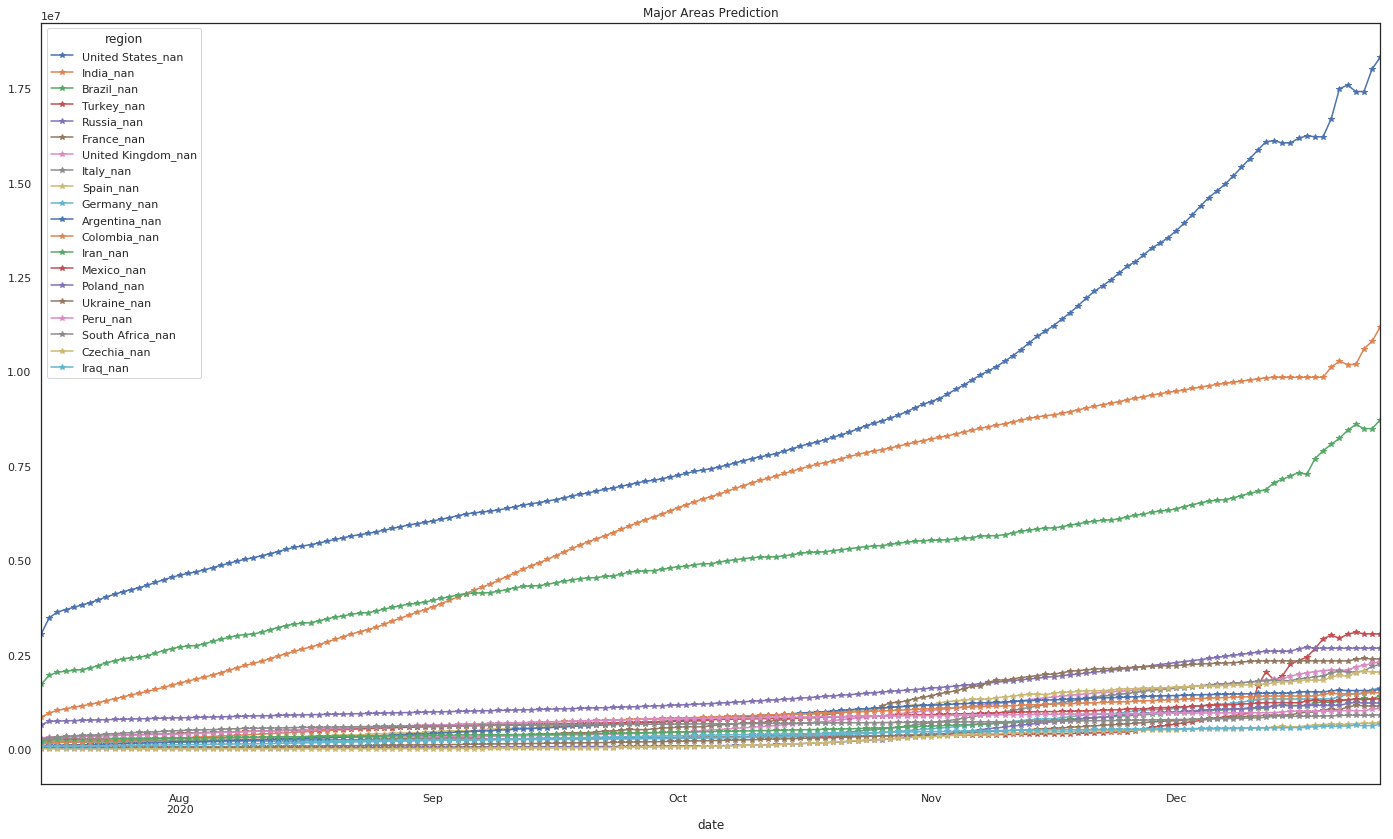

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

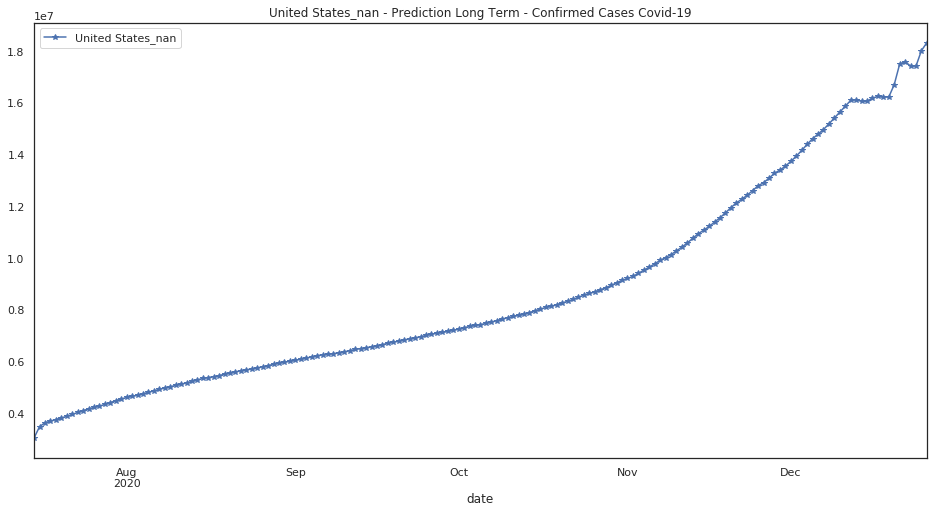

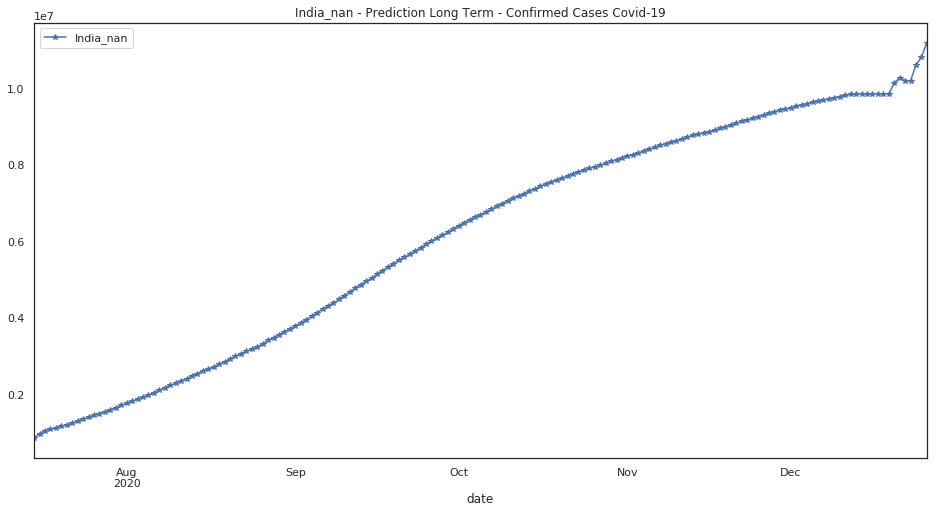

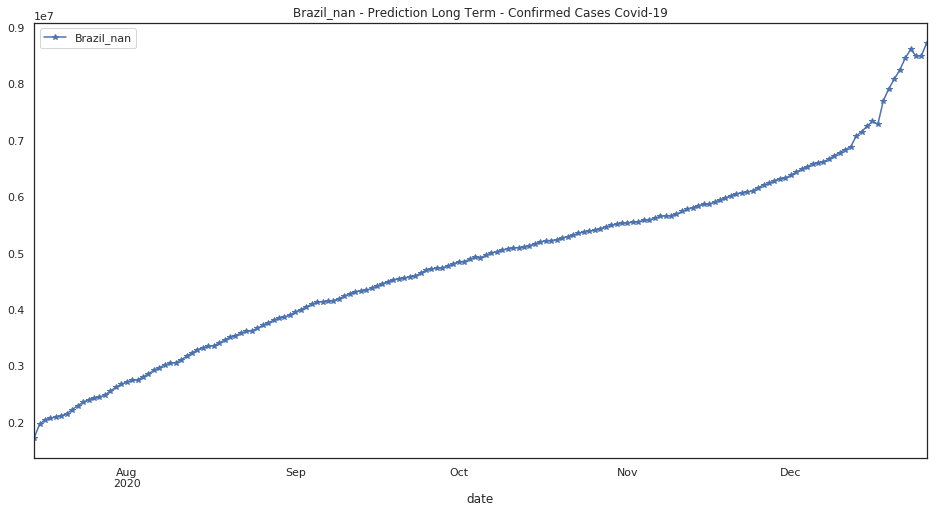

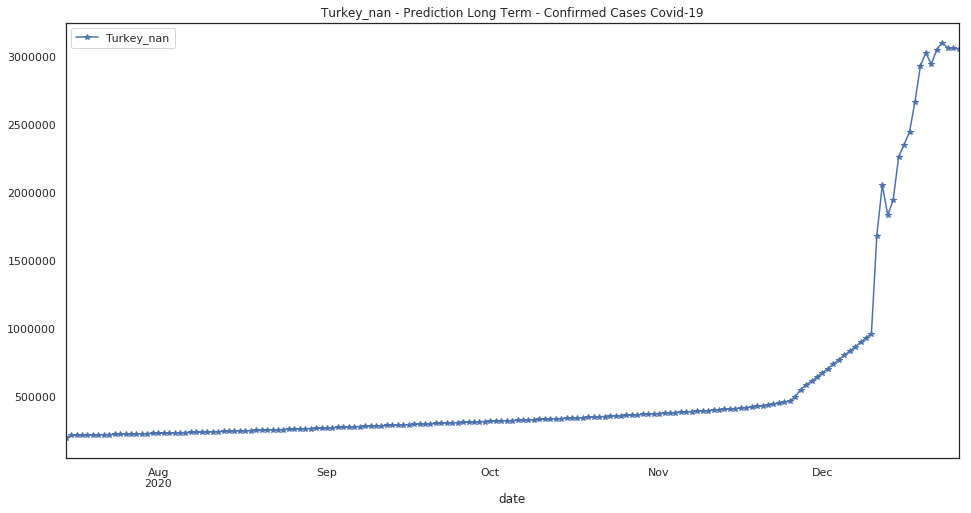

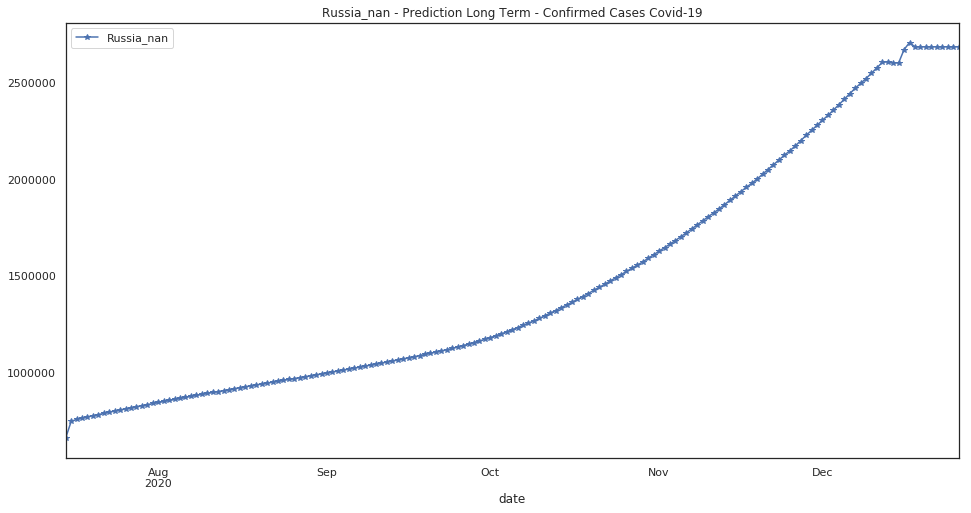

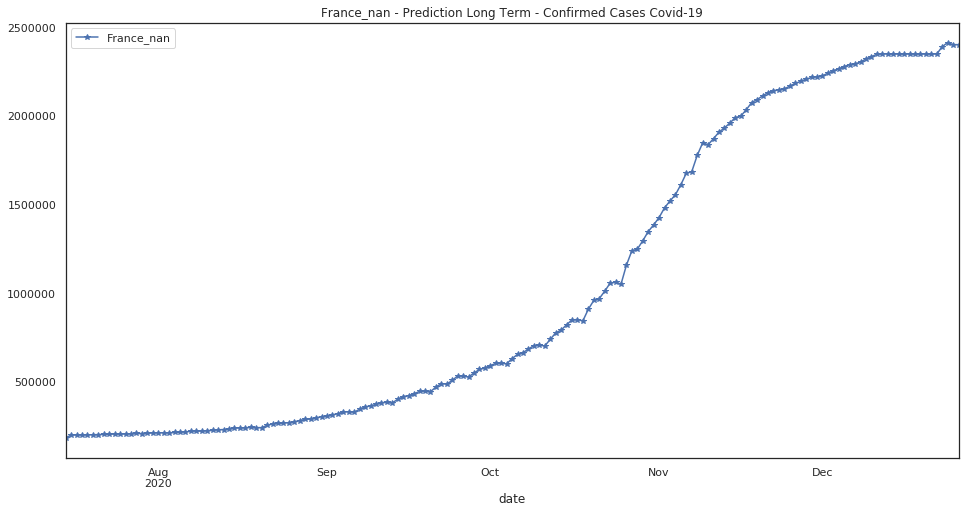

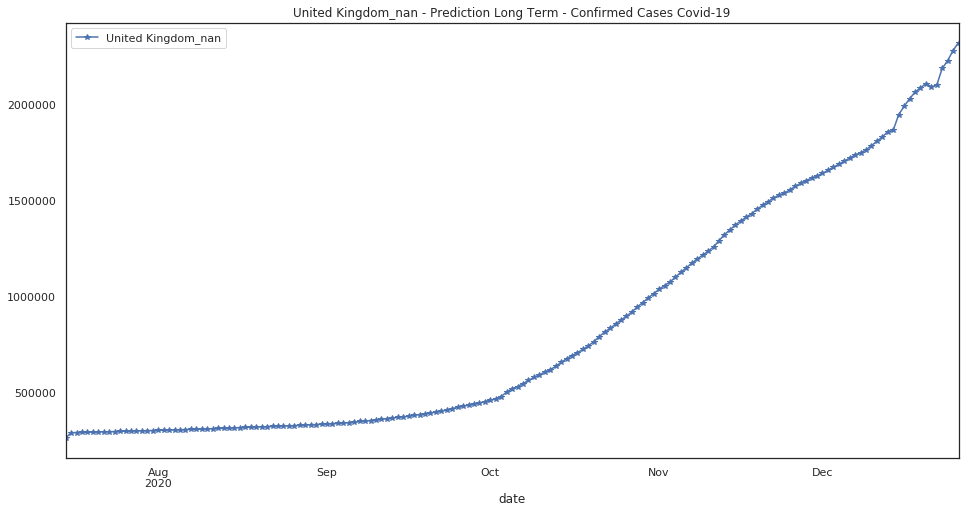

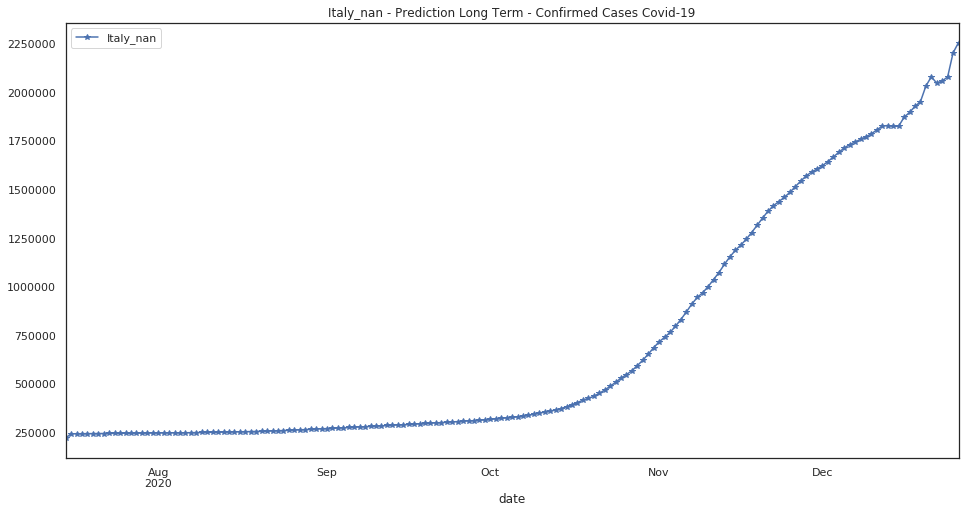

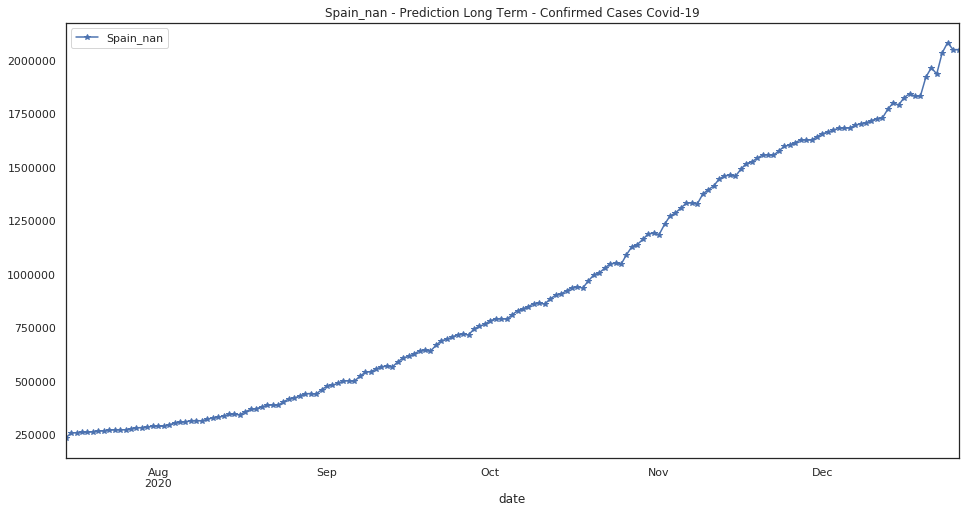

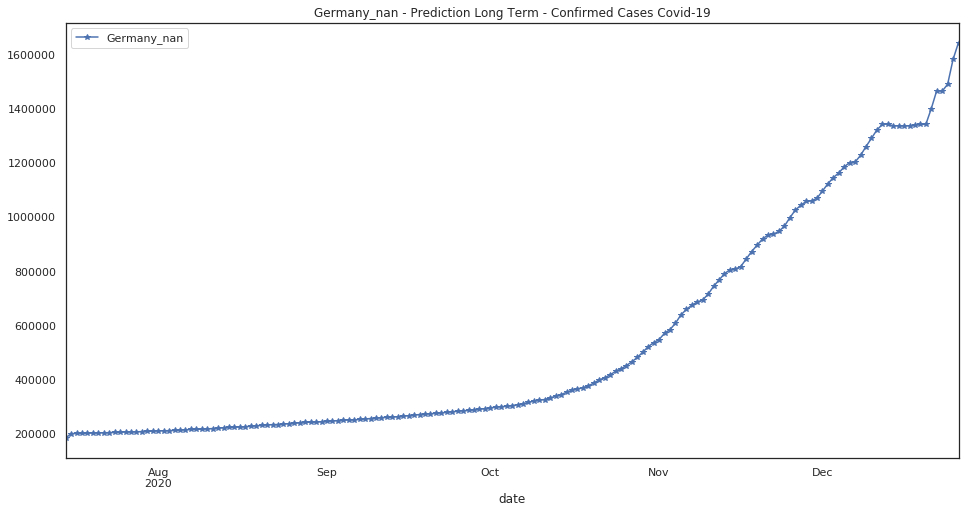

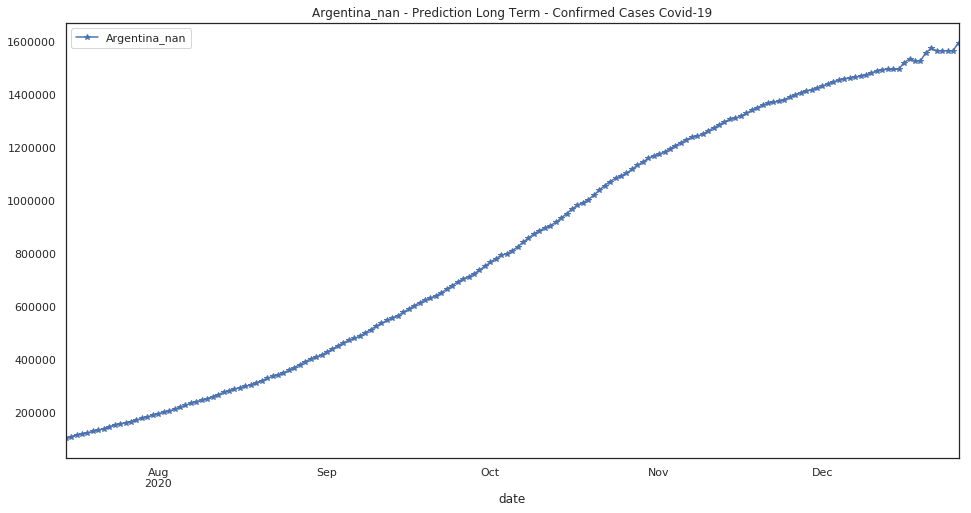

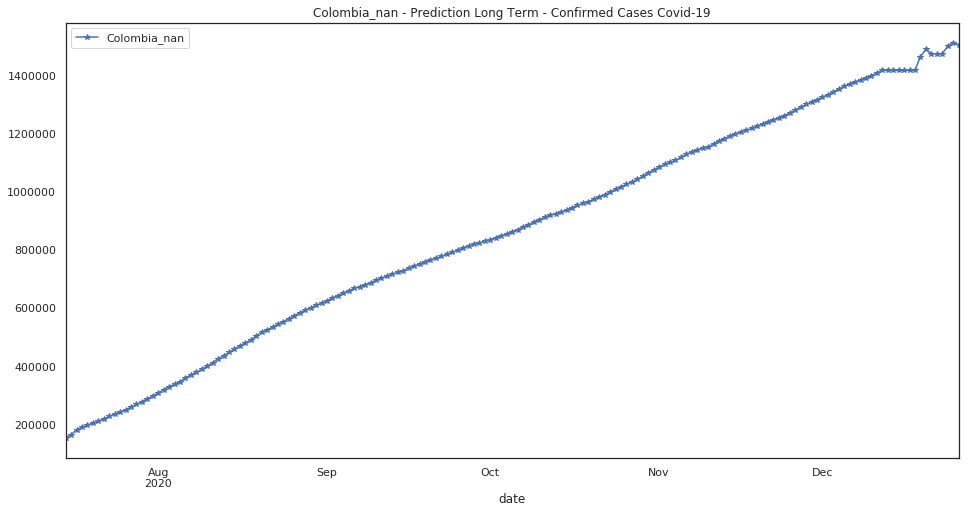

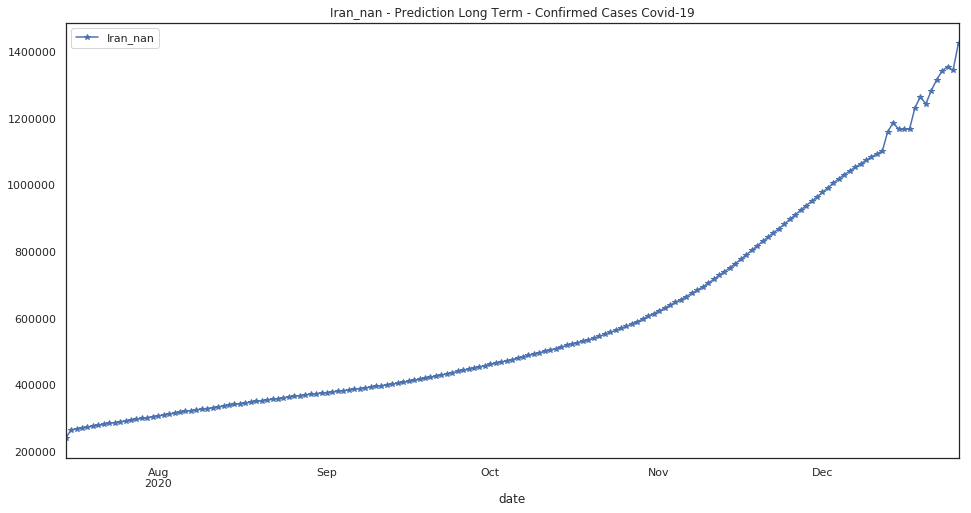

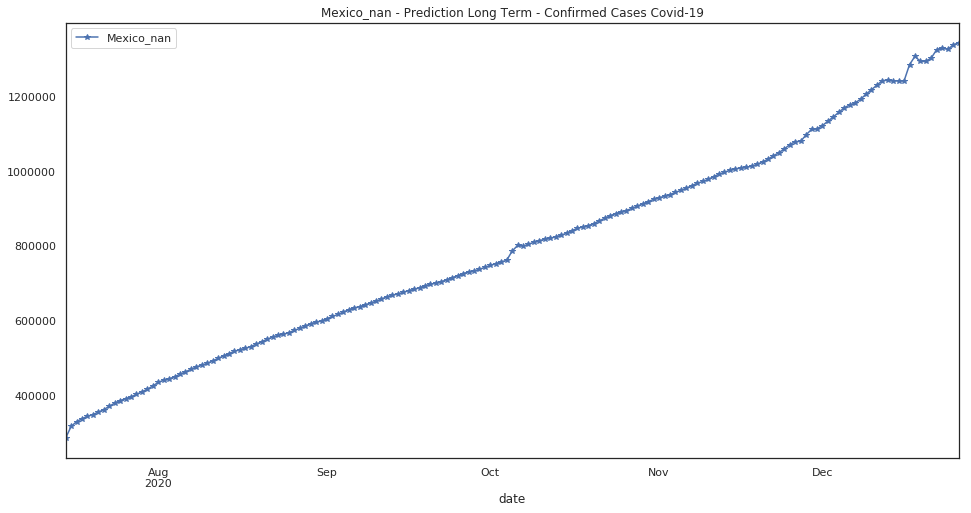

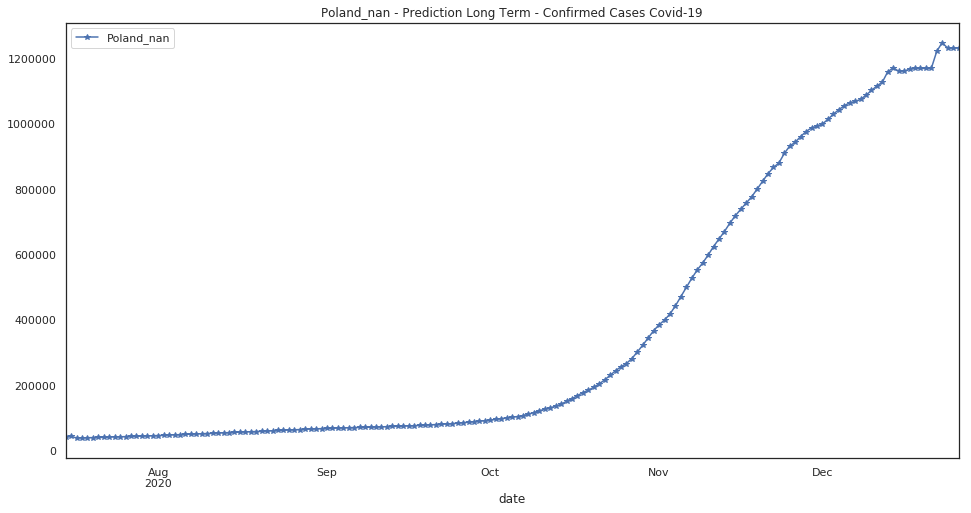

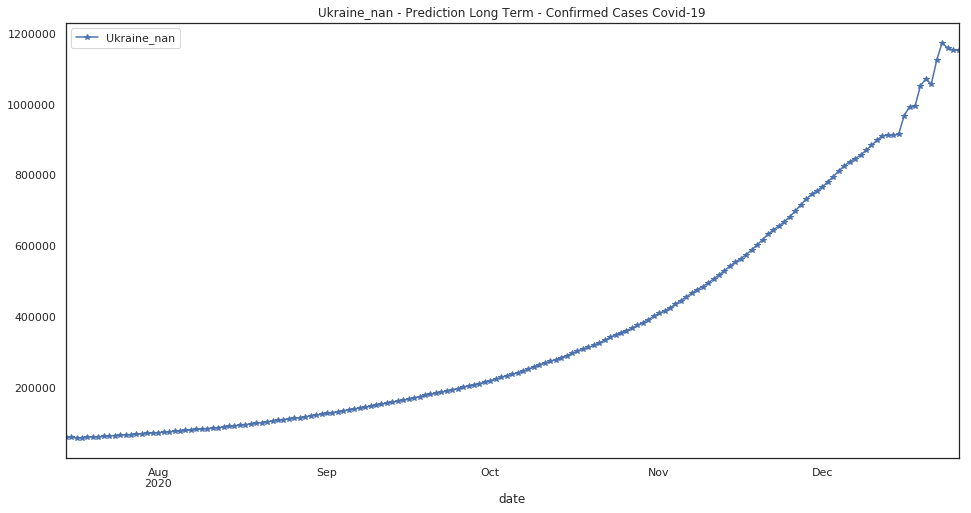

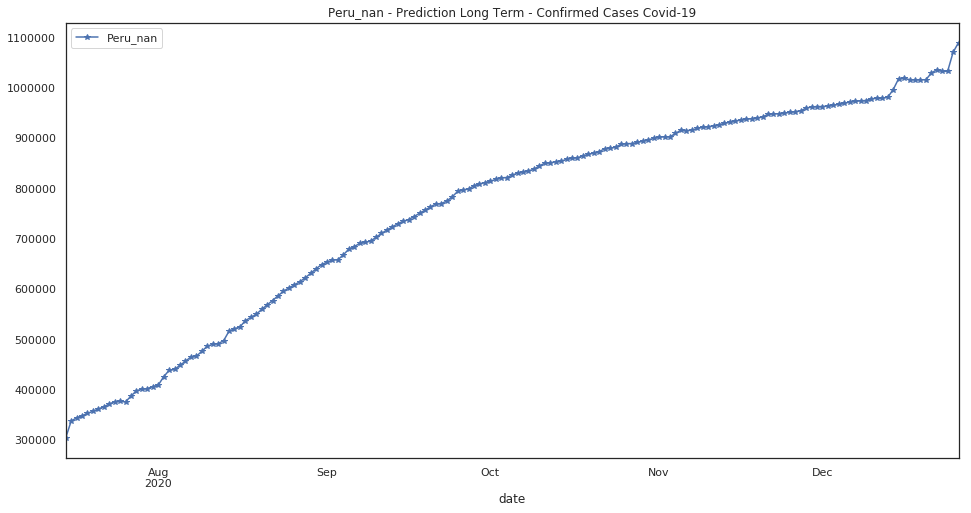

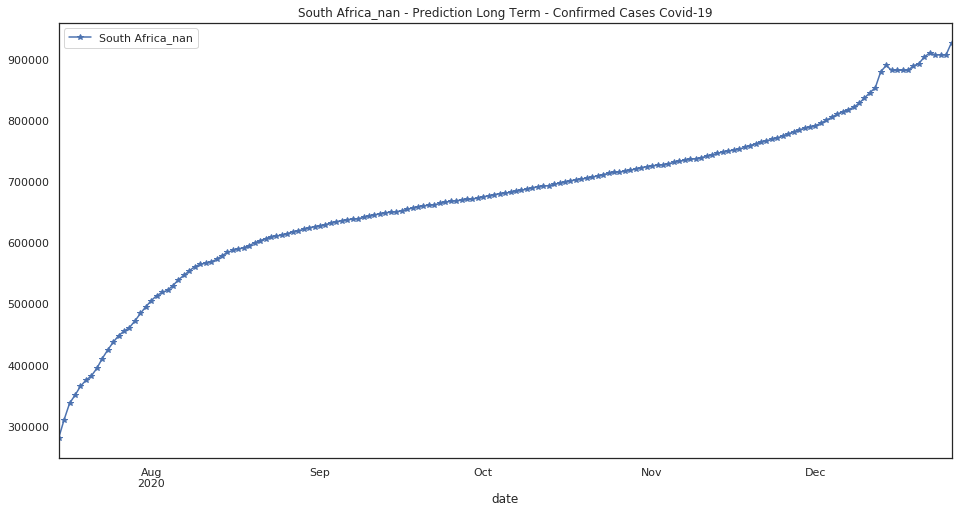

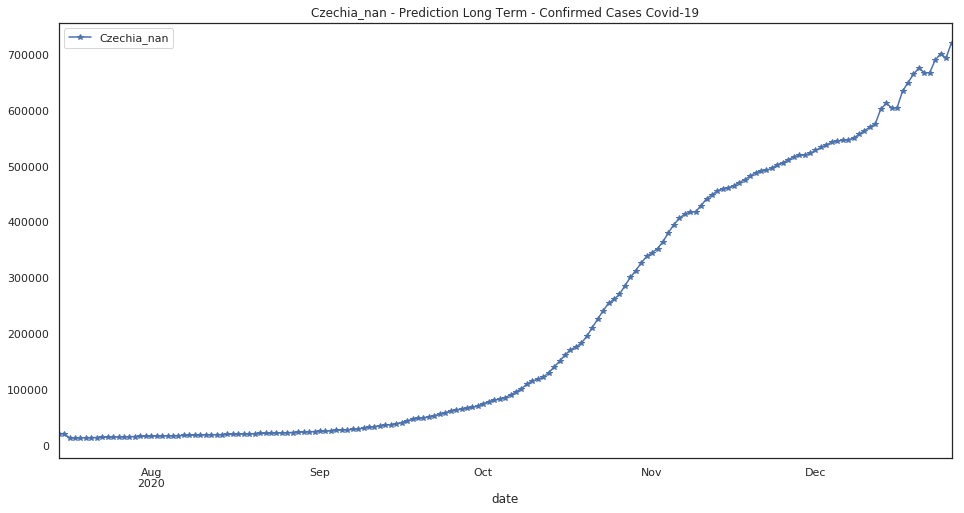

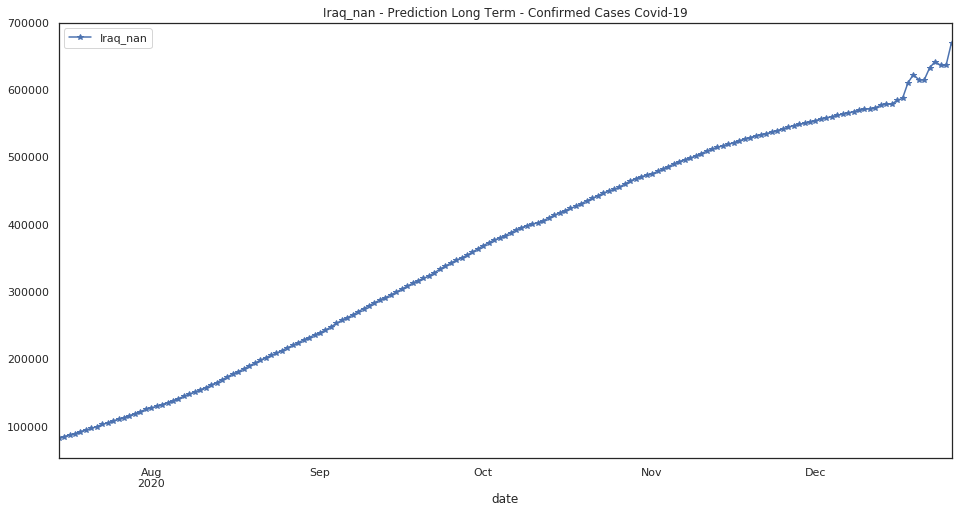

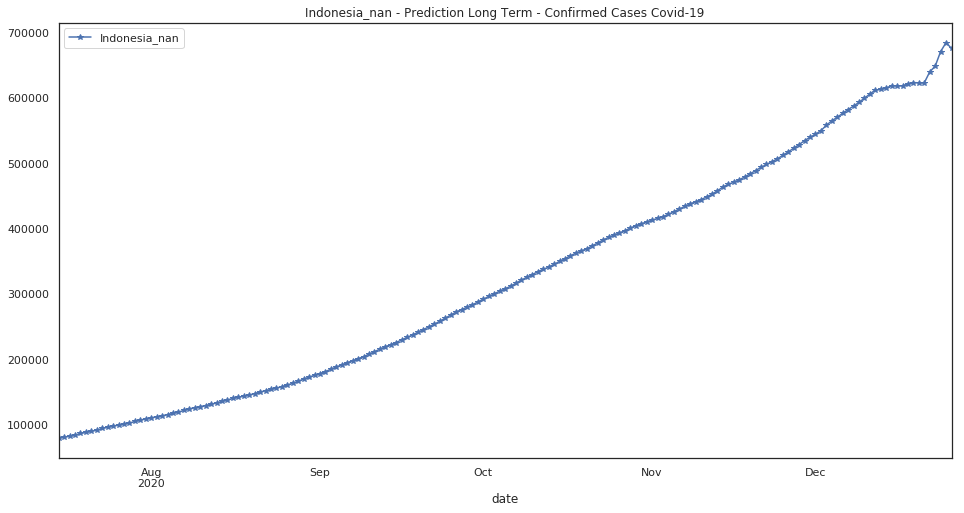

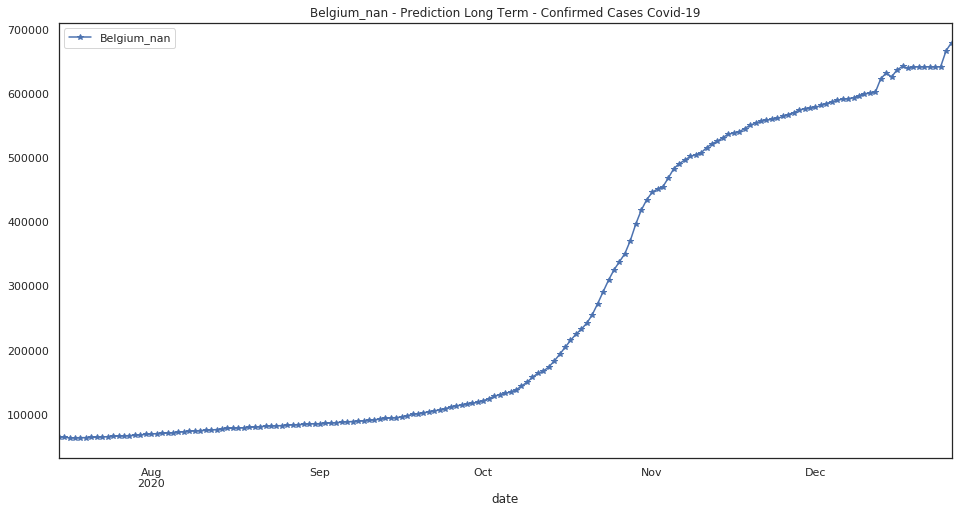

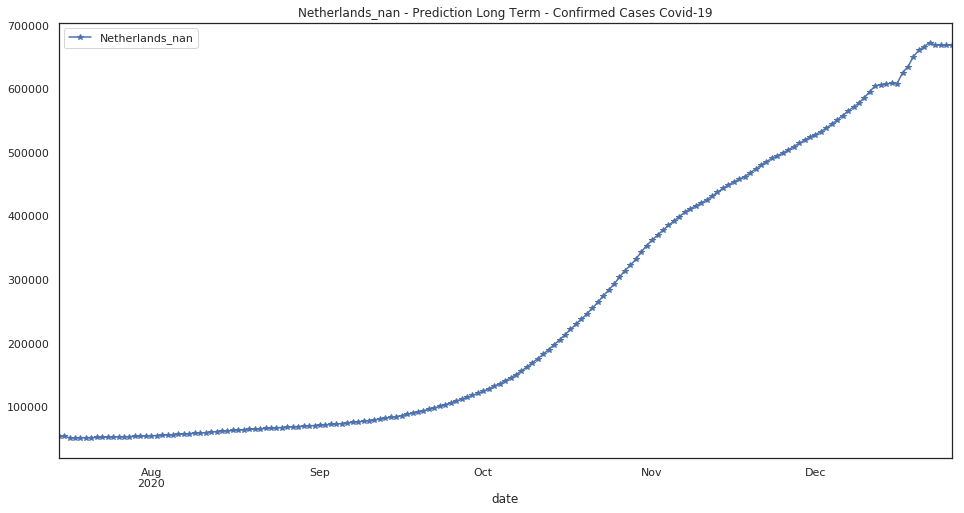

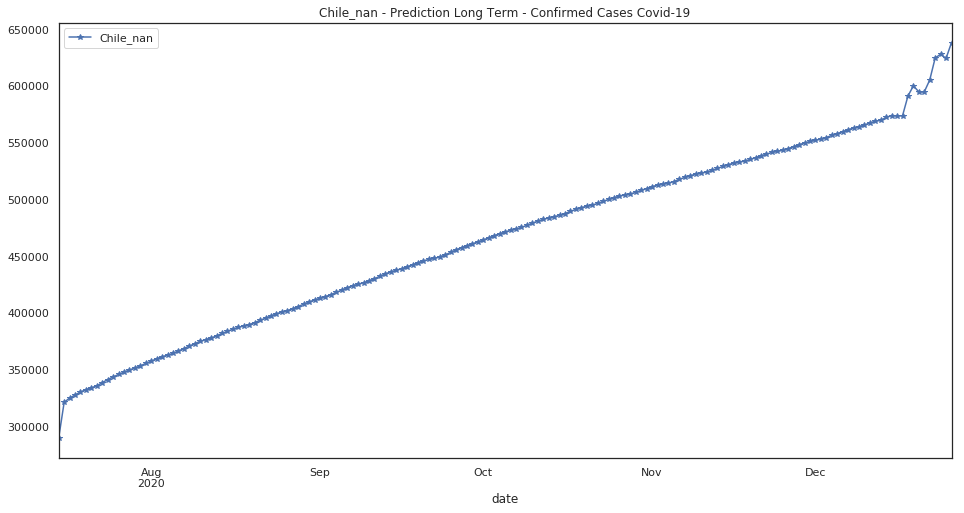

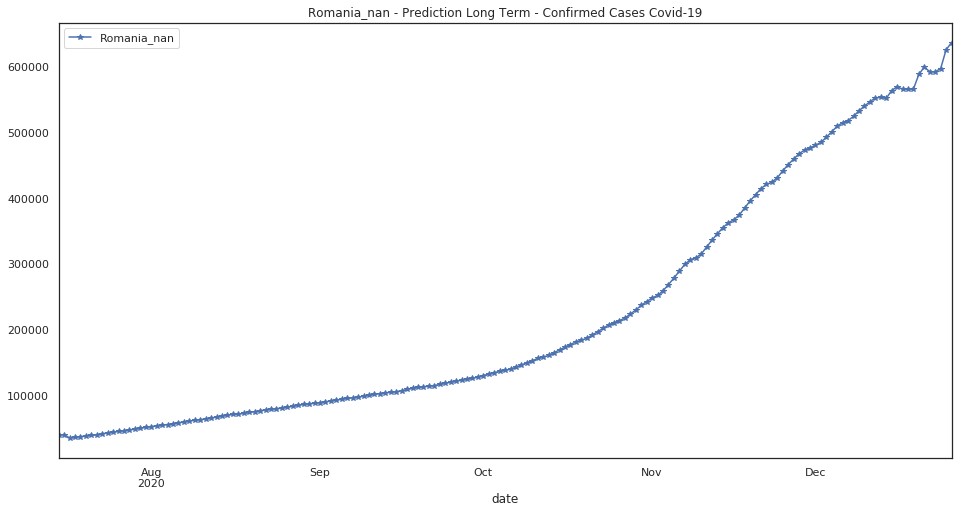

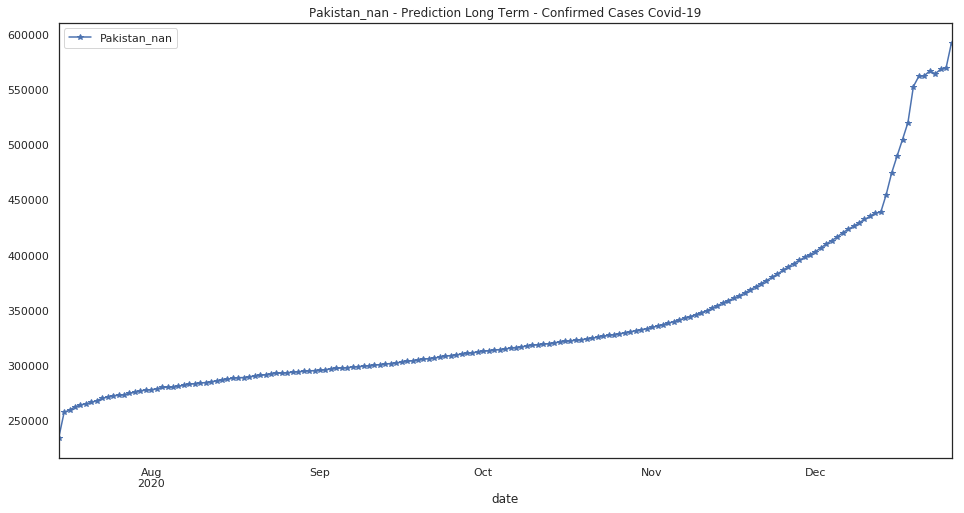

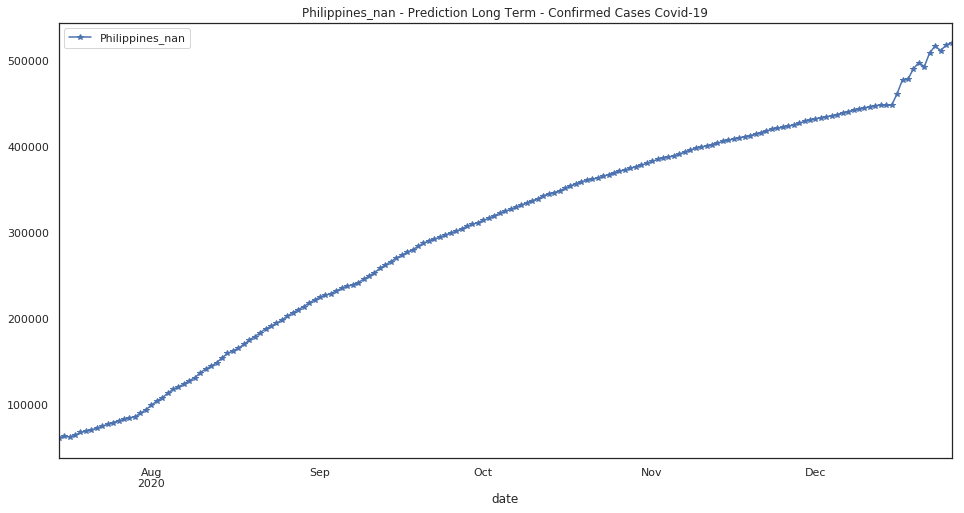

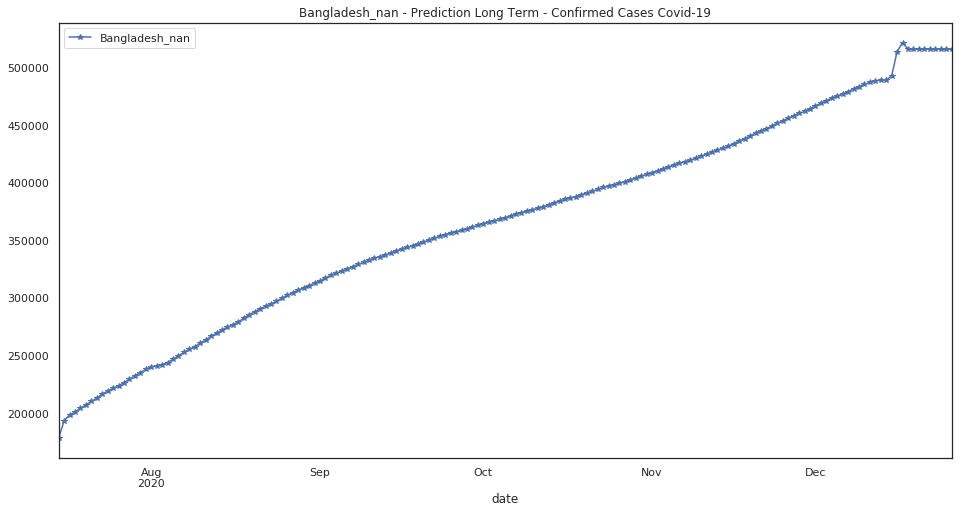

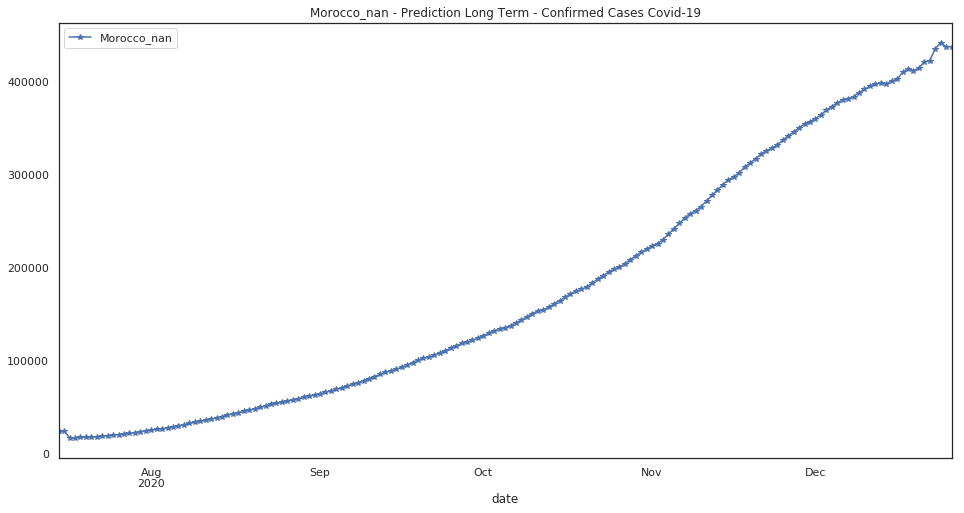

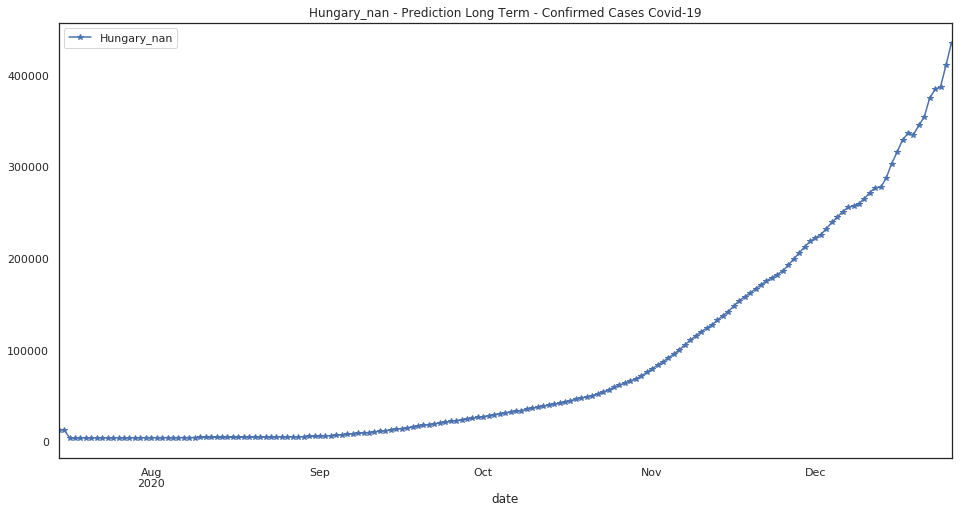

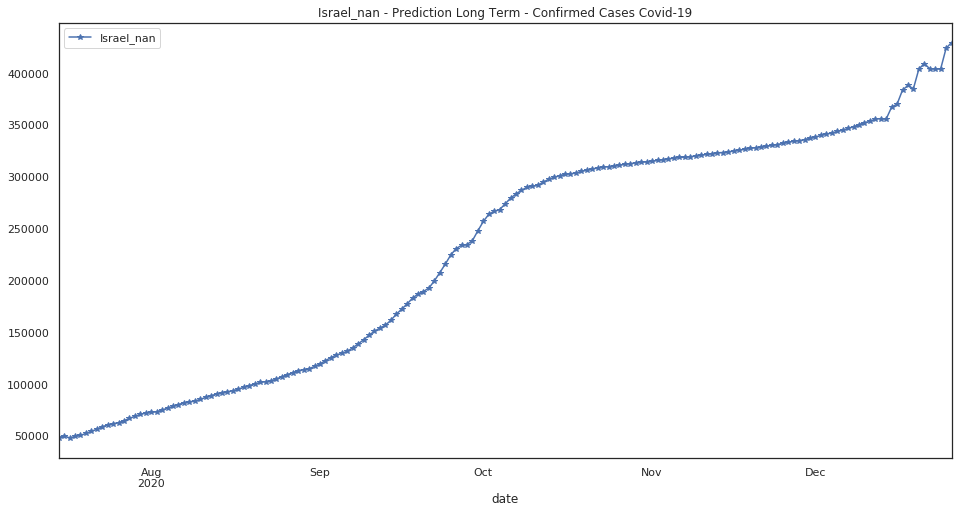

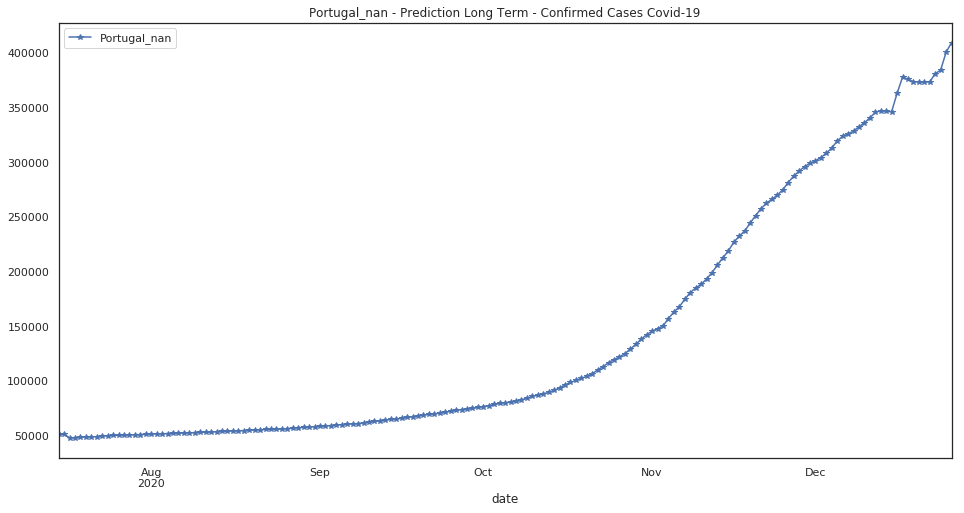

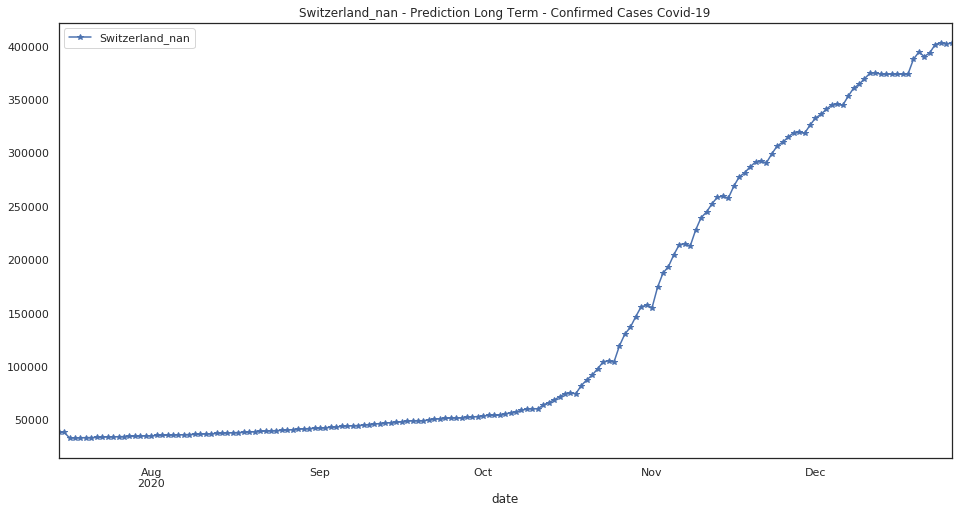

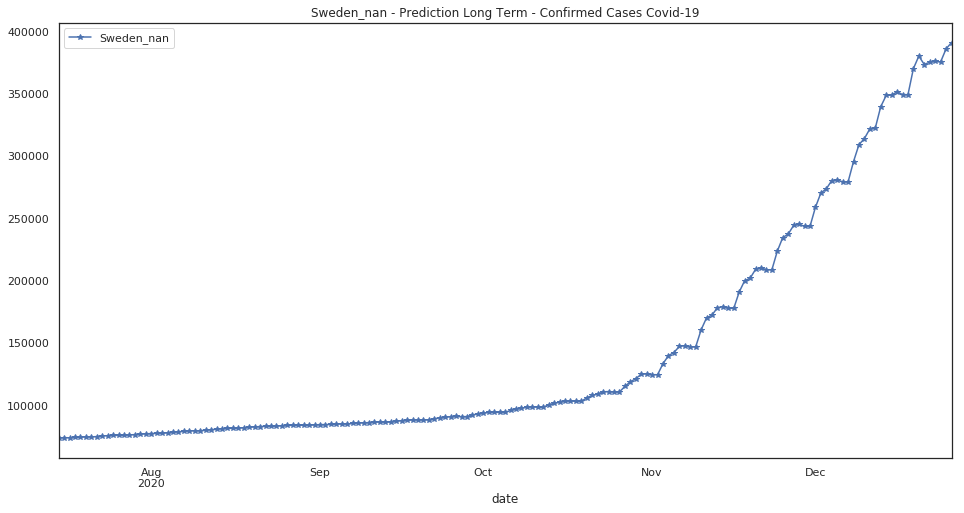

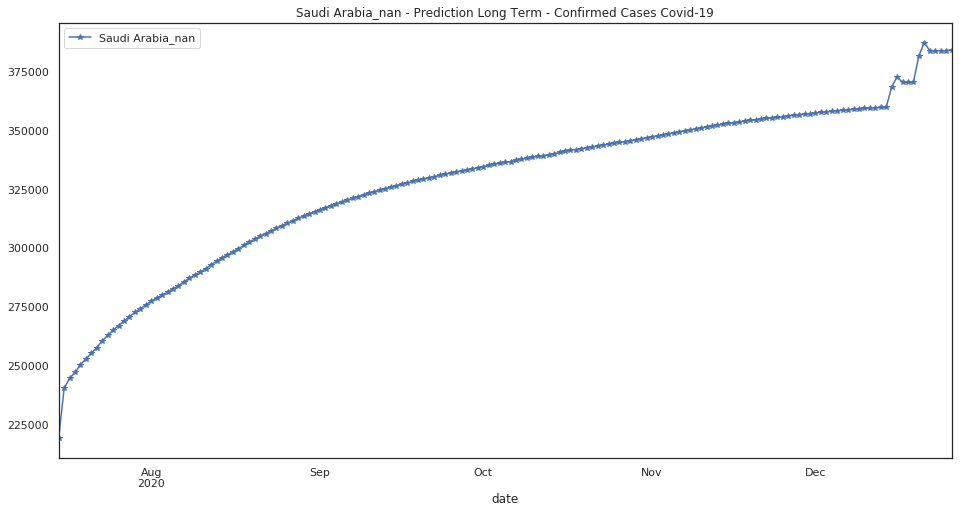

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

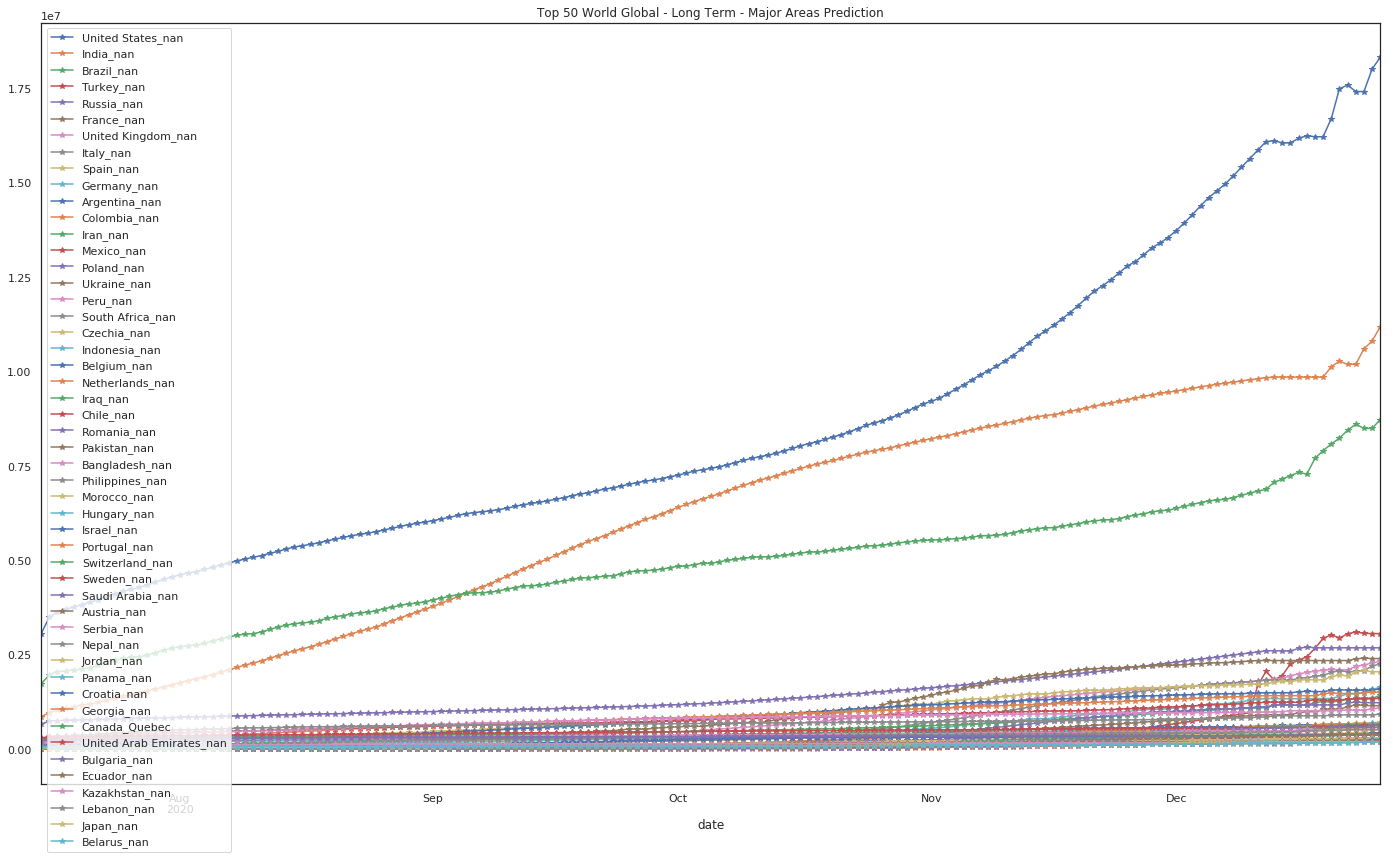

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

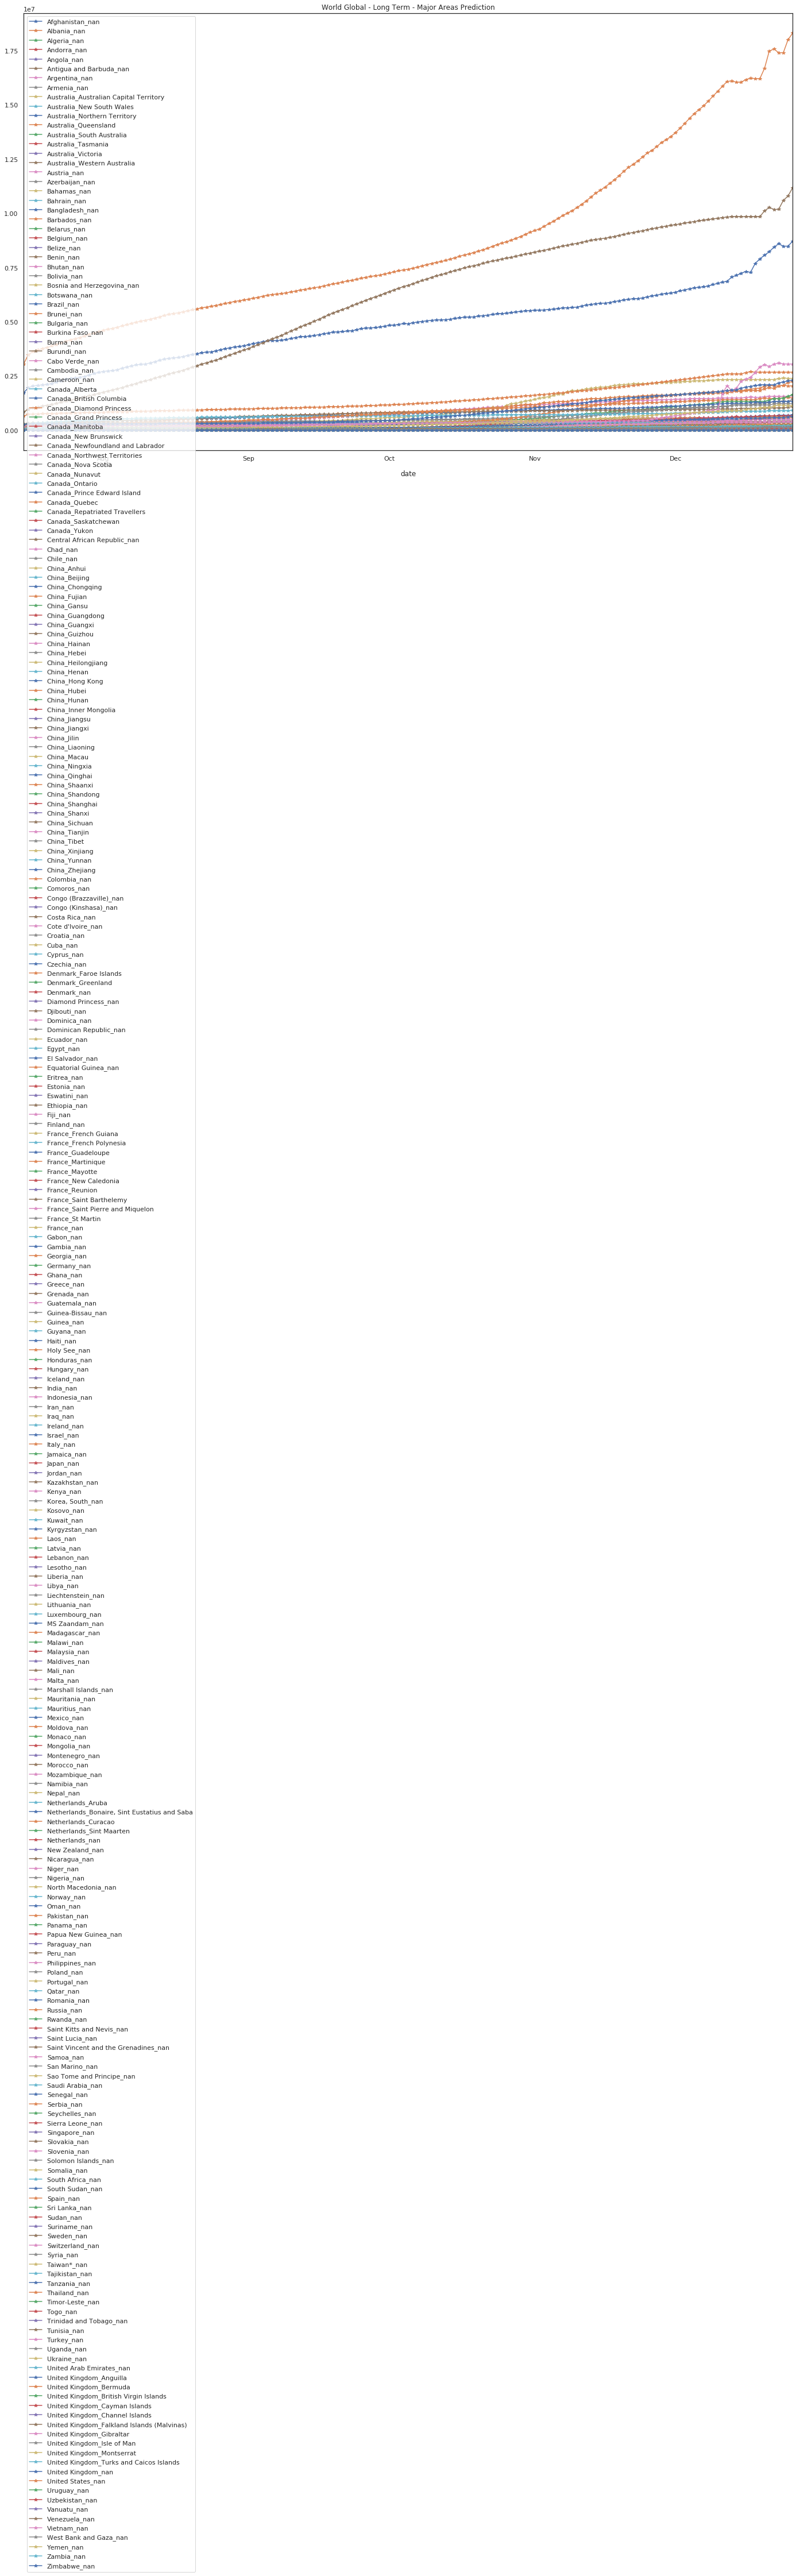

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38159.0       9363.0      43854.0       1124.0   
2020-08-30          38176.0       9474.0      44219.0       1312.0   
2020-08-31          38182.0       9580.0      44567.0       1357.0   
2020-09-01          38210.0       9651.0      44904.0       1176.0   
2020-09-02          38260.0       9800.0      45228.0       1355.0   
2020-09-03          38307.0       9893.0      45537.0       1299.0   
2020-09-04          38328.0      10017.0      45837.0       1406.0   
2020-09-05          38347.0      10149.0      46132.0       1275.0   
2020-09-06          38414.0      10295.0      46423.0       1400.0   
2020-09-07          38510.0      10440.0      46709.0       1441.0   
2020-09-08          38549.0      10594.0      46992.0       1261.0   
2020-09-09          38572.0      10752.0      47269.0       1496.0   
2020-09-10          38598.0      10907.0      47539.0       1301.0   
2020-09-11          38629.0      11067.0      47802.0       1543.0   
2020-09-12          38664.0      11232.0      48056.0       1344.0   
2020-09-13          38735.0      11401.0      48301.0       1558.0   
2020-09-14          38795.0      11568.0      48541.0       1640.0   
2020-09-15          38839.0      11725.0      48778.0       1438.0   
2020-09-16          38880.0      11880.0      49008.0       1735.0   
2020-09-17          38899.0      12017.0      49234.0       1483.0   
2020-09-18          38921.0      12146.0      49453.0       1784.0   
2020-09-19          38943.0      12297.0      49661.0       1564.0   
2020-09-20          39054.0      12439.0      49862.0       1824.0   
2020-09-21          39102.0      12589.0      50058.0       1926.0   
2020-09-22          39122.0      12729.0      50247.0       1681.0   
2020-09-23          39167.0      12860.0      50431.0       2026.0   
2020-09-24          39194.0      12995.0      50609.0       1753.0   
2020-09-25          39210.0      13112.0      50782.0       2091.0   
2020-09-26          39217.0      13227.0      50942.0       1836.0   
2020-09-27          39247.0      13339.0      51093.0       2106.0   
...                     ...          ...          ...          ...   
2020-11-27          45771.0      36413.0      80346.0       6875.0   
2020-11-28          45884.0      36963.0      81384.0       6933.0   
2020-11-29          46134.0      37754.0      82395.0       7107.0   
2020-11-30          46318.0      38361.0      83367.0       7023.0   
2020-12-01          46540.0      39148.0      84315.0       7152.0   
2020-12-02          46756.0      39884.0      85239.0       7195.0   
2020-12-03          46881.0      40653.0      86085.0       7241.0   
2020-12-04          46887.0      41464.0      86870.0       7284.0   
2020-12-05          47075.0      42310.0      87630.0       7349.0   
2020-12-06          47329.0      43165.0      88368.0       7401.0   
2020-12-07          47543.0      43881.0      88952.0       7439.0   
2020-12-08          47749.0      44622.0      89497.0       7494.0   
2020-12-09          47889.0      45373.0      90086.0       7520.0   
2020-12-10          48074.0      46231.0      90646.0       7557.0   
2020-12-11          48161.0      47056.0      91178.0       7607.0   
2020-12-12          48255.0      47923.0      91687.0       7640.0   
2020-12-13          48270.0      49388.0      95291.0       7643.0   
2020-12-14          48251.0      52244.0      96556.0       7737.0   
2020-12-15          50148.0      53727.0      95806.0       7693.0   
2020-12-16          51391.0      53716.0      96154.0       7846.0   
2020-12-17          51665.0      53567.0      96225.0       8022.0   
2020-12-18          52738.0      56359.0      96136.0       7911.0   
2020-12-19          52985.0      57199.0      96126.0       8264.0   
2020-12-20          54515.0      60431.0      99029.0       8486.0   
2020-12-21

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
247                                Thailand_nan  15.870032  100.992541   
248                             Timor-Leste_nan  -8.874217  125.727539   
249                                    Togo_nan   8.619500    0.824800   
250                     Trinidad and Tobago_nan  10.691800  -61.222500   
251                                 Tunisia_nan  33.886917    9.537499   
252                                  Turkey_nan  38.963700   35.243300   
253                           United States_nan  40.000000 -100.000000   
254                                  Uganda_nan   1.373333   32.290275   
255                                 Ukraine_nan  48.379400   31.165600   
256                    United Arab Emirates_nan  23.424076   53.847818   
257                     United Kingdom_Anguilla  18.220600  -63.068600   
258                      United Kingdom_Bermuda  32.307800  -64.750500   
259       United Kingdom_British Virgin Islands  18.420700  -64.640000   
260               United Kingdom_Cayman Islands  19.313300  -81.254600   
261              United Kingdom_Channel Islands  49.372300   -2.364400   
262  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
263                    United Kingdom_Gibraltar  36.140800   -5.353600   
264                  United Kingdom_Isle of Man  54.236100   -4.548100   
265                   United Kingdom_Montserrat  16.742498  -62.187366   
266     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
267                          United Kingdom_nan  55.378100   -3.436000   
268                                 Uruguay_nan -32.522800  -55.765800   
269                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

ValueError: Location values cannot contain NaNs.

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1      16               Austria_nan  47.516200   14.550100   
2      20            Bangladesh_nan  23.685000   90.356300   
3      22               Belarus_nan  53.709800   27.953400   
4      23               Belgium_nan  50.833300    4.469936   
5      30                Brazil_nan -14.235000  -51.925300   
6      32              Bulgaria_nan  42.733900   25.485800   
7      53             Canada_Quebec  52.939900  -73.549100   
8      59                 Chile_nan -35.675100  -71.543000   
9      93              Colombia_nan   4.570900  -74.297300   
10     99               Croatia_nan  45.100000   15.200000   
11    102               Czechia_nan  49.817500   15.473000   
12    110               Ecuador_nan  -1.831200  -78.183400   
13    130                France_nan  46.227600    2.213700   
14    133               Georgia_nan  42.315400   43.356900   
15    134               Georgia_nan  42.315400   43.356900   
16    135               Germany_nan  51.165691   10.451526   
17    147               Hungary_nan  47.162500   19.503300   
18    149                 India_nan  20.593684   78.962880   
19    150             Indonesia_nan  -0.789300  113.921300   
20    151                  Iran_nan  32.427908   53.688046   
21    152                  Iraq_nan  33.223191   43.679291   
22    154                Israel_nan  31.046051   34.851612   
23    155                Israel_nan  31.046051   34.851612   
24    156                 Italy_nan  41.871940   12.567380   
25    158                 Japan_nan  36.204824  138.252924   
26    159                Jordan_nan  31.240000   36.510000   
27    160            Kazakhstan_nan  48.019600   66.923700   
28    168               Lebanon_nan  33.854700   35.862300   
29    169               Lebanon_nan  33.854700   35.862300   
30    186                Mexico_nan  23.634500 -102.552800   
31    191               Morocco_nan  31.791700   -7.092600   
32    194                 Nepal_nan  28.166700   84.250000   
33    199           Netherlands_nan  52.132600    5.291300   
34    207              Pakistan_nan  30.375300   69.345100   
35    208                Panama_nan   8.538000  -80.782100   
36    211                  Peru_nan  -9.190000  -75.015200   
37    212           Philippines_nan  12.879721  121.774017   
38    213                Poland_nan  51.919400   19.145100   
39    214              Portugal_nan  39.399900   -8.224500   
40    216               Romania_nan  45.943200   24.966800   
41    217                Russia_nan  61.524010  105.318756   
42    225          Saudi Arabia_nan  23.885942   45.079162   
43    227                Serbia_nan  44.016500   21.005900   
44    235          South Africa_nan -30.559500   22.937500   
45    237                 Spain_nan  40.463667   -3.749220   
46    241                Sweden_nan  60.128161   18.643501   
47    242           Switzerland_nan  46.818200    8.227500   
48    252                Turkey_nan  38.963700   35.243300   
49    253         United States_nan  40.000000 -100.000000   
50    255               Ukraine_nan  48.379400   31.165600   
51    256  United Arab Emirates_nan  23.424076   53.847818   
52    267        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              106540.0             111146.0             118227.0   
1               26241.0              26342.0              19270.0   
2              178505.0             193590.0             198217.0   
3               66646.0              66803.0              65623.0   
4               64402.0              64721.0              63238.0   
5             1726279.0            1966748.0            2049695.0   
6               16397.0              16630.0               8144.0   
7               59153.0              59277.0              57001.0   
8              289899.0           

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()